## Импорт библиотек

In [17]:
  # Библиотека с API для рекомендательных моделей
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
# Библиотека с API для рекомендательных моделей
!pip install rankfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import nltk
import pymorphy2
import requests

In [21]:
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Сохранение и загрузка моделей
import pickle

# Графики
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотека для рекомендаций Implicit
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking

# Библиотека для рекомендаций RankFM
from rankfm.rankfm import RankFM
from rankfm import evaluation

# Векторизация текстов
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.metrics.pairwise import cosine_similarity
import sklearn.preprocessing as pp

from sklearn.decomposition import TruncatedSVD

- В исходную функцию для подсчета метрик добавим количество угаданных книг

- Так будет проще ориентироваться в результатах

In [23]:
from numpy.lib.twodim_base import triu_indices_from
def contest_metric(df_solution, df_grd, print_report=True):

  """
  Выводит метрики Recall, Precision, F1-score и количество угаданных книг  
  
  """

  pred = set(df_solution['chb'] + '_' + df_solution['sys_numb'].values)
  true = set(df_grd['chb'] + '_' + df_grd['sys_numb'].values) 
  recall = len(pred.intersection(true)) / len(true)
  precision = len(pred.intersection(true)) / (20 * len(df_grd['chb'].unique()))
  
  f1_score = 2 * (precision * recall) / (precision + recall)
  true_pairs_count = len(pred.intersection(true))

  if print_report == True:
    print(f"Угаданных книг: {true_pairs_count}")
    print(f"Recall: {round(recall, 5)}")
    print(f"Precision: {round(precision, 5)}")
    print(f"F1-score: {round(f1_score, 5)}")  

  return [true_pairs_count, recall, precision, f1_score]

## Загрузка файлов

In [24]:

# Доступ к файлам на colab

import glob
import os

# Importing drive method from colab for accessing google drive
from google.colab import drive

# Mounting drive
# This will require authentication : Follow the steps as guided
drive.mount('/content/drive')

# Viewing the data in the folder present from the drive
!ls "/content/drive/My Drive/Colab Notebooks"

Mounted at /content/drive
 added_als_for_unactive_users.csv
 added_als_for_unactive_users_more_books.csv
 all_users_predictions.csv
 all_users_predictions_train.csv
 als_predictions.csv
 als_predictions_matrix.csv
 baseline.ipynb
 filtered_users_predictions_train.csv
 half_users2.csv
 half_users_bbk_title_300_russian_stop_words.csv
 half_users_bbk_title_300_stop_words.csv
 half_users_bbk_title.csv
 half_users_bbk_title_short_russian_stop_words.csv
 half_users_best_als.csv
 half_users.csv
 half_users_title_300_stop_words.csv
 half_users_title_no_read_books.csv
 hybrid_for_users_books_13.csv
 hybrid_solution_v1.csv
 hybrid_solution_v2.csv
 hybrid_solution_v3.csv
 items.csv
 items_ML.csv
 new_als_predictions_90.csv
 new_als_predictions_all_2.csv
 new_als_predictions_all.csv
 new_als_predictions_filter_books.csv
 new_als_predictions_train.csv
 new_predictions.csv
 predictions_als_imp_duplicates.csv
 predictions_bpr_imp.csv
 predictions_warp.csv
 rankfm_base_recs.csv
 rankfm_bpr_books_recs.

In [25]:
# Меняем домашнюю директорию
# для доступа к датасетам
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [26]:
# Cчитывание данных

# читатели
users = pd.read_csv(
    './users.csv', sep=';', index_col=None, 
     dtype={'age': str, 'chb': str, 'chit_type': str, 'gender': str})

# книги
items = pd.read_csv(
    'items.csv', sep=';', index_col=None, 
     dtype={'author': str, 'bbk': str, 'izd': str, 
           'sys_numb': str, 'title': str, 'year_izd': str})

# история книг в библиотеке
transactions = pd.read_csv(
    'train_transactions_extended.csv', 
    sep=';', index_col=None,
    dtype={'chb': str, 'date_1': str, 'is_printed': str, 
            'is_real': str, 'source': str, 'sys_numb': str, 'type': str})

## ЭТАП 5. Content Based Filtering для "неактивных" читателей и книг

### Вводные

#### Проблема "Cold Start"

1. Мы уже нашли книги, для которых не работает подход Colloborative Filtering

  - книги, которые прочитали всего `1 или 2 читателя`

2. Для остальных книг мы получили более высокие результаты:

  -  HitRate ~15%
  -  в 8 раз выше, чем на "редких" книгах

Посмотрим, какие пользователи не попали в датасет с "популярными" книгами!


In [27]:
unique_transactions = transactions[['chb', 'sys_numb']].drop_duplicates()

# Создаем новый датафрейм с количеством  читателей
# для каждой книги
books_popularity = (
    unique_transactions
    .groupby('sys_numb')
    .chb.count().to_frame()
    .rename(columns={'chb':'users_count'}))

# Создаем новый датафрейм с активностью пользователей
user_books_count = (
     unique_transactions.groupby('chb')
    .count().rename(columns={'sys_numb':'books_count'}))

In [28]:
# Оставляем книги с количеством читателей > 2
hot_start_dataset = (unique_transactions
                      .loc[lambda x: x.sys_numb.isin(
                          books_popularity.query('users_count > 2').index)]
                    )

In [29]:
# Книги и пользователи, которые не вошли в новый датасет
cold_start_books = (
  set(unique_transactions.sys_numb.unique()) - set(hot_start_dataset.sys_numb.unique())
)

cold_start_users = (
  set(unique_transactions.chb.unique()) - set(hot_start_dataset.chb.unique())
)


print("Читатели:", unique_transactions.chb.nunique())
print("Книги, которые читают:", unique_transactions.sys_numb.nunique())
print("------------------------------------------------------------------------")
print("==> Пользователи, для которых не работает CF (проблема Cold Start) <==\n")
print("Редких книг:", len(cold_start_books))
print("Читателей:", len(cold_start_users))
print("Количество книг, которые читают:",
      user_books_count[user_books_count.index.isin(
          cold_start_users
          )].books_count.describe())

Читатели: 16753
Книги, которые читают: 194666
------------------------------------------------------------------------
==> Пользователи, для которых не работает CF (проблема Cold Start) <==

Редких книг: 188853
Читателей: 9071
Количество книг, которые читают: count    9071.000000
mean        6.525962
std         8.971851
min         2.000000
25%         3.000000
50%         4.000000
75%         7.000000
max       495.000000
Name: books_count, dtype: float64


- Интересно, у нас также "отпали" пользователи, которые читают больше 7 книг и даже 400!

**Вывод**

1. Colloborative Filtering может работать для "зеленых" пользователей (c историей из 1-3 книг)

  - Если эти книги популярны среди других читателей =)

2. Colloborative Filtering может оказаться бесполезным для "активных" пользователей:

  - Если они читают очень редкие книги, которые не успели заинтересовать других пользователей)

3. Таких читателей сейчас > 50%, а "редких" книг - 97%!



- 

#### Решение

Попробуем использовать автоматический поиск **похожих** книг. 
Можем протестировать два подхода:


1. Метод `Content Based Filtering` для рекомендации набора похожих книг:

  - здесь нам не нужны рейтинги и интересы других пользователей)

2. Поиск "единомышленников" по книгам, которые похожи на текущие книги читателя.

  - возможно, они не читали Таню Гроттер, но читали "Узника Азкабана":)
  - такой подход даст большее разнообразие рекомендаций

3. Порекомендовать самые популярные книги из похожих жанров:)

Это будет альтернативой моделям `Colloborative Filtering`:
- даст возможность в итоге собрать **гибридную** рекомендательную систему.
- использовать различные подходы к персональным рекомендациям.



### Оценка данных и план работы

#### Добавляем данные о книгах

Добавим в обучающий датасет с тарнзациями интересную инофрмацию о книгах:
- описание
- авторы
- год издания
- bbk (здесь, возможно, кроется информация о жанрах)


In [30]:
bk_transactions = (
    transactions[['chb', 'sys_numb']].drop_duplicates()
    .set_index('sys_numb')
    .join(items.set_index('sys_numb').drop('izd', axis=1))
    .reset_index()
)

bk_transactions.head(5)

,sys_numb,chb,title,author,year_izd,bbk
0,RSL01000000123,100000934918,"Антропонимы в киргизском героическом эпосе ""Ма...","Боронов, Адина Айылчиевич",1988,"Ш3(257=Ки)-611,0\nШ163.25-314,0"
1,RSL01000000244,300001043470,Chlorella pyrenoidosa 82Т как тест-объект в би...,"Дедов, Александр Викторович",1998,"Е591.21с,0"
2,RSL01000000259,300001090044,Айседора Дункан и театральная культура эпохи М...,"Добротворская, Карина Анатольевна",1992,"Щ327.75(7США)-86ДунканА.0,0"
3,RSL01000000457,100000728030,"""Записки"" А. И. Кошелева как памятник отечеств...","Летягин, Лев Николаевич",1993,"Ш5(2=Р)52-4КошелевА.И.534,0"
4,RSL01000000462,200001091160,Аграрная буржуазия в политической жизни Индии ...,"Литвин, Алексей Васильевич",1990,"Т3(5Ид)63-283,02\nТ3(5Ид)63-5,02"


#### Коды bbk и жанры

Посмотрим, насколько информативен новый датасет. Важнее всего поле bbk - жанр!

In [31]:
bk_transactions.isna().sum()

sys_numb     0
chb          0
title        0
author       0
year_izd     1
bbk         49
dtype: int64

Всего 50 пропусков..Слишком хорошо, чтобы быть правдой) Проверим!

In [32]:
bk_transactions.bbk.value_counts()

none                          67832
отсутствует                   17267
Щ158.9открытки3(2Р=Р)53-3       721
Ш5(2=Р)75-644.6                 721
Ю949.2,0                        474
                              ...  
Ю959.2,0\nЦ4,8(2)301.1            1
В1р(2)3-3,0                       1
Х620.612.299(2Р547)я431(2)        1
З973.2-018ц2я73-1                 1
Р62-433.77,0                      1
Name: bbk, Length: 79099, dtype: int64

Вот и загвоздка, 80 000 книг без жанров:/ Посмотрим, сколько книг останется для рекомендаций

In [33]:
print("Книги с bbk в датасете с транзакциями:",
bk_transactions.query('bbk != "none" and bbk!= "отсутствует"').sys_numb.nunique())

Книги с bbk в датасете с транзакциями: 119805


In [34]:
print("Книги с bbk в общей библиотеке:",
items[~items.bbk.isna()].query(
    'bbk != "none" and bbk!= "отсутствует"').sys_numb.nunique())

Книги с bbk в общей библиотеке: 215783


**Вывод 1**

1. У нас неполный набор данных о книгах, которые (!) уже читали:
  - 119 805 книг без пропусков в bbk

2. "+" ~100 000 книг с данными о bbk в общей библиотеке

2. Если удастся раскодировать bbk, то мы сможем рекомендовать не только похожие книги одного и того же автора (или сборника), но и что-то новенькое))

Прежде чем переходить к парсингу `bbk`, посмотрим, есть ли у нас уже книги с общим кодом?

In [35]:
# Количество книг с одинаковым bbk
(bk_transactions
 .query('bbk != "none" and bbk!= "отсутствует"')
 .bbk.value_counts().head(30))

Щ158.9открытки3(2Р=Р)53-3                                     721
Ш5(2=Р)75-644.6                                               721
Ю949.2,0                                                      474
Ш5(2=Р)75-644                                                 226
Э391.9,0                                                      223
Э240.03,0                                                     211
Ш5(2=Р)64-644.6                                               206
Э391.211,0                                                    202
Ш5(2=Р)64-644                                                 190
Ш5(2=Р)75-65я44                                               166
Х0я73-1                                                       165
Р120.4я9                                                      158
Щ156.658.3(2)53                                               148
Э391.215,0                                                    138
С556.511,0                                                    137
Х623я73-1 

**Вывод 2**

1. Из bbk мы можем узнать о жанре каждой книги:

  - распрасить, например, Ш5 = Мировая Литература, (2=Р) - Румынская литература
  - скачать БД со всеми кодами и доп.информацией

2. На первом этапе попробуем группировать книги по полному bbk без парсинга

#### Авторы

Авторов мы уже изучали, даже построили CF модель для рекомендации новых писателей

In [36]:
print("Количество книг каждого автора в активном пуле:")
(bk_transactions
 .query('bbk != "none" and bbk!= "отсутствует"')
 .author.value_counts().head(30))

Количество книг каждого автора в активном пуле:


none                                        31012
Конволют                                      308
Зверев, Сергей Иванович 1964-                 164
Струнников, Сергей Николаевич 1907-1944       120
Серова, Марина Сергеевна                       94
Нащокина, Мария Владимировна                   76
Москва, город                                  51
Нестеров, Михаил Петрович 1959-                50
Российская Федерация Законы                    46
Юнг, Карл Густав 1875-1961                     43
Романюк, Сергей Константинович                 41
Шахов, Максим Анатольевич 1964-                39
Фрейд, Зигмунд 1856-1939                       38
Устинова, Татьяна Витальевна 1968-             37
Алексеев, Сергей Сергеевич 1924-2013           37
По, Айрэн                                      35
Вострышев, Михаил Иванович                     34
Аристотель 384-322 до н. э.                    34
Сарабьянов, Дмитрий Владимирович               34
Широкорад, Александр Борисович                 34


In [37]:
print("Количество различных авторов для каждого bbk ")
bk_transactions.groupby('bbk').author.nunique().sort_values().tail(30)

Количество различных авторов для каждого bbk 


bbk
Ю953,0                48
Р358.9я9              49
Ю96,0                 52
Ш141.2-916.3,0        52
Х916.8,0              54
Х620.612.2,0          56
Ю949.2с,0             57
Х623.1,0              59
Х622.2,0              60
Х628.111.2,0          60
Ш5(2=Р)64-644.6       61
С508,0                63
Ю948.1-82,0           64
У9(2)29,0             69
Ш5(2=Р)75-6я44        76
Ш5(2=Р)64-65я44       80
Э391.215,0            84
Ш5(2=Р)64-644.5       89
С555.511,0            90
С556.511,0           105
Э240.03,0            121
Р120.4я9             124
Ш5(2=Р)75-65я44      128
Э391.211,0           129
Э391.9,0             141
Ш5(2=Р)64-644        144
Ш5(2=Р)75-644.6      174
Ш5(2=Р)75-644        178
Ю949.2,0             268
none               40383
Name: author, dtype: int64

In [38]:
print("Пример книг и кодов bbk для Конволют")

bk_transactions.query(
  'author == "Конволют"'
)

Пример книг и кодов bbk для Конволют


,sys_numb,chb,title,author,year_izd,bbk
4417,RSL01000572717,300000800833,Население России … : … ежегодный демографическ...,Конволют,1998,"С73(2)7,0"
13235,RSL01000860818,200001141982,Население России … : … ежегодный демографическ...,Конволют,1999,"С73(2)7,0"
14024,RSL01000949168,200001112107,: Roseum memoriale divinorum eloquiorum,Конволют,1493,none
14025,RSL01000949168,300000992541,: Roseum memoriale divinorum eloquiorum,Конволют,1493,none
16594,RSL01001228080,200000986599,Общее и прикладное языкознание : указ. литерат...,Конволют,1984,none
...,...,...,...,...,...,...
211875,RSL01011011478,200001057702,Справочник секретаря и офис-менеджера : практи...,Конволют,2022,none
211876,RSL01011011478,300001127269,Справочник секретаря и офис-менеджера : практи...,Конволют,2022,none
211884,RSL01011013848,300001093275,Вестник Томского государственного архитектурно...,Конволют,2022,none
211885,RSL01011014475,100001155175,GQ Style : журнал : Выпуски за 2022 год : 2022...,Конволют,2022,none


**Вывод**

1. Добавление авторов в модель:

  - Можем получить более высокие результаты предсказаний, т.к. многие берут книги из одного сборника или серии

  - Такие рекомендации менее интересны читателям 

  - В авторах у нас дополнительно еще 30 000 пропусков


3. Сфокусируемся вначале только на жанрах:

  - каждому bbk может соответствовать группа авторов
  
  - новые книги и авторы из похожих жанров должны сильнее заинтересовать читателей:)

#### Общий вывод

1. На первом этапе мы берем только книги **из "общего" пула** с транзакциями.

2. Первую модель построим на варианте с `bbk` и `годами выпуска`, далее можно добавить:

  - жанры из парсинга bbk

  - леммы из названий книг (тоже интересный вариант)

  - авторов (вдруг для читателя все-таки найдется самое подходящее для него произведение)

3. **Cкомбинируем** полученные рекомендации с рекомендациями из Colloborative Filtering.

### Предобработка данных

#### Общие идеи

In [39]:
bk_transactions.query('bbk == "отсутствует"')

,sys_numb,chb,title,author,year_izd,bbk
3687,RSL01000344287,300000945480,отсутствует,отсутствует,отсутствует,отсутствует
5100,RSL01000589118,300000907376,отсутствует,отсутствует,отсутствует,отсутствует
5102,RSL01000589137,200000937642,отсутствует,отсутствует,отсутствует,отсутствует
5103,RSL01000589137,300000907376,отсутствует,отсутствует,отсутствует,отсутствует
11462,RSL01000728814,200001046353,отсутствует,отсутствует,отсутствует,отсутствует
...,...,...,...,...,...,...
228997,RSL60000347951,300000807978,отсутствует,отсутствует,отсутствует,отсутствует
228998,RSL60000347953,300000807978,отсутствует,отсутствует,отсутствует,отсутствует
228999,RSL60000349894,200000844116,отсутствует,отсутствует,отсутствует,отсутствует
229000,RSL60000349906,200000844116,отсутствует,отсутствует,отсутствует,отсутствует


- 20 000 книг с "отсутсвует" точно удалим из обучения, не раздумывая

- Было бы неплохо уточнить, возможно, где-то ошибка в БД

In [40]:
bk_transactions.query('bbk == "none"')

,sys_numb,chb,title,author,year_izd,bbk
387,RSL01000080370,300001102845,Московские частные художественные студии как я...,"Абаренкова, Елена Валерьевна",1996,none
488,RSL01000100670,300001116148,Формирование познавательного интереса у учащих...,"Кухарь, Алевтина Васильевна",1984,none
740,RSL01000143939,200000955424,Обоснование оптимальных параметров основных эл...,"Смирнов, Николай Григорьевич",1996,none
742,RSL01000144642,300000906881,Формирование ценностных ориентаций старшекласс...,"Анисимова, Татьяна Семеновна",Б. г.,none
746,RSL01000145484,300001129283,Формирование культуры речи у студентов педагог...,"Григорьева, Виктория Аркадьевна",1996,none
...,...,...,...,...,...,...
211948,RSL01011034405,200000955709,Отчет Государственного контроля по исполнению ...,none,СПб 1883,none
211949,RSL01011035001,300000935124,Опыт работы Государственной Публичной библиоте...,none,1954,none
211950,RSL01011035222,200000921337,Compte Rendu of the XV Session South-Africa 19...,none,Pretoria 1930,none
211951,RSL01011035900,100001083391,"Сборник ВИЗР,вып.4-5",none,"Ленинград,1932-1933",none


- Для первого этапа "none" удалим, а дальше (если будем строить модель и на других признаках), оставим эти книги

In [41]:
df_ML = bk_transactions[['chb', 'sys_numb', 'bbk', 'title', 'year_izd', 'author']].copy()
# .query('bbk != "none" and bbk!= "отсутствует"').copy()

df_ML['bbk'] = df_ML['bbk'].replace("none", "unknown")
df_ML['bbk'] = df_ML['bbk'].replace("отсутствует", "unknown")
df_ML['bbk'] = df_ML['bbk'].fillna("unknown")


print("Новый датасет для Content-Based рекомендаций")
print("Количество читателей:", df_ML.chb.nunique())
print("Количество книг:", df_ML.sys_numb.nunique())
print("Количество пропусков:")

df_ML.isna().sum()

Новый датасет для Content-Based рекомендаций
Количество читателей: 16753
Количество книг: 194666
Количество пропусков:


chb         0
sys_numb    0
bbk         0
title       0
year_izd    1
author      0
dtype: int64

- Для всех пользователей найдутся рекомендации))


In [42]:
df_ML.dtypes

chb         object
sys_numb    object
bbk         object
title       object
year_izd    object
author      object
dtype: object

**Вывод**

1. Все поля нужно будет закодировать до обучения:

  - Для sys_numb и chb у нас уже есть готовый подход

  - bbk можно закодировать произвольным образом

  - Год издания `year_izd` перевести в целый тип

  - Поле `title` перевести в набор слов одного регистра

2. Книги с bbk='отсутствуют' не имеют описаний и авторов (~20 000):

  - еще 67 000 c bbk='none' мы удалили только для первого этапа обучения.

#### Год издания

In [43]:
df_ML['year_izd'].value_counts().sort_values()

Ленинград,1932-1933        1
[185-]                     1
сор. 2011                  1
И. П. Цыбулько             1
печ. 1971                  1
                       ...  
2008                    8007
2020                    8048
2017                    8273
2016                   10217
отсутствует            17267
Name: year_izd, Length: 1795, dtype: int64

- Пока мы не можем перевести год выпуска в целый тип

- Попробуем отсечь 4 цифры с помощью регулярных выражений (одного года нам будет достаточно)

In [44]:
df_ML['year_2'] = df_ML['year_izd'].str.extract(r'(\d{4})')
df_ML['year_2'].value_counts().sort_values()

1724        1
1538        1
1738        1
1705        1
1759        1
        ...  
2019     7845
2008     8066
2020     8581
2017     8803
2016    10761
Name: year_2, Length: 336, dtype: int64

- Выглядит неплохо!

- Проверим, не осталось ли некорректных данных

In [45]:
df_ML['year_2'].isna().sum()

20035

In [46]:
print("Пропуски в годе издания книги:")
df_ML[df_ML.year_2.isna()]

Пропуски в годе издания книги:


,chb,sys_numb,bbk,title,year_izd,author,year_2
742,300000906881,RSL01000144642,unknown,Формирование ценностных ориентаций старшекласс...,Б. г.,"Анисимова, Татьяна Семеновна",NaN
775,200001103737,RSL01000152245,"Х623.213.1,0",Проблемы становления и перспективы развития ин...,Б. г.,"Шичанин, Алексей Викторович",NaN
811,300001064485,RSL01000157291,"Ш5(2=Р)53-4Чехов А.П.54,0",Проблема женских характеров в рассказах А. П. ...,Б. г.,"Лукьянова, Людмила Владимировна",NaN
815,300000842297,RSL01000157983,"У9(2)321.4,0",Развитие фермерских хозяйств в условиях перехо...,Б. г.,"Серов, Вячеслав Михайлович",NaN
1024,200001126554,RSL01000187571,unknown,Метод создания и реализации графического интер...,Б. г.,"Ле, Куок Лонг",NaN
...,...,...,...,...,...,...,...
228997,300000807978,RSL60000347951,unknown,отсутствует,отсутствует,отсутствует,NaN
228998,300000807978,RSL60000347953,unknown,отсутствует,отсутствует,отсутствует,NaN
228999,200000844116,RSL60000349894,unknown,отсутствует,отсутствует,отсутствует,NaN
229000,200000844116,RSL60000349906,unknown,отсутствует,отсутствует,отсутствует,NaN


- Примерно тысяча книг, не будем удалять - похоже, это все ХХ век (или раньше)


In [47]:
df_ML.year_2.fillna('1900').astype('int').describe()

count    229002.000000
mean       1985.647549
std          46.010723
min        1092.000000
25%        1977.000000
50%        2006.000000
75%        2015.000000
max        5771.000000
Name: year_2, dtype: float64

- Есть еще загадочный год 5771..

- Большая часть - современные издания (но год написания может быть другой!)

In [48]:
df_ML['year_2'] = df_ML['year_2'].fillna('1900').astype('int')

print("Книги, датируемые позже 2022 года")
df_ML[df_ML['year_2'] > 2022]

Книги, датируемые позже 2022 года


,chb,sys_numb,bbk,title,year_izd,author,year_2
45305,200001132993,RSL01002756569,"Т3(532-2Хеврон)0,02",Кирьят Арба - Хеврон - город древний и молодой...,5761 (2001),none,5761
103065,300001124676,RSL01004976545,"Э36-210.91,0",Тора из Цийона. Пятикнижие Моше. Книга Бамидба...,5771 [2011],Тора,5771
163692,200001026068,RSL01008788263,"Е088в.я9\nЮ252:Е022,0",Биофилия. Врожденная тяга к живому как связь ч...,2117 (cop. 2016),"Уилсон, Эдвард Осборн 1929-",2117


- Интересная подборка))

- 5 книг пророка Моисея! Случайности не случайны)

Сделаем обычную замену

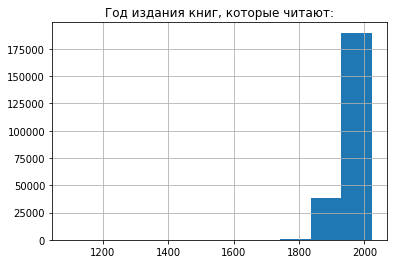

In [49]:
df_ML['year_2'] = df_ML['year_2'].replace({5761:2001, 5771:2011, 2117:2016})
df_ML.year_2.hist()
plt.title("Год издания книг, которые читают:")
plt.show()

**Вывод**

1. Мы скорректировали год издания у книг, теперь можно использовать это поле в моделях

2. Большинство книг, которые читают, имеют современное издание

  - это снижает ценность этого признака в предсказаниях:)

#### Авторы



In [50]:
print("Количество уникальных авторов в транзакциях:", df_ML.author.nunique())

Количество уникальных авторов в транзакциях: 104748


In [51]:
df_ML.author

0                 Боронов, Адина Айылчиевич
1               Дедов, Александр Викторович
2         Добротворская, Карина Анатольевна
3                   Летягин, Лев Николаевич
4                Литвин, Алексей Васильевич
                        ...                
228997                          отсутствует
228998                          отсутствует
228999                          отсутствует
229000                          отсутствует
229001                          отсутствует
Name: author, Length: 229002, dtype: object

**Вывод 1**

1. Авторы хорошо и корректно добавлены в БД..кроме Алексея Сергеевича с 1956 г.

2. Для поиска похожих книг нам нужно будет закодировать все 71031 варианта:

  - Попробуем использовать TF-IDF, возможно, он сократит нам набор признаков?

  - Такая гипотеза, т.к. у многих есть похожие имена и даже фамилии

Переведем авторов в список слов, разделенных одним пробелом - для TF-IDF.

In [52]:
# Убираем запятые между именем и фамилией
# и все случайные посторонние символы
df_ML['author_ml'] = df_ML['author'].str.replace("[^A-Яа-яA-Za-zё ]", "", regex=True)

df_ML[['author', 'author_ml']]

,author,author_ml
0,"Боронов, Адина Айылчиевич",Боронов Адина Айылчиевич
1,"Дедов, Александр Викторович",Дедов Александр Викторович
2,"Добротворская, Карина Анатольевна",Добротворская Карина Анатольевна
3,"Летягин, Лев Николаевич",Летягин Лев Николаевич
4,"Литвин, Алексей Васильевич",Литвин Алексей Васильевич
...,...,...
228997,отсутствует,отсутствует
228998,отсутствует,отсутствует
228999,отсутствует,отсутствует
229000,отсутствует,отсутствует


Отлично!

- Получили чистый набор из имен и фамилий

- 1956 год также нас покинул

Теперь можно применить TF-IDF

In [53]:
tfidf_vectorizer = TfidfVectorizer()
tfidf =  tfidf_vectorizer.fit_transform(df_ML['author_ml'])
tfidf

<229002x63734 sparse matrix of type '<class 'numpy.float64'>'
	with 545329 stored elements in Compressed Sparse Row format>

- Супер! Сократили набор авторов почти в два раза! Магия математики)

- Посмотрим, как

In [54]:
tfidf_vectorizer.vocabulary_

{'боронов': 8381,
 'адина': 1905,
 'айылчиевич': 2241,
 'дедов': 16655,
 'александр': 2533,
 'викторович': 11054,
 'добротворская': 17877,
 'карина': 24345,
 'анатольевна': 3299,
 'летягин': 30693,
 'лев': 30224,
 'николаевич': 38190,
 'литвин': 31055,
 'алексей': 2580,
 'васильевич': 10260,
 'лукомская': 31634,
 'марина': 33259,
 'иосифовна': 22686,
 'михайлова': 35377,
 'мария': 33294,
 'германовна': 13621,
 'петросянц': 41213,
 'виктор': 11043,
 'завенович': 20427,
 'попова': 42436,
 'константиновна': 26994,
 'русина': 45924,
 'юлия': 62898,
 'симонова': 48594,
 'эмилия': 62408,
 'станиславовна': 50141,
 'хабибуллина': 56122,
 'лилия': 30840,
 'фуатовна': 56002,
 'унарокова': 54221,
 'мира': 35101,
 'юнусовна': 62958,
 'красненко': 28020,
 'николай': 38200,
 'петрович': 41187,
 'крот': 28411,
 'михайлович': 35379,
 'манин': 33036,
 'виталий': 11301,
 'серафимович': 48159,
 'позднякова': 42047,
 'лариса': 30054,
 'бакер': 5494,
 'неман': 37793,
 'абдалла': 1036,
 'морозов': 35915,
 '

- 30 000 авторов с фамилией Овезгельдыевич..ухх

- видим, что TF-IDF vectorizer сам перевел имена и фамилии в нижний регистр

**Вывод**

1. Мы почистили названия авторов от дополнительных символов

2. С помощью TF-IDF Vectorizer и комбинирования популярных имен и фамилий:

  - сократили набор признаков для обучения в 2 раза

  - 47087 признаов вместо 71031 исходных названий авторов

3. Протестировали подход для датасета с транзакциями:
 - такую предобработку можно будет сделать для всего датасета с книгами `items`

#### Названия книг

##### Базовая предобработка 

На первом этапе мы не будем использовать названия, но дальше их обязательно добавим.

Поэтому сделаем сразу базовую предобработку текста, чтобы потом генерировать идеи)

In [55]:
df_ML.title.to_list()[0: 10]

['Антропонимы в киргизском героическом эпосе "Манас" : автореферат дис.. кандидата филологических наук : 10.02.06',
 'Chlorella pyrenoidosa 82Т как тест-объект в биологических испытаниях : автореферат дис.. кандидата биологических наук : 03.00.12',
 'Айседора Дункан и театральная культура эпохи Модерна : автореферат дис.. кандидата искусствоведения : 17.00.01',
 '"Записки" А. И. Кошелева как памятник отечественной мемуарной литературы : автореферат дис.. кандидата филологических наук : 10.01.01',
 'Аграрная буржуазия в политической жизни Индии : автореферат дис.. кандидата истор. наук : 07.00.03',
 'Алкоголизм в общемедицинской сети : (Выявление, типология, лечебно-профилактические программы) : автореферат дис.. доктора медицинских наук : 14.00.45,14.00.18',
 'Античность в русской литературе конца XVIII-начала XIX века : автореферат дис.. кандидата филологических наук : 10.01.10',
 'Адаптация государственного регулирования социально-экономического развития субъекта федерации к становле

- Бешеная смесь! Все названия длинные, а если их сложить вместе, можно написать целую книгу)

- Первым шагом переведем все названия в нижний регистр




In [56]:
# Переводим текст в нижний регистр
df_ML['title_clear'] = df_ML['title'].str.lower()
df_ML.title_clear.to_list()[0: 3]

['антропонимы в киргизском героическом эпосе "манас" : автореферат дис.. кандидата филологических наук : 10.02.06',
 'chlorella pyrenoidosa 82т как тест-объект в биологических испытаниях : автореферат дис.. кандидата биологических наук : 03.00.12',
 'айседора дункан и театральная культура эпохи модерна : автореферат дис.. кандидата искусствоведения : 17.00.01']

- Теперь удалим все дополнительные символы  и цифры в текстах

In [57]:
# Удаляем все символы, кроме русских и английских букв
# Букву ё нужно добавлять отдельно
df_ML['title_clear'] = df_ML['title_clear'].str.replace("[^а-яa-zё ]", "", regex=True)

# Смотрим результат
df_ML.title_clear.to_list()[0: 7]

['антропонимы в киргизском героическом эпосе манас  автореферат дис кандидата филологических наук  ',
 'chlorella pyrenoidosa т как тестобъект в биологических испытаниях  автореферат дис кандидата биологических наук  ',
 'айседора дункан и театральная культура эпохи модерна  автореферат дис кандидата искусствоведения  ',
 'записки а и кошелева как памятник отечественной мемуарной литературы  автореферат дис кандидата филологических наук  ',
 'аграрная буржуазия в политической жизни индии  автореферат дис кандидата истор наук  ',
 'алкоголизм в общемедицинской сети  выявление типология лечебнопрофилактические программы  автореферат дис доктора медицинских наук  ',
 'античность в русской литературе конца xviiiначала xix века  автореферат дис кандидата филологических наук  ']

- Красота, остались только слова и пробелы)

- Есть названия с несколькими пробелами, между слов. Заменим их на один!

In [58]:
# Заменяем все пробелы в текстах на 1 пробел
df_ML['title_clear'] = df_ML['title_clear'].str.replace("\s+", " ", regex=True)

# Смотрим результат
df_ML.title_clear.to_list()[0: 7]

['антропонимы в киргизском героическом эпосе манас автореферат дис кандидата филологических наук ',
 'chlorella pyrenoidosa т как тестобъект в биологических испытаниях автореферат дис кандидата биологических наук ',
 'айседора дункан и театральная культура эпохи модерна автореферат дис кандидата искусствоведения ',
 'записки а и кошелева как памятник отечественной мемуарной литературы автореферат дис кандидата филологических наук ',
 'аграрная буржуазия в политической жизни индии автореферат дис кандидата истор наук ',
 'алкоголизм в общемедицинской сети выявление типология лечебнопрофилактические программы автореферат дис доктора медицинских наук ',
 'античность в русской литературе конца xviiiначала xix века автореферат дис кандидата филологических наук ']

- Посмотрим, какой длины все наши названия

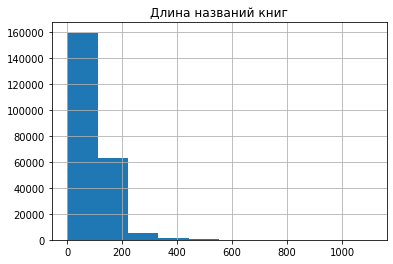

In [59]:
# Добавляем столбец с длиной названий
df_ML['title_length'] = df_ML['title_clear'].str.len()
df_ML.title_length.hist()
plt.title("Длина названий книг")
plt.show()

- Есть пустышки..А есть и мини-эссе на 800 символов!

- Пока не удаляем из общего датасета, главное, выработать общий подход

In [60]:
print("Оочень короткие названия:")
df_ML[df_ML['title_length']  < 5][['title', 'title_clear']]

Оочень короткие названия:


,title,title_clear
10066,S/Z,sz
14170,Сыр,сыр
14812,Пир,пир
18208,Сид,сид
23587,Пир,пир
27116,1937,
29860,Еда,еда
31141,Т. 1,т
42883,Мать,мать
47725,Роза,роза


- Добавим еще сокращенный вариант названий

In [61]:
df_ML['title_short'] = df_ML['title_clear'].str[0 : 100]
df_ML['title_short_300'] = df_ML['title_clear'].str[0 : 300]

df_ML.sort_values(by='title_length')['title_short'].values

array(['', ' ', ' ', ...,
       'искусство повивания или наука о бабичьем деле на пят частей разделенная и многими рисунками снабденн',
       'искусство повивания или наука о бабичьем деле на пят частей разделенная и многими рисунками снабденн',
       'секретный эконом художник ремесленник заводчик и домашний врач иждивением изаикина ч содержащая в се'],
      dtype=object)

**Вывод**

- Мы подготовили текст, удалив лишние символы, и оставив слова

- Теперь можно проводить эксперименты с леммами и искать похожие названия

##### Удаляем stop-слова

In [62]:
# Расширим название в сокращенной версиии
df_ML['title_no_stop']= df_ML['title_clear'].str[0 : 300]
df_ML.sort_values(by='title_length')['title_no_stop'].values

array(['', ' ', ' ', ...,
       'искусство повивания или наука о бабичьем деле на пят частей разделенная и многими рисунками снабденная в коей кратко но ясно толкуется какое детородныя женские части имеют строение коим образом надлежит пособлять беременным при родах роженицам после родов и новорожденным их младенцам во время младол',
       'искусство повивания или наука о бабичьем деле на пят частей разделенная и многими рисунками снабденная в коей кратко но ясно толкуется какое детородныя женские части имеют строение коим образом надлежит пособлять беременным при родах роженицам после родов и новорожденным их младенцам во время младол',
       'секретный эконом художник ремесленник заводчик и домашний врач иждивением изаикина ч содержащая в себе секреты искусственнаго составления драгоценных камней жемчугу черепаховой кости и проч составления сохранения от порчи золочения и серебрения различных металлов приготовления различнашго рода черни'],
      dtype=object)

In [63]:
# Как выглядят токены-слова
df_ML['title_300_tokens'] = df_ML['title_no_stop'].apply(lambda x: x.split())
df_ML[['title_no_stop', 'title_300_tokens']]

,title_no_stop,title_300_tokens
0,антропонимы в киргизском героическом эпосе ман...,"[антропонимы, в, киргизском, героическом, эпос..."
1,chlorella pyrenoidosa т как тестобъект в биоло...,"[chlorella, pyrenoidosa, т, как, тестобъект, в..."
2,айседора дункан и театральная культура эпохи м...,"[айседора, дункан, и, театральная, культура, э..."
3,записки а и кошелева как памятник отечественно...,"[записки, а, и, кошелева, как, памятник, отече..."
4,аграрная буржуазия в политической жизни индии ...,"[аграрная, буржуазия, в, политической, жизни, ..."
...,...,...
228997,отсутствует,[отсутствует]
228998,отсутствует,[отсутствует]
228999,отсутствует,[отсутствует]
229000,отсутствует,[отсутствует]


- Напишем функцию, чтобы удалить stop-слова, протестируем прямо на этом примере

- (!) часть решения взято со stackoverflow

In [64]:
test_text = "секретный эконом художник ремесленник заводчик и домашний врач иждивением изаикина ч содержащая в себе секреты искусственнаго составления драгоценных камней жемчугу черепаховой кости и проч составления сохранения от порчи золочения и серебрения различных металлов приготовления различнашго рода черни"
test_tokens = test_text.split()
test_tokens[0:5]

['секретный', 'эконом', 'художник', 'ремесленник', 'заводчик']

In [65]:
url_stopwords_ru = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt"

def get_text(url, encoding='utf-8', to_lower=True):
    url = str(url)
    if url.startswith('http'):
        r = requests.get(url)
        if not r.ok:
            r.raise_for_status()
        return r.text.lower() if to_lower else r.text
    elif os.path.exists(url):
        with open(url, encoding=encoding) as f:
            return f.read().lower() if to_lower else f.read()
    else:
        raise Exception('parameter [url] can be either URL or a filename')

def remove_stopwords(tokens, stopwords=None, min_length=4):
    if not stopwords:
        return tokens

    # stopwords = set(stopwords)
    # сокращенный список
    stopwords = nltk_stopwords.words('russian')

    tokens = [tok
              for tok in tokens
              if tok not in stopwords and len(tok) >= min_length]
    return tokens

def lemmatize_tokens(tokens):
    morph = pymorphy2.MorphAnalyzer()
    return [morph.parse(tok)[0].normal_form for tok in tokens]

def clear_and_lemmatize(text, stopwords=None, lemmatize=True):

    # Разделяем текст на токены
    words = [w for w in text.split()]

    if lemmatize:
        words = lemmatize_tokens(words)
    if stopwords:
        words = remove_stopwords(words, stopwords)

    # Возвращаем цельный текст без stop-слов или/и с леммами
    words = " ".join([word for word in words])
                     
    return words

stopwords_ru = get_text(url_stopwords_ru).splitlines()

words = clear_and_lemmatize("была такая война", stopwords=stopwords_ru, lemmatize=False)
words

'такая война'

- лишние слова удалились!

- если использовать полный список stop слов, то вместо такая война останется пропуск 

In [66]:
df_ML['title_no_stop'] = df_ML['title_no_stop'].apply(
    lambda x: clear_and_lemmatize(x,  stopwords=stopwords_ru, lemmatize=False))

In [67]:
# Проверим, как сработало удаление стоп слов
df_ML.iloc[415][['title_no_stop', 'title_clear']].values

array(['порядок слов связь интонацией русском языке сопоставлении китайским автореферат кандидата филологических наук',
       'порядок слов и его связь с интонацией в русском языке в сопоставлении с китайским автореферат дис кандидата филологических наук '],
      dtype=object)

In [68]:
# Сделаем то же самое с коротким названием, возможно, слишком длинное не потребуется
df_ML['title_short_no_stop'] = df_ML['title_short'].apply(
    lambda x: clear_and_lemmatize(x,  stopwords=stopwords_ru, lemmatize=False))

df_ML.iloc[415][['title_short_no_stop', 'title_clear', 'title_no_stop']].values

array(['порядок слов связь интонацией русском языке сопоставлении китайским автореферат',
       'порядок слов и его связь с интонацией в русском языке в сопоставлении с китайским автореферат дис кандидата филологических наук ',
       'порядок слов связь интонацией русском языке сопоставлении китайским автореферат кандидата филологических наук'],
      dtype=object)

**Вывод**

- Лишние слова удалились! Можно испытывать с tfidf!

##### Заменяем на леммы

- Добавим еще одну операцию, переведем слова в неизменяемую форму!

In [69]:
# df_ML['title_lemmatized']= df_ML['title_clear'].str[0 : 300]
# df_ML['title_lemmatized'] = df_ML['title_lemmatized'].apply(
    # lambda x: clear_and_lemmatize(x, stopwords=stopwords_ru, lemmatize=True))

In [70]:
# Проверим, как сработала лемматизация
# df_ML.iloc[415][['title_lemmatizied', 'title_no_stop']].values

#### Код BBK и жанры

##### Очистка данных

In [71]:
df_ML.bbk.sort_values()

52699                          \n
178158                         \n
186737                         \n
33704                          \n
94316                          \n
                   ...           
79658                      Я9(2Р)
35260                      Я9(2Р)
9729                       Я9(2Р)
88047     Я9(2Р)\nЧ721,6(2)261я43
96931                     Я9(4Вл)
Name: bbk, Length: 229002, dtype: object

- Еще NaN и \n - не хочется удалять эти книги, посмотрим, есть ли названия и авторы

In [72]:
df_ML[df_ML.bbk.isna()].head(5)

,chb,sys_numb,bbk,title,year_izd,author,year_2,author_ml,title_clear,title_length,title_short,title_short_300,title_no_stop,title_300_tokens,title_short_no_stop


- Пропуски и '\n' заполним нулями


In [73]:
# Заполним пропуски нулями
df_ML['bbk_ml'] = df_ML.bbk.fillna('0')

df_ML.loc[df_ML.bbk_ml.isin(['\n', '\n\n']), 'bbk_ml'] = '0' 
df_ML['bbk_ml'].sort_values().head(10)

145853                              \nВ341.4,0
143245                 \nД9(0)023,0\nР120.10,0
96457                            \nЗ811.3я73-1
177722                   \nЗ973.233-021.3я73-1
58829                \nР.д(2)Кассирский И.А.,0
170741                             \nР126я73-1
43361                              \nР357.4,07
43360                              \nР357.4,07
101231                  \nС555.51,0\nС555.37,0
175642    \nС555.57я431(2)\nЧ611.621с51я431(2)
Name: bbk_ml, dtype: object

Похоже, все коды разделены с помощью \n:

- Заменим разделители \n на пробелы
- Удалим пробелы по краям

In [74]:
# Заменяем '\n' в начале и середине bbk кодов на пробелы
df_ML['bbk_ml'] = df_ML['bbk_ml'].replace("\n", " ", regex=True)
df_ML['bbk_ml'].sort_values().head(10)

145853                              В341.4,0
143245                  Д9(0)023,0 Р120.10,0
96457                            З811.3я73-1
177722                   З973.233-021.3я73-1
58829                Р.д(2)Кассирский И.А.,0
170741                             Р126я73-1
43361                              Р357.4,07
43360                              Р357.4,07
101231                   С555.51,0 С555.37,0
175642     С555.57я431(2) Ч611.621с51я431(2)
Name: bbk_ml, dtype: object

In [75]:
# Проверяем пробелы в начале кодов bbk
df_ML['bbk_ml'].replace(" ", "-", regex=True).sort_values().head(10)

145853                             -В341.4,0
143245                 -Д9(0)023,0-Р120.10,0
96457                           -З811.3я73-1
177722                  -З973.233-021.3я73-1
58829               -Р.д(2)Кассирский-И.А.,0
170741                            -Р126я73-1
43361                             -Р357.4,07
43360                             -Р357.4,07
101231                  -С555.51,0-С555.37,0
175642    -С555.57я431(2)-Ч611.621с51я431(2)
Name: bbk_ml, dtype: object

In [76]:
# Удаляем лишние пробелы в начале
df_ML['bbk_ml'] = df_ML['bbk_ml'].str.strip()

# Проверяем, что все сработало
df_ML['bbk_ml'].replace(" ", "-", regex=True).loc[175642]

'С555.57я431(2)-Ч611.621с51я431(2)'

**Вывод**

1. Мы заменили пропуски и '\n', '\n\n' на '0' (остальные коды выглядят корректно)

2. Убрали разделители '\n':

  - теперь bbk-код можно лего разделить на готовые блоки в TF-IDF! 
  - блоки bbk можно использовать для поиска различных вариаций жанров

##### Сокращенный bbk - для широкого поиска

- Посмотрим на разные варианты и подберем регулярное выражение для сокращенного кода bbk

In [77]:
print("Сложные bbk коды, состоящие из нескольких блоков:")
df_ML[df_ML['bbk_ml'].str.contains(' ')].bbk_ml.head(20)

Сложные bbk коды, состоящие из нескольких блоков:


0                        Ш3(257=Ки)-611,0 Ш163.25-314,0
4                       Т3(5Ид)63-283,02 Т3(5Ид)63-5,02
6     Ш5(2=Р)43-318.3,0 Ш5(2=Р)51-318.3,0 Ш5(0)32-31...
8                          Ш401.171.11,0 Ш5(5Вл)42-35,0
12            Т52(241=А)-417,02 Т594.171.3,02 М772.02,0
13            Т52(241=А)-417,02 Т594.171.3,02 М772.02,0
16       Щ143(2Р=Р)52-8Куинджи А.И.41,0 Щ147.63(2Р=Р),0
18         Т3(53)63-608,014.1 Ч612.4(5Ли)713.1Ан-Нида,0
19                            Щ10г(2)75,0 Щ103(2)75-4,0
20                             Е581.4,0 Е585.9(2Р345),0
23                                   Р343.39,0 Р364.7,0
24               Ш5(2=Р)51-4ПушкинА.С.535,0 Ш141.2-32,0
25                          Н822.207,0 Н712.815-022.5,0
27                             Ш147.11-77,0 Ш141.2-77,0
28                      Ш143.21-212.8,0 Ш143.21-227.4,0
30                           Ш161.131-70,0 Ш161.131-5,0
31                             Ш141.2-221,0 Ш141.2-32,0
35                   Ш151-32,0 Ш143.21-32,0 Ш141

- Попробуем выделить самый первый код, который отвечает за тематику

- Это код из заглавной буквы и последовательности цифр до первого символа "(" или "-" или "." 

In [78]:
df_ML['bbk_top'] = df_ML['bbk_ml'].str.extract(r'(\w\d*)')
df_ML[df_ML['bbk_ml'].str.contains('\n')][['bbk_ml', 'bbk_top']]

,bbk_ml,bbk_top


- Посмотрим, сколько книг у нас получилось для каждого жанра

In [79]:
print("Самые популярные жанры книг в библиотеке:")
df_ML['bbk_top'].value_counts().head(15)

Самые популярные жанры книг в библиотеке:


u       85148
Т3      15063
Ш5      11175
У9       6985
Х629     3978
С555     2624
Х628     2559
Х623     2480
Ш141     2369
Э372     2047
Х621     2010
С556     1759
Ю3       1755
Н0       1465
Щ143     1417
Name: bbk_top, dtype: int64

Самый популярный жанр - теория заговора?)) ТЗ - это история=)

  - На 2-м месте книги для филологов - мировая литература))

  - На 3-м  почетном экономика)

-На 15-м история изобразительного искусства

In [80]:
df_ML['bbk_top'].value_counts().describe()

count     2541.000000
mean        90.122786
std       1743.601303
min          1.000000
25%          2.000000
50%          5.000000
75%         19.000000
max      85148.000000
Name: bbk_top, dtype: float64

**Вывод**

1. Обучать модель можно будет и по полному коду `bbk_ml`, и по начальному `bbk_top`

  - начальный код отражает основную тему в классификационной системе
  - получили его с помощью парсинга

3. Узнали о самых популярных жанрах книг среди читателей:)

3. Все коды bbk можно посмотреть здесь https://lod.rsl.ru/bbkgsk/concepts/%D0%AE9


##### Возможности для TF-IDF

In [ ]:
print("Уникальных кодов bbk:", df_ML.bbk_ml.nunique())
print("Сокращенных кодов bbk:", df_ML.bbk_top.nunique())

1. Сокращенные коды будет удобнее использовать для классификации - их всего 2540

2. Чтобы найти специфичную тему нужен более детальный bbk-код

3. 79080  кодов:
  -  почти столько же, сколько и книг (не подойдет для обобщения)
  -  слишком много признаков
---
Решение:

- Закодировать bbk блоками TF-IDF(должно быть много похожих единиц в датасете)


In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf =  tfidf_vectorizer.fit_transform(df_ML['bbk_ml'])
tfidf

**Вывод**

- Сработало! 27 000 против 79 000, уже хорошая оптимизация!

- Можно также попробовать использовать для более узкой классификации только первый блок

### Алгоритм поиска похожих книг




Посмотрим, какие результаты мы можем получить в поиске похожих названий:

- нужно максимально сократить наши длинные тексты
- выявить наиболее ключевые слова для поиска

Как только доведем до рабочего варианта, будем двигаться дальше

#### По названию





Попробуем искать книги (!) только по названиям (`title`):

- Переведем все наши названия в векторы 

- Текст оставляем как есть (с полным набором слов и выражений)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=20000)
tfidf =  tfidf_vectorizer.fit_transform(df_ML['title_clear'])
tfidf

- Возьмем произвольную книгу из датасета 

- И попробуем найти книги с похожим названием))

In [ ]:
book_title = df_ML.sample(1, random_state=777).title_clear.values[0]
book_title

- Музыка - моя любимая тема! Вот так сюрприз) 

- На первый взгляд специфичная книга, интересно, что сможет найти наш алгоритм в  качестве рекомендации)

In [ ]:
book_vector = tfidf_vectorizer.transform([book_title])
book_vector

- 12 закодированных элементов 0 и 1 = 12 слов

- Можно начинать поиск!

In [ ]:
# Функция flatten для получения одномерного массива вместо 2D
book_similarities = cosine_similarity(book_vector, tfidf).flatten()

print(book_similarities)

- Единица  д.б. у исходника - книги, которую мы выбрали 

- Найдем индексы 6 самых похожих книг (с самым большим similarity)


In [ ]:
similar_books_id = np.argpartition(book_similarities, -6)[-6:]
print("список похожих книг:")
df_ML.iloc[similar_books_id]

- Под индексом 160955 прячется наша книга

- Сколько еще книг про музыкальные инструменты (есть и 2008, и старые издания 1975)

Хороший поиск! Посмотрим еще какую-нибудь книгу=)

In [ ]:
book_title = df_ML.sample(1, random_state=555).title_clear.values[0]
book_title

- Интересное попадание:) Тайны Египта)

In [ ]:
# Переводим в вектор
book_vector = tfidf_vectorizer.transform([book_title])

# Получаем матрицу с похожими названиями
book_similarities = cosine_similarity(book_vector, tfidf).flatten()
similar_books_id = np.argpartition(book_similarities, -6)[-6:]

print("список похожих книг:")
df_ML.iloc[similar_books_id]

- Московское царство немного подкачало=) Но остальные варианты вполне хороши)

- Возьмем еще один из длинных текстов

In [ ]:
# Берем рандомную книгу с очень длинным названием
book_title = df_ML[df_ML.title_length > 300].sample(1, random_state=123).title_clear.values[0]
print(book_title)

# Переводим в вектор
book_vector = tfidf_vectorizer.transform([book_title])

# Получаем матрицу с похожими названиями
book_similarities = cosine_similarity(book_vector, tfidf).flatten()
similar_books_id = np.argpartition(book_similarities, -6)[-6:]

print("список похожих книг:")
df_ML.iloc[similar_books_id]  

- Отлично!

- Подберем такой набор для каждой книги (это нам пригодится, когда будем готовить рекомендации для каждого пользователя)

**Вывод**

1. Без дополнительной обработки текста мы уже получили неплохие `рекомендации` по названиям` книг

  - "+"  Читатель может открыть для себя новые книги и авторов
  - "+"  Можно использовать для разовых запросов читателей
  - "-"  Очень большое количество признаков
  - "-"  Без оптимизации подхода мы не сможем использовать названия для "попарного" поиска похожих книг в библиотеке.

2. Возможности для улучшения:
  - Сократить длину описаний для обучения
  - Отсеять "stop"-слова 
  - Использовать SVD для сокращения количества признаков
  - Перевести в леммы (сейчас "Марсиане" и "Марсианские" будут давать разные результаты)




#### По жанру




1. Попробуем найти похожие книги по жанру!

  - Есть идея не кодировать полный bbk, а применить к нему TF-IDF 

2. Сокращеннный bbk_top должен дать большой широкий выбор в тематике книг)

  - Проверим оба варианта!


Интересно, что получится:)


In [91]:
# Находим рандомную книгу
random_book = df_ML.sample(1, random_state=51)
display(random_book)


,chb,sys_numb,bbk,title,year_izd,author,year_2,author_ml,title_clear,title_length,title_short,title_no_stop,title_300_tokens,bbk_ml,bbk_top
13326,300001039550,RSL01000868924,Т3(41)6я43,Северная Европа. Проблемы новейшей истории : с...,1995,none,1995,none,северная европа проблемы новейшей истории сбор...,125,северная европа проблемы новейшей истории сбор...,северная европа проблемы новейшей истории сбор...,"[северная, европа, проблемы, новейшей, истории...",Т3(41)6я43,Т3


- Ясновидение, это что-то новенькое!

In [89]:
df_ML.loc[115909].bbk_ml


'Э391.229,0'

In [86]:
def test_tf_idf_recommender(df, features_col, search_item, top_count, max_features=100000):

  """
  Создает TF-IDF Vectorizer для features_col и выводит ТОP похожих книг
  """

  # Переводим все признаки df[features_col] в набор векторов tfidf
  tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
  tfidf =  tfidf_vectorizer.fit_transform(df[features_col])
  tfidf

  # Генерируем вектор для search_item
  book_vector = tfidf_vectorizer.transform(search_item)

  # Создаем матрицу с расстояниями до признака search_item
  book_similarities = cosine_similarity(book_vector, 
                                        tfidf).flatten()

  # Получаем индексы книг самыми похожими признаками
  similar_books_id = np.argpartition(book_similarities,
                                     top_count*(-1))[top_count*(-1):]
   
  # Печатаем размер tfidf матрицы
  display(tfidf)

  # Выводим описания TOP похожих книг
  display(df.iloc[similar_books_id]) 


In [90]:
# Рекомендации на СОКРАЩЕННЫХ кодах bbk
print("Рекомендации по жанру для 'Практика развития ясновидения'")
test_tf_idf_recommender(df_ML, 'bbk_ml', 
                        'Э391.229,0', 
                        top_count=6)

Рекомендации по жанру для 'Практика развития ясновидения'


ValueError: ignored

**Вывод 1**

Действительно, мы получили книги из различной **эзотерической литературы**

1. Такой подход интересен, т.к. читатель точно найдет `что-то новое`!

2. Для ранжирования удобно, когда также есть `рейтинг пользователей` 
  - тогда мы могли бы дать список из самых популярных книг

Теперь посмотрим, что будет, если взять для сравнения полный bbk-код

In [94]:
# Рекомендации на ПОЛНЫХ кодах bbk
print("Рекомендации по жанру для 'Практика развития ясновидения'")
test_tf_idf_recommender(df_ML, 'bbk_ml', 
                        random_book['bbk_ml'].values, 
                        top_count=6)

Рекомендации по жанру для 'Практика развития ясновидения'


<229002x27014 sparse matrix of type '<class 'numpy.float64'>'
	with 594713 stored elements in Compressed Sparse Row format>

,chb,sys_numb,bbk,title,year_izd,author,year_2,author_ml,title_clear,title_length,title_short,title_no_stop,title_300_tokens,bbk_ml,bbk_top
43836,300000777623,RSL01002716520,Т3(0)0-6я43,Исследования международных отношений : сб. ст.,2004,none,2004,none,исследования международных отношений сб ст,42,исследования международных отношений сб ст,исследования международных отношений,"[исследования, международных, отношений, сб, ст]",Т3(0)0-6я43,Т3
55849,100001144527,RSL01003050185,Т3(2)0-6я43,Россия и Европа = Russia and Europe : дипломат...,2007,none,2007,none,россия и европа russia and europe дипломатия и...,133,россия и европа russia and europe дипломатия и...,европа russia europe дипломатия культура акад ...,"[россия, и, европа, russia, and, europe, дипло...",Т3(2)0-6я43,Т3
37457,300000913764,RSL01002476635,Т3(0)5-6я43\nТ3(0)6-6я43,Проблемы истории международных отношений в нов...,2004,none,2004,none,проблемы истории международных отношений в нов...,119,проблемы истории международных отношений в нов...,проблемы истории международных отношений новое...,"[проблемы, истории, международных, отношений, ...",Т3(0)5-6я43 Т3(0)6-6я43,Т3
13326,300001039550,RSL01000868924,Т3(41)6я43,Северная Европа. Проблемы новейшей истории : с...,1995,none,1995,none,северная европа проблемы новейшей истории сбор...,125,северная европа проблемы новейшей истории сбор...,северная европа проблемы новейшей истории сбор...,"[северная, европа, проблемы, новейшей, истории...",Т3(41)6я43,Т3
6645,300001110352,RSL01000625674,Т3(41)6я43,Северная Европа. Проблемы новейшей истории : с...,1999,none,1999,none,северная европа проблемы новейшей истории сбор...,125,северная европа проблемы новейшей истории сбор...,северная европа проблемы новейшей истории сбор...,"[северная, европа, проблемы, новейшей, истории...",Т3(41)6я43,Т3
144470,200001063393,RSL01007885200,Т3(0)6я43,"Большая Европа : идеи, реальность, перспективы",2014,none,2014,none,большая европа идеи реальность перспективы,42,большая европа идеи реальность перспективы,большая европа идеи реальность перспективы,"[большая, европа, идеи, реальность, перспективы]",Т3(0)6я43,Т3


**Вывод 2**

Классно! Очень крутая подборка получилась)

1. Если брать полный bbk + TFIDF
  - получаем интересные подборки по конкретной тематике:)

2. Задача нашей системы найти для читателя неожиданные книги, которые понравятся)
  - такой подход не может улучшить нашу метрику на предсказаниях (т.к. мы предсказываем не рейтинг, а факт выдачи книг)
  - зато мы построим систему с хорошими рекомендациями!

3. "+" В дополнение мы сразу нашли `новых пользователей` по интересам!

Возможности для развития - в TFIDF разделить bbk на несколько блоков, тогда можно комбинировать подходы и находить еще более интересные варианты рекомендаций)

#### По автору и жанру



Объединим для поиска авторов и жанры:

- протестируем подход с полным bbk
- с top bbk (только широкая классификация)

In [95]:
df_ML['author_bbk'] = df_ML['bbk_ml'].astype('string') + " " + df_ML['author_ml']
df_ML['author_bbk']

0         Ш3(257=Ки)-611,0 Ш163.25-314,0 Боронов Адина А...
1                     Е591.21с,0 Дедов Александр Викторович
2         Щ327.75(7США)-86ДунканА.0,0 Добротворская Кари...
3         Ш5(2=Р)52-4КошелевА.И.534,0 Летягин Лев Никола...
4         Т3(5Ид)63-283,02 Т3(5Ид)63-5,02 Литвин Алексей...
                                ...                        
228997                                  unknown отсутствует
228998                                  unknown отсутствует
228999                                  unknown отсутствует
229000                                  unknown отсутствует
229001                                  unknown отсутствует
Name: author_bbk, Length: 229002, dtype: string

- На поиск "Принцесса на горошине" вышла книга, написанная самой Дианой Уэльской

- Попробуем найти похожие книги

In [96]:
test_tf_idf_recommender(df_ML, 'author_bbk', 
                        [df_ML.loc[112657]['author_bbk']], 
                        top_count=3)

<229002x89025 sparse matrix of type '<class 'numpy.float64'>'
	with 1139026 stored elements in Compressed Sparse Row format>

,chb,sys_numb,bbk,title,year_izd,author,year_2,author_ml,title_clear,title_length,title_short,title_no_stop,title_300_tokens,bbk_ml,bbk_top,author_bbk
99190,300000939151,RSL01004855601,"Т3(4Вл)511.9-8Карл I,02",Образы Карла I Стюарта в политической полемике...,2011,"Кирьянова, Елена Анатольевна",2011,Кирьянова Елена Анатольевна,образы карла i стюарта в политической полемике...,131,образы карла i стюарта в политической полемике...,образы карла стюарта политической полемике нач...,"[образы, карла, i, стюарта, в, политической, п...","Т3(4Вл)511.9-8Карл I,02",Т3,"Т3(4Вл)511.9-8Карл I,02 Кирьянова Елена Анатол..."
139364,300000974405,RSL01007547124,\n,"Принцесса Диана. Жизнь, рассказанная ею самой ...",2014,Диана принцесса Уэльская 1961-1997,2014,Диана принцесса Уэльская,принцесса диана жизнь рассказанная ею самой,44,принцесса диана жизнь рассказанная ею самой,принцесса диана рассказанная,"[принцесса, диана, жизнь, рассказанная, ею, са...",0,0,0 Диана принцесса Уэльская
112657,300000974405,RSL01005432559,"Т3(4Вл)63-8Карл Уэльский21,013.1","Принцесса Диана. Жизнь, рассказанная ею самой",2012,Диана принцесса Уэльская 1961-1997,2012,Диана принцесса Уэльская,принцесса диана жизнь рассказанная ею самой,44,принцесса диана жизнь рассказанная ею самой,принцесса диана рассказанная,"[принцесса, диана, жизнь, рассказанная, ею, са...","Т3(4Вл)63-8Карл Уэльский21,013.1",Т3,"Т3(4Вл)63-8Карл Уэльский21,013.1 Диана принцес..."


**Вывод1**

1.  Поиск работает хорошо, но 72 000 признаков -  это очень много 

2. Две книги с похожим названием, но разными идентификаторами! Потому что разный год издания!!

  - Проверим в следующем, есть ли еще такие явные дубликаты в датасете

Попробуем теперь сокращенный вариант bbk.

In [97]:
df_ML['author_bbk'] = df_ML['bbk_top'].astype('string') + " " + df_ML['author_ml']
df_ML['author_bbk']

0                   Ш3 Боронов Адина Айылчиевич
1               Е591 Дедов Александр Викторович
2         Щ327 Добротворская Карина Анатольевна
3                     Ш5 Летягин Лев Николаевич
4                  Т3 Литвин Алексей Васильевич
                          ...                  
228997                            u отсутствует
228998                            u отсутствует
228999                            u отсутствует
229000                            u отсутствует
229001                            u отсутствует
Name: author_bbk, Length: 229002, dtype: string

- На поиск "Принцесса на горошине" вышла книга, написанная самой Дианой Уэльской

- Попробуем найти похожие книги

In [98]:
test_tf_idf_recommender(df_ML, 'author_bbk', 
                        [df_ML.loc[112657]['author_bbk']], 
                        top_count=3)

<229002x66250 sparse matrix of type '<class 'numpy.float64'>'
	with 686639 stored elements in Compressed Sparse Row format>

,chb,sys_numb,bbk,title,year_izd,author,year_2,author_ml,title_clear,title_length,title_short,title_no_stop,title_300_tokens,bbk_ml,bbk_top,author_bbk
50471,200001049489,RSL01002908021,"Т3(2)522.9-484.27,02\nФ69(2)421.7,0",Всероссийский крестьянский союз в 1905-1907 гг.,2006,"Колесниченко, Диана Алексеевна",2006,Колесниченко Диана Алексеевна,всероссийский крестьянский союз в гг,36,всероссийский крестьянский союз в гг,всероссийский крестьянский союз,"[всероссийский, крестьянский, союз, в, гг]","Т3(2)522.9-484.27,02 Ф69(2)421.7,0",Т3,Т3 Колесниченко Диана Алексеевна
139364,300000974405,RSL01007547124,\n,"Принцесса Диана. Жизнь, рассказанная ею самой ...",2014,Диана принцесса Уэльская 1961-1997,2014,Диана принцесса Уэльская,принцесса диана жизнь рассказанная ею самой,44,принцесса диана жизнь рассказанная ею самой,принцесса диана рассказанная,"[принцесса, диана, жизнь, рассказанная, ею, са...",0,0,0 Диана принцесса Уэльская
112657,300000974405,RSL01005432559,"Т3(4Вл)63-8Карл Уэльский21,013.1","Принцесса Диана. Жизнь, рассказанная ею самой",2012,Диана принцесса Уэльская 1961-1997,2012,Диана принцесса Уэльская,принцесса диана жизнь рассказанная ею самой,44,принцесса диана жизнь рассказанная ею самой,принцесса диана рассказанная,"[принцесса, диана, жизнь, рассказанная, ею, са...","Т3(4Вл)63-8Карл Уэльский21,013.1",Т3,Т3 Диана принцесса Уэльская


- 49 000 признаков, уже лучше!

**Вывод 2**

1. Мы реализовали подход к поиску похожих книг по автору и жанру:

  - будет находить похожие книги (из одного сборника или серии)

2. Использование сокращенного bbk:
  -  дает такие же результаты
  -  признаков почти в 2 раза меньше! 

3. Есть плюсы и минусы:

- "+" - здесь потребуется меньше признаков, чем с поиском по названиям
- "+" - сможем использовать для улучшения качества предсказаний
---
- "-" - читатель, скорее всего, не откроет для себя новых авторов


## ЭТАП 6. HYBRID-Рекомендательная система

#### (6.1) Проблематика

Для одной книги легко найти похожие, но у нас 9000 пользователей и 188 000 уникальных книг!

В системе рекомендаций потребуется более `оптимальный подход`:

- сократить набор признаков для вычисления расстояний cousine similarity

- придумать, как мы будем подбирать похожие книги для **набора из 3-200 книг**, которые уже прочитал пользователь:)

- выбрать подход к ранжированию (сложность в том, что у нас нет рейтингов, а в наборе может быть до 200 книг - как делать для них рекомендации?)

#### Вычисление similarities



##### Датафрейм с книгами для обучения

In [8]:
# Датасет с набором книг из транзакций, из которого будем подбирать рекомендации
items_ML = (df_ML[['sys_numb', 'bbk_ml', 'title_clear', 'bbk_top', 'author_ml', 
                   'title_short', 'title_no_stop', 'title_short_no_stop']]
            .drop_duplicates()
            .reset_index(drop=True))

print("Количество книг для content-based рекомендаций:", items_ML.shape[0])

NameError: ignored

In [247]:
# Сохраняем датафрейм для обучения
items_ML.to_csv("items_ML.csv", index=False)

In [25]:
# Загружаем датафрейм для экспериментов
items_ML = pd.read_csv("items_ML.csv")

In [26]:
# Посмотрим, где выйдут пропуски - книги без названий
items_ML[items_ML.title_no_stop.isna()]

,sys_numb,bbk_ml,title_clear,bbk_top,author_ml,title_short,title_no_stop,title_short_no_stop
5963,RSL01000626391,"Т3(4Ф)64-05,013.1 Т3(2)74-8ГорбачевМ.С.20,013.1",как это было,Т3,Горбачев Михаил Сергеевич,как это было,NaN,NaN
8660,RSL01000699019,Ю3(4Фр)6-664БартР.-06,sz,Ю3,Барт Ролан,sz,NaN,NaN
12006,RSL01000955918,Л958я20 Л992.8я27,сыр,Л958,Петухова Елена Юрьевна,сыр,NaN,NaN
12547,RSL01000970071,Ш5(2=Р)75-644,пир,Ш5,Сорокин Владимир Георгиевич,пир,NaN,NaN
15519,RSL01001337100,unknown,сид,u,Корнель Пьер,сид,NaN,NaN
...,...,...,...,...,...,...,...,...
167551,RSL01010319897,"Э38-422.27,0",рай и ад,Э38,альАшкар Умар Сулейман,рай и ад,NaN,NaN
169922,RSL01010424386,Ш5(2=Р)64-644,другой юг,Ш5,Абдуллаев Шамшад,другой юг,NaN,NaN
172489,RSL01010538496,Р282.11я9,дар и я,Р282,Солнышко,дар и я,NaN,NaN
173178,RSL01010564698,"Д8г(5Ту)42,0 Д890(0),0",,Д8,,,NaN,NaN


In [27]:
items_ML = items_ML.fillna("")

- Всего 62, но рай и сыр не попали - т.к. мы удалили слова из 3 букв

##### Новый подход - оптимизация ресурсов

Попробуем сразу вычислить попарные "расстояния" для всех книг по авторам.

- тогда мы сможем пользоваться готовой матрицей при подборе рекомендаций для **набора книг**

Сколько времени это займет?

- Ограничим количество признаков в TF-IDF до 15 000

In [354]:
# items_ML['bbk_author'] = items_ML['bbk_ml'].astype('string') + " " + items_ML['author_ml']

# Создаем матрицу TF-IDF для векторизации книг по жанрам
tfidf_vectorizer = TfidfVectorizer()
tfidf =  tfidf_vectorizer.fit_transform(items_ML['bbk_ML'])
tfidf

KeyError: ignored

In [113]:
tfidf_vectorizer.vocabulary_

{'автореферат': 77,
 'дис': 502,
 'кандидата': 875,
 'филологических': 2742,
 'наук': 1363,
 'как': 868,
 'биологических': 187,
 'культура': 1045,
 'эпохи': 2943,
 'модерна': 1251,
 'искусствоведения': 811,
 'записки': 659,
 'отечественной': 1578,
 'литературы': 1098,
 'филол': 2741,
 'политической': 1711,
 'жизни': 622,
 'индии': 749,
 'истор': 830,
 'сети': 2217,
 'типология': 2572,
 'программы': 1872,
 'русской': 2135,
 'литературе': 1090,
 'конца': 1000,
 'xix': 53,
 'века': 233,
 'адаптация': 81,
 'государственного': 412,
 'регулирования': 2036,
 'социальноэкономического': 2339,
 'развития': 1983,
 'субъекта': 2469,
 'федерации': 2723,
 'английской': 122,
 'средних': 2404,
 'веков': 236,
 'доктора': 540,
 'акты': 99,
 'гражданского': 427,
 'состояния': 2324,
 'источник': 847,
 'по': 1668,
 'среднего': 2401,
 'урала': 2649,
 'гг': 370,
 'анализ': 112,
 'медицинских': 1167,
 'творчестве': 2518,
 'ii': 16,
 'пол': 1699,
 'нач': 1389,
 'xx': 62,
 'вв': 228,
 'информационных': 801,
 'з

In [75]:
# from sklearn.metrics.pairwise import linear_kernel
# book_similarities = linear_kernel(tfidf, tfidf)

Проблема:

- Это удобный подход для учебных демонстраций и небольшого количества признаков, но не для 200 000 книг!

- Оперативная память не выдерживает таких объемов, а если использовать цикл с cosine similarities, он зависает на вечность
---
Решение:

Попробуем воспользоваться перемножением матриц и форматом Compressed Sparse Column! 

In [76]:
def fast_cosine_similarities(sparse_matrix, axis_type=1):

  # матрица mxn
  # m - объекты, n - признаки
  # нормализуем все строки или столбцы, в зависимости от axis
  csc_matrix = pp.normalize(sparse_matrix.tocsc(), axis=axis_type)
   
  transposed = csc_matrix.T
  # расстояния между объектами-строками 
  # матрица mxm
  if axis_type == 1:
    return csc_matrix * transposed
  # расстояния между признаками-столбцами
  # матрица nxn
  else:    
    return transposed * csc_matrix

# sim_matrix = fast_cosine_similarities(tfidf, axis_type=1)
# sim_matrix

<119805x119805 sparse matrix of type '<class 'numpy.float64'>'
	with 676185021 stored elements in Compressed Sparse Row format>

- Супер! Все быстро посчитано за секунды!

**Вывод**

1. Перемножение матриц - отличное решение для рассчета расстояний!

2. Конечно, оперативку мы все-таки загрузили  ~9ГБ, НО!

  - работает, и в тысячи раз быстрее чем cousine_similarity или linear_kernel
  - можно попробовать сохранять на диск, а в оперативку загружать уже построчно или чанками.

Сравним теперь результаты вычислений с поиском с помощью cosine_similarity.
Очень надеемся, что они совпадут, и можно будет использовать для рекомендаций)


##### Корректность результатов

- Индексы в TF-IDF соответствуют индексам в датафрейме с книгами, который мы преобразовывали в векторы

- Найдем индекс для той самой книги  "с ясновидением"

In [77]:
items_ML[items_ML['sys_numb']== "RSL01005529118"]

,sys_numb,bbk_ml,title_clear,bbk_top,author_ml,title_short,bbk_author
61744,RSL01005529118,"Э391.229,0",практика развития ясновидения,Э391,Муратова Ольга,практика развития ясновидения,"Э391.229,0 Муратова Ольга"


In [78]:
 # Переводим в np array строку с расстояниями до других items
item_similarities  = sim_matrix[61744, :].toarray()
display(item_similarities)

# flatten - для перевода из 2D в 1D
item_similarities = item_similarities.flatten()
display(item_similarities)

array([[0., 0., 0., ..., 0., 0., 0.]])

array([0., 0., 0., ..., 0., 0., 0.])

In [79]:
 # Получаем индексы 6 самых похожих items
similar_books_id = np.argpartition(item_similarities, -6)[-6:]
similar_books_id

array([ 57281,  61744,  74072, 100529, 109522,  90143])

Проверим результаты поиска обоих методов!
- с заранее сгенерированной матрицей с новым подходом
- с cosine_similarity 

In [80]:
items_ML.iloc[similar_books_id]

,sys_numb,bbk_ml,title_clear,bbk_top,author_ml,title_short,bbk_author
57281,RSL01005064741,"Э391.229,0",сибирский ковчег тайна спасения человечества,Э391,Речкин Михаил Николаевич,сибирский ковчег тайна спасения человечества,"Э391.229,0 Речкин Михаил Николаевич"
61744,RSL01005529118,"Э391.229,0",практика развития ясновидения,Э391,Муратова Ольга,практика развития ясновидения,"Э391.229,0 Муратова Ольга"
74072,RSL01007521658,"Э391.229,0",ванга величайшая пророчица хх века,Э391,Соколов Борис Вадимович,ванга величайшая пророчица хх века,"Э391.229,0 Соколов Борис Вадимович"
100529,RSL01009933485,"Э391.229,0",откровения ангеловхранителей секреты ватикана ...,Э391,Гарифзянов Ренат Ильдарович,откровения ангеловхранителей секреты ватикана ...,"Э391.229,0 Гарифзянов Ренат Ильдарович"
109522,RSL01010364988,"Э391.229,0",большая книга магической силы развитие интуици...,Э391,Моносов Борис Моисеевич,большая книга магической силы развитие интуици...,"Э391.229,0 Моносов Борис Моисеевич"
90143,RSL01008926039,"Э391.229,0",портал пророчеств василий василльев пророчеств...,Э391,Василльев Василий,портал пророчеств василий василльев пророчеств...,"Э391.229,0 Василльев Василий"


- А какие рекомендации мы получали раньше?

In [81]:
print("Рекомендации по жанру для 'Практика развития ясновидения'")
test_tf_idf_recommender(df_ML, 'bbk_ml', 
                        random_book['bbk_ml'], 
                        top_count=6)

Рекомендации по жанру для 'Практика развития ясновидения'


<143903x27013 sparse matrix of type '<class 'numpy.float64'>'
	with 509565 stored elements in Compressed Sparse Row format>

,chb,sys_numb,bbk,title,year_izd,author,year_2,author_ml,title_clear,title_length,title_short,bbk_ml,bbk_top,author_bbk
126761,300001057484,RSL01006638467,"Э391.229,0",Вы - ясновидящий! Как открыть третий глаз,2013,"Муратова, Ольга Николаевна",2013,Муратова Ольга Николаевна,вы ясновидящий как открыть третий глаз,39,вы ясновидящий как открыть третий глаз,"Э391.229,0",Э391,Э391 Муратова Ольга Николаевна
124278,300001090509,RSL01006550496,"Э391.229,0",Тайны великих предсказаний : 16+,2013,"Кубеев, Михаил Николаевич",2013,Кубеев Михаил Николаевич,тайны великих предсказаний,27,тайны великих предсказаний,"Э391.229,0",Э391,Э391 Кубеев Михаил Николаевич
129210,200001137590,RSL01006712261,"Э391.229,0",Сто великих предсказаний : 12+,2014,none,2014,none,сто великих предсказаний,25,сто великих предсказаний,"Э391.229,0",Э391,Э391 none
103293,200000789223,RSL01004984544,"Э391.229,0","Пророчества о войнах и катаклизмах. Россия, Ли...",2011,"Симонов, Виталий Александрович",2011,Симонов Виталий Александрович,пророчества о войнах и катаклизмах россия ливи...,67,пророчества о войнах и катаклизмах россия ливи...,"Э391.229,0",Э391,Э391 Симонов Виталий Александрович
105655,200000789223,RSL01005064741,"Э391.229,0",Сибирский ковчег : тайна спасения человечества,2011,"Речкин, Михаил Николаевич",2011,Речкин Михаил Николаевич,сибирский ковчег тайна спасения человечества,44,сибирский ковчег тайна спасения человечества,"Э391.229,0",Э391,Э391 Речкин Михаил Николаевич
166934,200000789223,RSL01008926039,"Э391.229,0",Портал Пророчеств / Василий Василльев : Пророч...,2017,"Василльев, Василий",2017,Василльев Василий,портал пророчеств василий василльев пророчеств...,102,портал пророчеств василий василльев пророчеств...,"Э391.229,0",Э391,Э391 Василльев Василий


Ура! Результаты совпали, можно обернуть в готовую функцию)





**Вывод**

1. Перемножение матриц для поиска похожих объектов работает, результаты идентичны!

3. Такой подход также позволит эффективно использовать матрицу user-items в  дополнительных методах Colloborative Filtering:
  - рекомендации по похожим книгам (item-item)
  - рекомендации по похожим пользователям (user-item)

Т.о. мы сможем реализовать решение, альтернативное Matrix Factorization и Factorization Machines, без использования дополнительных вычислительных ресурсов

##### Готовые функции

In [43]:
def get_similar_items_matrix(item_index, similarity_matrix, top_n=20):
  """
  Возвращает индексы TOP похожих элементов из матрицы с расстояниями
  """
  # Переводим в np array строку с расстояниями до других items
  # flatten - для перевода из 2D в 1D
  item_similarities  = sim_matrix[item_index, :].toarray().flatten()

  similar_items_id = np.argpartition(item_similarities, top_n * (-1))[top_n * (-1):]

  return similar_items_id

def get_similar_items_tfidf(item_index, tfidf_matrix, top_n=20):
  """
  Возвращает индексы TOP похожих элементов из матрицы itfdf
  """
  # Находим вектор для item
  item_vector = tfidf_matrix[item_index, :]
 
  # Получаем набор расстояний до других items в tfidf
  # flatten - для перевода из 2D в 1D
  item_similarities = cosine_similarity(item_vector, tfidf_matrix).flatten()
  similar_items_id = np.argpartition(item_similarities, top_n * (-1))[top_n * (-1):]

  return similar_items_id


#### (6.2) Рекомендации для профиля пользователя

Здесь может быть два подхода:

1. Подбираем похожие книги `для каждой`, которую прочитал пользователь:

  - Для пользователей с историей из < 5 книг (здесь нам и нужен был content-based filering)

  - Для 5 последних книг "активных" пользователей

2. Возникнет вопрос **ранжирования**:

  - Объединить все скоринги (расстояния) и оставить TOP-20 - удобно, но если в датасете найдется много сборников Сказок Пушкина, то рекомендации для других книг в итоговый топ-лист не попадут

  - Отсортировать по популярности по всем пользователям или читателям с похожим профилем - было бы круто, но у нас пока нет рейтингов

  - Провести сортировку для каждой книги отдельно и добавить в ТОП, выбрать книги с разными жанрами

2. Можем сформировать `цельный профиль` пользователя из набора книг, и сравнивать его с другими книгами

  - здесь будет важна сила каждого признака - например, если у читателя много книг из жанров фантастики и классики, то их вес будет выше

  - подход  с отдельными токенами для Имени и Фамилии не подойдет - если у нас среди авторов окажется много Александров, то это станет ключевым признаком)

##### Сокращаем матрицу

###### Новый подход 

- Создадим TF-IDF матрицу для поиска похожих книг по названию


In [28]:
items_ML["bbk_title_author"] = items_ML["bbk_top"] + " " + items_ML['title_no_stop'] + " " +  items_ML["author_ml"] 
items_ML["bbk_title_author"]

0         Ш3 антропонимы киргизском героическом эпосе ма...
1         Е591 chlorella pyrenoidosa тестобъект биологич...
2         Щ327 айседора дункан театральная культура эпох...
3         Ш5 записки кошелева памятник отечественной мем...
4         Т3 аграрная буржуазия политической жизни индии...
                                ...                        
194661                            u отсутствует отсутствует
194662                            u отсутствует отсутствует
194663                            u отсутствует отсутствует
194664                            u отсутствует отсутствует
194665                            u отсутствует отсутствует
Name: bbk_title_author, Length: 194666, dtype: object

In [29]:
items_ML["bbk_title"] = items_ML["bbk_top"] + " " + items_ML['title_no_stop']
items_ML["bbk_title"]

0         Ш3 антропонимы киргизском героическом эпосе ма...
1         Е591 chlorella pyrenoidosa тестобъект биологич...
2         Щ327 айседора дункан театральная культура эпох...
3         Ш5 записки кошелева памятник отечественной мем...
4         Т3 аграрная буржуазия политической жизни индии...
                                ...                        
194661                                        u отсутствует
194662                                        u отсутствует
194663                                        u отсутствует
194664                                        u отсутствует
194665                                        u отсутствует
Name: bbk_title, Length: 194666, dtype: object

In [30]:
items_ML["full_bbk_title"] = items_ML["bbk_ml"] + " " + items_ML['title_no_stop']

In [31]:
# Создаем матрицу TF-IDF для векторизации книг по названиям
tfidf_vectorizer = TfidfVectorizer()
tfidf =  tfidf_vectorizer.fit_transform(items_ML['bbk_title_author'])
tfidf

<194666x200683 sparse matrix of type '<class 'numpy.float64'>'
	with 2118715 stored elements in Compressed Sparse Row format>

In [32]:
# Удаляем старую матрицу из оперативной памяти
%xdel sim_matrix

NameError: name 'sim_matrix' is not defined


Получим идентификаторы только тех книг, которые читали "неактивные" пользователи

Мы будем использовать Content-Based Filtering только для этого пула


In [33]:
# Датасет из уникальных книг неактивных пользователей
books_unactive_users = transactions[transactions.chb.isin(
    user_books_count.query('books_count >= 7 and books_count < 13').index
)].sys_numb.drop_duplicates().to_frame('sys_numb')

print("Количество уникальных книг среди неактивных пользователей", 
      len(books_unactive_users))

books_unactive_users.tail(5)

Количество уникальных книг среди неактивных пользователей 31350


,sys_numb
259476,RSL01010100030
259477,RSL01009931589
259478,RSL01003809067
259479,RSL01010156754
259480,RSL01003808015


- Нам нужно создать матрицу для 30 000  книг( в 3 раза меньше, чем все книги)

- Индексы в books_to_learn будут соответствовать новой подматрице


In [34]:
# Получаем индексы книг в большой матрице tfidf по идентификаторам
tfidf_books_indexes = np.array(
    items_ML[items_ML.sys_numb.isin(
       books_unactive_users.sys_numb
    )].sys_numb.index)

tfidf_books_indexes

array([     1,      2,      4, ..., 194646, 194647, 194650])

In [35]:
# Получаем подматрицу tfidf по индексам книг
tfidf[tfidf_books_indexes, :]

<31350x200683 sparse matrix of type '<class 'numpy.float64'>'
	with 345004 stored elements in Compressed Sparse Row format>

- Таким же способом мы получим подматрицу tfidf после нормализации

- Модернизируем нашу функцию, умножим подматрицу с книгами неактивных пользователей на полную матрицу tfidf

In [36]:
def fast_cosine_similarities(sub_matrix_indexes, sparse_matrix, axis_type=1):

  # матрица mxn
  # m - объекты, n - признаки
  # нормализуем все строки или столбцы, в зависимости от axis
  csc_matrix = pp.normalize(sparse_matrix.tocsc(), axis=axis_type)
  
  # матрица kхn, k < m
  # n-признаки
  csc_matrix_small = csc_matrix[sub_matrix_indexes, :]

  # транспонируем большую матрицу
  transposed = csc_matrix.T

  # расстояния между объектам-строками 
  # матрица kxm
  if axis_type == 1:
    return csc_matrix_small * transposed
  # расстояния между признаками-столбцами
  # матрица nxn
  else:    
    return transposed * csc_matrix

In [37]:
# Перемножим матрицу с векторами tfidf для сокращенного пула книг
# на полную матрицу
sim_matrix = fast_cosine_similarities(tfidf_books_indexes, 
                                      tfidf, axis_type=1)
sim_matrix

<31350x194666 sparse matrix of type '<class 'numpy.float64'>'
	with 823027887 stored elements in Compressed Sparse Row format>

**Вывод**

- Сокращенная матрица TFIDF сохранила наши ресурсы!

###### Проверяем корректность

ШАГ 1 - Выбираем книгу

In [2]:
# Смотрим, какая книга нам попалась
items_ML.loc[103050].title_short

NameError: ignored

ШАГ 2 - Считаем similarity классическим способом 

Здесь можно придумать любое название и сгенерировать для него вектов:)


In [54]:
# Вычисляем вектор для названия
book_vector = tfidf_vectorizer.transform([
    items_ML.loc[103050].title_short
])

# Функция flatten для получения одномерного массива вместо 2D
book_similarities = cosine_similarity(book_vector, tfidf).flatten()

# Сортируем и находим топ-6 похожих книг
similar_books_id = np.argpartition(book_similarities, -6)[-6:]

# Можно сразу получить вектор по индексу в tfidf
similar_books_id = get_similar_items_tfidf(103050, tfidf, top_n=6)

print("список похожих книг:")
items_ML.iloc[similar_books_id][['sys_numb', 'title_short', 'bbk_top']]

список похожих книг:


,sys_numb,title_short,bbk_top
17578,RSL01001487734,материалы к историографии истории науки и техн...,u
54170,RSL01003386241,суть гностицизма,Э371
112230,RSL01006887193,музыкальная энциклопедия гл ред ю в келдыш сим...,u
15049,RSL01001300880,симон боливар история и современность сб ст,u
103050,RSL01006337227,миф о прометее по гесиоду эсхилу платону и дру...,u
115747,RSL01007354470,знакомство с эразмом из роттердама,Ш5


- Хорошие рекомендации, правда хотелось бы больше мифов)

ШАГ 3 - Берем рекомендации из матрицы similarities (ее индексы будут совпадать с индексами сокращенной tfidf)

In [38]:
# Создаем словарь с соответствием индексов tfidf <-> similarity matrix
sim_matrix_indexes = pd.Series(tfidf_books_indexes).to_frame('tfidf')
sim_matrix_indexes.query('tfidf == 103050')

,tfidf


In [59]:
# Получаем вектор с самыми похожими книгами
items_ML.loc[get_similar_items_matrix(14935, sim_matrix, top_n=6)][['sys_numb', 'title_short']]

,sys_numb,title_short
32853,RSL01002566396,дхаммапада свящ текст ран буддизма
95517,RSL01005444999,философия буддизма энциклопедия
155737,RSL01009859741,история буддизма в эпохи суй тан и пяти династ...
68620,RSL01004095249,китай религия и власть история китайского будд...
9842,RSL01000731374,история буддизма в туве вторая половина vi кон...
86725,RSL01004973330,история проникновения и становления буддизма в...


**Вывод**

Даа! Все в яблочко, немного заморочились с индексами, главное, есть результат!

##### Рекомендации для набора книг

- Проделаем все те же шаги, только уже для набора книг

In [60]:
user_items_id = [1548, 103050, 356, 357]

items_ML.loc[user_items_id]

,sys_numb,bbk_ml,title_clear,bbk_top,author_ml,title_short,title_no_stop,title_short_no_stop,bbk_title_author,bbk_title,full_bbk_title
1548,RSL01000222255,"С556.372,0",диалектика структурного и функционального подх...,С556,Мищенко Светлана Николаевна,диалектика структурного и функционального подх...,диалектика структурного функционального подход...,диалектика структурного функционального подход...,С556 диалектика структурного функционального п...,С556 диалектика структурного функционального п...,"С556.372,0 диалектика структурного функциональ..."
103050,RSL01006337227,unknown,миф о прометее по гесиоду эсхилу платону и дру...,u,Маркиш Симон Перецович,миф о прометее по гесиоду эсхилу платону и дру...,прометее гесиоду эсхилу платону другим древним...,прометее гесиоду эсхилу платону другим древним...,u прометее гесиоду эсхилу платону другим древн...,u прометее гесиоду эсхилу платону другим древн...,unknown прометее гесиоду эсхилу платону другим...
356,RSL01000077571,"Ю935.22,0",психологические механизмы волевой регуляции ав...,Ю935,Иванников Вячеслав Андреевич,психологические механизмы волевой регуляции ав...,психологические механизмы волевой регуляции ав...,психологические механизмы волевой регуляции ав...,Ю935 психологические механизмы волевой регуляц...,Ю935 психологические механизмы волевой регуляц...,"Ю935.22,0 психологические механизмы волевой ре..."
357,RSL01000077862,"Ю940.3-723,0 Ю984.030.2-723,0",психологические механизмы мотивации учебной де...,Ю940,Леонтьев Владимир Григорьевич,психологические механизмы мотивации учебной де...,психологические механизмы мотивации учебной де...,психологические механизмы мотивации учебной де...,Ю940 психологические механизмы мотивации учебн...,Ю940 психологические механизмы мотивации учебн...,"Ю940.3-723,0 Ю984.030.2-723,0 психологические ..."


Интересная подборка!

- У читателя 4 книги, всего нам нужно сделать 20 рекомендаций

- Значит, для каждой книги подбираем 5 похожих + 1(для исходной книги)

In [61]:
# Сохраняем подборки для каждой книги из профиля читателя
sim_matrix_items_id = sim_matrix_indexes[sim_matrix_indexes.tfidf.isin(
    user_items_id
)].index

item_item_recs = np.array(
    [
        get_similar_items_matrix(item_index, sim_matrix, top_n=6)
        for item_index in sim_matrix_items_id
    ])

item_item_recs

array([], dtype=float64)

In [62]:
# Переводим в 1D массив
# Сохраняем как множество (дубликаты удалятся автоматически)
item_item_recs = set(item_item_recs.flatten())

print("Количество рекомендаций:", len(item_item_recs))
item_item_recs


Количество рекомендаций: 0


set()

- 21 вместо 24, значит, в профиле читателя есть несколько похожих книг

In [63]:
# Удаляем из рекомендаций исходные книги
item_item_recs = item_item_recs - set(user_items_id)
item_item_recs

print("Новых книг в рекомендациях:", len(item_item_recs))

Новых книг в рекомендациях: 0


- Отлично! Минус 4 исходные книги, получили 17 рекомендаций для профиля читателя

- Посмотрим, что нам порекомендовала система)

In [64]:
# Ищем по индексам полной матрицы tfidf
items_ML.loc[list(item_item_recs)]

,sys_numb,bbk_ml,title_clear,bbk_top,author_ml,title_short,title_no_stop,title_short_no_stop,bbk_title_author,bbk_title,full_bbk_title


**Вывод**

- Получили интересную подборку по профилю пользователя

- Посмотрим, как быстро сможем сгенерировать рекомендации для всех пользователей

##### Готовая функция

In [39]:
def get_profile_similar_items(items_index_list, 
                              sim_matrix_dict, similarity_matrix, top_n=20):
  """
  items_index_list - индексы items в исходной tfidf матрице
  sim_matrix_dict - датафрейм с маппингом индексов в similarity_matrix

  Возвращает tfidf-индексы рекомендованных items
  """
  # Находим для items индексы для similarity_matrix 
  sim_matrix_indexes = sim_matrix_dict[sim_matrix_dict.tfidf.isin(
    items_index_list
  )].index
  
  recs_index_list = np.array(
    [
        get_similar_items_matrix(item_index, similarity_matrix, top_n)
        for item_index in sim_matrix_indexes
    ])

  return recs_index_list

#### (6.3) Эксперимент с моделью

Построим гибридную модель, как мы делали раньше, сформировав персональные рекомендации для "неактивных" пользователей с помощью Content-Based Filtering

Для эксперимента возьмем жанры и авторов

Улучшатся ли результаты?

##### Отбираем пользователей

In [40]:
unique_transactions = transactions[['chb', 'sys_numb']].drop_duplicates()
unique_transactions = unique_transactions.set_index('chb')
unique_transactions.head(3)

,sys_numb
chb,
100000641403,RSL01004206702
100000641403,RSL01000769304
100000641403,RSL01004211574


In [49]:
unactive_users = unique_transactions[unique_transactions.index.isin(
    user_books_count.query('books_count >=7 and books_count < 13').index
)].index.unique() 

print("Количество неактивных пользователей:", len(unactive_users))


Количество неактивных пользователей: 3623


Index(['100000644359', '100000695045', '100000702964', '100000711986',
       '100000715413', '100000722645', '100000740302', '100000740600',
       '100000747862', '100000752636',
       ...
       '300001156889', '300001157676', '300001157719', '300001158242',
       '300001161490', '300001162778', '300001165781', '300001167661',
       '300001169387', '300001169723'],
      dtype='object', name='chb', length=3623)

##### Генерируем рекомендации

###### Тест на одном пользователе

In [68]:
# Общий датафрейм с персональными рекомендациями
unactive_users_recs = pd.DataFrame([])

# Перебираем пользователей
for user_chb in ["100000641403"]:
 
  # Получаем индексы книг пользователя
  user_books_id = items_ML[items_ML.sys_numb.isin(
      unique_transactions.loc[user_chb].sys_numb
  )].index    


  # Получаем индексы книг, похожих на книги в профиле читателя
  similar_books_id = get_profile_similar_items(
      user_books_id, 
      sim_matrix_indexes, sim_matrix, 
      top_n=6
  )
  
  # Переводим массив индексов во множество
  # Дубликаты сразу удаляются
  book_recs = set(similar_books_id.flatten())

  # Убираем из рекомендаций книги из профиля читателя
  book_recs = book_recs - set(user_books_id)
 
  # Создаем список персональных рекомендаций
  user_recs = pd.DataFrame(list(book_recs))
  user_recs['chb'] = user_chb
 
  # Добавляем в общий датафрейм с рекомендациями
  unactive_users_recs = pd.concat([
      unactive_users_recs,
      user_recs], axis=0)

# Добавляем названия столбцов
unactive_users_recs.columns = ['book_index', 'chb']

# Добавляем поле с идентификатораи книг
unactive_users_recs['sys_numb']= items_ML.loc[
    unactive_users_recs.book_index
].sys_numb.values


unactive_users_recs.head(5)

ValueError: ignored

- На первый взгляд все хорошо

- Посмотрим, какие были книги, и какие рекомендации получили

In [143]:
items_ML.loc[user_books_id]

,sys_numb,bbk_ml,title_clear,bbk_top,author_ml,title_short,title_no_stop,title_short_no_stop,bbk_title_author,bbk_title,full_bbk_title
10939,RSL01000769304,unknown,медицинская научная и общественная деятельност...,u,Шалаев Николай Федорович,медицинская научная и общественная деятельност...,медицинская научная общественная деятельность ...,медицинская научная общественная деятельность ...,u медицинская научная общественная деятельност...,u медицинская научная общественная деятельност...,unknown медицинская научная общественная деяте...
71601,RSL01004206702,unknown,придание огнестойкости деревянным постройкам,u,Максимов Владимир Лаврович,придание огнестойкости деревянным постройкам,придание огнестойкости деревянным постройкам,придание огнестойкости деревянным постройкам,u придание огнестойкости деревянным постройкам...,u придание огнестойкости деревянным постройкам,unknown придание огнестойкости деревянным пост...
71671,RSL01004211574,unknown,кирпичная изба,u,Максимов Владимир Лаврович,кирпичная изба,кирпичная изба,кирпичная изба,u кирпичная изба Максимов Владимир Лаврович,u кирпичная изба,unknown кирпичная изба


- Чья-то общественная деятельность и постройка избы. Интрига)

In [70]:
items_ML.loc[unactive_users_recs.book_index]

KeyError: ignored

- C избой получилось хорошо

- Вся москва адресная и справочная похоже выходит на все некорректные запросы))

**Вывод**

1. Все работает корректно, можно запускать для генерации рекомендаций


2. Пока у нас простая система поиска (чтобы сократить ресурсы)
-  было бы хорошо рекомендовать определенные книги, если система не может найти подходящие рекомендации
- вся москва адресная и справочная в 5 вариантах точно не порадует читателя:)

###### Для неактивных пользователей

In [83]:
# Общий датафрейм с персональными рекомендациями
unactive_users_recs = pd.DataFrame([], columns=['book_index', 'chb'])

# Перебираем пользователей
for user_chb in unactive_users:
 
  # Получаем индексы книг пользователя
  user_books_id = items_ML[items_ML.sys_numb.isin(
     unique_transactions.loc[user_chb].sys_numb
  )].index    

  top_n = 20 // len(user_books_id) 
 
  # Получаем индексы книг, похожих на книги в профиле читателя
  similar_books_id = get_profile_similar_items(
      user_books_id, 
      sim_matrix_indexes, sim_matrix, 
      top_n=top_n
  )
  
  # Переводим массив индексов во множество
  # Дубликаты сразу удаляются
  book_recs = set(similar_books_id.flatten())

  # Убираем из рекомендаций книги из профиля читателя
  book_recs = book_recs - set(user_books_id)
 
  # Создаем список персональных рекомендаций
  user_recs = pd.DataFrame(list(book_recs), columns=['book_index'])
  user_recs['chb'] = user_chb
 
  # Добавляем в общий датафрейм с рекомендациями
  unactive_users_recs = pd.concat([
      unactive_users_recs,
      user_recs], axis=0)

# Добавляем поле с идентификатораи книг
unactive_users_recs['sys_numb']= items_ML.loc[
    unactive_users_recs.book_index
].sys_numb.values

unactive_users_recs.head(5)

,book_index,chb,sys_numb
0,85282,100000702964,RSL01004917515
1,39492,100000702964,RSL01002812967
2,57446,100000702964,RSL01003542662
3,135241,100000702964,RSL01008672103
4,173423,100000702964,RSL01010573528


**Вывод**

- Конечно, скорость подбора рекомендаций очень медленная (особенно если сравнивать с нашей оптимизированной реализацией для ALS

- Пока это сырой рабочий вариант, нам важно посмотреть на первые результаты

- 5 минут для 7000 пользователей

In [84]:
unactive_users_recs[['chb', 'sys_numb']].groupby('chb').sys_numb.count().value_counts().sort_index()

1     350
2      83
3      91
4     133
5     269
6     387
7     660
8     581
9     340
10    210
11     38
12      3
13      1
Name: sys_numb, dtype: int64

##### Гибридное решение 

- Берем предсказания ALS и для пользователей с небольшим количеством книг и заменяем их на найденные похожие книги (Content-Based Filtering)

- Получается гибридное решение для двух групп пользователей

###### Обучаем ALS

In [73]:
# Словарь с предобработанными датасетами для обучения
recs_dict = split_and_prepare_recs_data(transactions, 
                                        'chb', 'sys_numb', 0.3, 
                                         print_report=False, 
                                         delete_test_duplicates=True)

print("Размер тестовой выборки без дубликатов:")
recs_dict['test_user_item'].shape

Размер тестовой выборки без дубликатов:


(74316, 2)

In [74]:
# Формируем матрицы и словари с маппингом
user_books_csr, users_dict, books_dict= get_user_item_matrix(
    recs_dict['all_user_item'], 
    'chb', 'sys_numb', 
    recs_dict['all_weight'])                                                       

print("Размер sparse-матрицы user-books:", user_books_csr.shape)

Размер sparse-матрицы user-books: (16753, 194666)


In [75]:
alpha_value = 40


# Обучаем модель
imp_model = AlternatingLeastSquares(factors=200, random_state=777)
imp_model.fit((user_books_csr * alpha_value).astype('double'))

/usr/local/lib/python3.7/dist-packages/implicit/utils.py:29: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  "OpenBLAS detected. Its highly recommend to set the environment variable "


  0%|          | 0/15 [00:00<?, ?it/s]

In [76]:
# Получаем список top-20 рекомендаций для каждого читателя
recs_als_imp = get_implicit_recommendations(imp_model, 
                                            user_books_csr,
                                            users_dict, books_dict,
                                            filter_liked_items=True)  

# Сохраним
recs_als_imp.to_csv("als_predictions_matrix.csv", index='chb', sep=';')

# Переводим матрицу рекомендаций в датафрейм с парами user-book
# all_users_recs = matrix_recs_to_pairs(recs_als_imp, 'chb', 'sys_numb') 

In [110]:
# Сохраняем предсказания ALS
all_users_recs.to_csv("als_predictions.csv", index=False, sep=';')

###### Собираем решение и (!) все эксперименты

In [59]:
# Сохраняем предсказания для неактивных пользователей
unactive_users_recs.to_csv("threshold_8_13_predictions.csv", index=False, sep=';')

In [81]:
# Загружаем предсказания ALS
all_users_recs = pd.read_csv("als_predictions.csv", sep=';', dtype={'sys_numb':str, 'chb': str})

In [160]:
hybrid_solution = all_users_recs[~all_users_recs.chb.isin(
    unactive_users_recs.chb
)]
print(hybrid_solution.chb.nunique())

hybrid_solution = pd.concat([hybrid_solution, unactive_users_recs], axis=0)
hybrid_solution = hybrid_solution[['chb', 'sys_numb']]

7698


In [83]:
# Отправляем результаты на платформу
# hybrid_solution.to_csv("user_books_7_bbk_title_author.csv", index=False, sep=';')

**Вывод**

Урра! Наша гипотеза подтвердилась, а решение сработало!! Метрика повысилась с 0.0052 до 0.0063!
Результаты следующих экспериментов опишу здесь (итеративное выполнение этапов 8.2 - 8.3 для разных признаков tfidf и комбинирования Content Based рекомендаций с рекомендациями, которые сгенерировала ALS модель):

1. Нашли похожие книги по bbk_ml для пользователей с books_count < 7, f1-score почти не изменился с 0.0052 до 0.0056, но доказывает, что ALS действительно плохо предсказывал для пула неактивнызх пользователей

2. Создали tfifdf матрицу по title_short - и сразу результат! Все-таки это книги из одних и тех же сборников, подтверждаем еще одну гипотезу)

3. Удалили пары user-book из обучающего датасета - метрика не изменилась. Сможем добавить на их место еще предсказания.

5. Для многих читателей мы сделали < 20 рекомендаций, много вакантных мест, попробуем их заполнить - и сравнить результаты

6. Добавили bbk_top  к названию, незначительное улучшение 0.6460 против 0.6330

7. Снова только по названию - удалили stop слова и увеличили длину названия до 300 символов, 0.6430 > 0.6330, значит поиск стал еще лучше

8. Добавим снова bbk_top , метрика должна быть выше 0.6460 - точно, метрика еще повысилась. Похоже мы ищем очень похожие книги.

9. Оставили укороченную версию названия, чтобы можно было еще добавить признаков (лемматизацию пока оставим)

10. Добавили автора - метрика еще выше 0.6760 , все больше подтверждается гипотеза, что мы ищем похожие книги из одного сборника или серии, которые заинтересуют читателя 

11. Добавили als рекомендации для неактивных пользователей (т.е. получили комбинацию из content-based рекомендаций и colloborative-filtering) - гипотеза подтвердилась! Реализацию см. в следующем пункте 0.0068

12. Расширили пул книг - насколько позволила оперативка, все книги, которые прочитали пользователи с количеством книг < 7 (до этого был параметр с количеством книг < 6) + 1000 книг для рекомендаций, метрика 0.0071

13. Оперативки не хватает - попробуем разделить неактивных пользователей на 2 группы, и для пользователей с количеством книг >= 7 и < 13 отдельно сгенерировать рекомендации. Если получится, можно будет улучшать результаты внутри каждой из групп, добавляя еще рекомендации

14. Метрика повышается - можем достигнуть еще более высоких результатов с выбранным подходом! Дополняяя рекомендациями (сейчас у многих читателей < 10 рекмоендаций) и комбинируя Content Based Filtering и Collaborative Filtering для следующих групп пользователей 

###### Гибридные рекомендации 

- У нас для всех неактивных пользователей < 19 рекомендаций, попробуем добавить лучшую рекомендацию ALS

> Indented block



- Помним, что модель ALS хорошо предсказывала книги и для неактивных пользователей, если они читали популярные книги

- Проверим нашу гипотезу, тогда решение станет еще интереснее!

In [67]:
# Загружаем предсказания ALS
all_users_recs = pd.read_csv("als_predictions.csv", sep=';', dtype={'sys_numb':str, 'chb': str})

# recs_als_imp = pd.read_csv("als_predictions_matrix.csv", sep=';', dtype={'sys_numb':str, 'chb': str})

In [60]:
# Загружаем предсказания для группы пользователей с books_count < 7
unactive_users_recs_7 = pd.read_csv("tfidf_threshold_7_users_threshold_7_predictions.csv", sep=';', dtype={'sys_numb':str, 'chb': str})

In [61]:
# Объединяем в один пул
unactive_users_recs = pd.concat([unactive_users_recs, unactive_users_recs_7])

In [65]:
print("Количество рекомендаций для неактивных пользователей:")
(unactive_users_recs[['chb', 'sys_numb']]
 .groupby('chb').sys_numb.count()
 .value_counts().sort_index().reset_index()
 .rename(columns={'index': 'recs_count', 'sys_numb': 'users_count'})
 .set_index('recs_count'))

Количество рекомендаций для неактивных пользователей:


,users_count
recs_count,
1,361
2,99
3,132
4,187
5,334
6,506
7,773
8,723
9,717


In [68]:
# Предсказания als 
recs_als_imp.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,RSL01004185091,RSL01003441482,RSL01004190969,RSL01008477654,RSL01003792529,RSL01003639696,RSL01004191071,RSL01004186571,RSL02000025560,RSL01004462230,RSL01003783075,RSL01004186500,RSL01004001077,RSL01007528691,RSL01003589346,RSL01003601634,RSL01003674890,RSL02000000555,RSL01007657422,RSL01004221786
1,RSL01010647947,RSL01004230805,RSL01010174438,RSL01010559974,RSL01010278914,RSL01010617333,RSL01006589989,RSL01002768786,RSL01009477974,RSL01003172361,RSL01000069520,RSL01010582576,RSL07000458969,RSL01010705965,RSL01010553020,RSL01010259357,RSL01009839571,RSL01008585733,RSL01010765332,RSL01010247222
2,RSL01001751573,RSL01005407579,RSL01004428038,RSL01003141981,RSL01004914143,RSL01008672114,RSL01008823339,RSL01003778158,RSL01006281612,RSL01004209578,RSL01008506064,RSL01008586338,RSL01003449085,RSL01005561732,RSL01008668962,RSL02000024950,RSL01003744205,RSL01003301462,RSL01003414117,RSL01008164451


In [77]:
# Соберем гибридное решение
hybrid_solution = all_users_recs[~all_users_recs.chb.isin(
    unactive_users_recs.chb
)]
print(hybrid_solution.chb.nunique())

hybrid_solution = pd.concat([hybrid_solution, unactive_users_recs], axis=0)
hybrid_solution = hybrid_solution[['chb', 'sys_numb']]

4552


In [78]:
# Возьмем top рекомендации модели ALS
# для неактивных пользователей
als_unactive_users_recs = (
    recs_als_imp[recs_als_imp.index.isin(
        unactive_users_recs.chb)][0]
        .to_frame().reset_index()
        .rename(columns={'index': 'chb', 0: 'sys_numb'}))

als_unactive_users_recs

,chb,sys_numb
0,100000641403,RSL01004185091
1,100000676191,RSL01003722702
2,100000679200,RSL01006972951
3,100000683677,RSL01009501121
4,100000693475,RSL01002975589
...,...,...
12196,300001170121,RSL01008518462
12197,300001170610,RSL01009165482
12198,300001172682,RSL01008731623
12199,300001173062,RSL01002492963


In [79]:
# Добавим в итоговый пул рекомендаций
hybrid_solution = pd.concat([hybrid_solution, als_unactive_users_recs], axis=0)

hybrid_solution.groupby('chb').sys_numb.count().describe()

count    16753.000000
mean        14.869993
std          4.987585
min          2.000000
25%         11.000000
50%         16.000000
75%         20.000000
max         20.000000
Name: sys_numb, dtype: float64

- Лимит предсказаний не превысили!

In [80]:
hybrid_solution.to_csv("hybrid_for_users_books_13.csv", index=False, sep=';')

## ЭТАП 1. ALS - Базовая модель для Colloborative Filtering




### **Вводные**

#### Результаты первых испытаний Baseline

1. В целом результаты ALS-модели оказались достаточно низкими 
  - подтвердилась наша гипотеза о новых пользователях

2.  На тесте платформы мы получили F1-Score = 0.000690, а на кросс-валидации 0.00290

  - возможно, стоит изменить подход к разбиению выборки и включить всех читателей в train и test

3. Общее время обучения модели ~2-3 минуты, подбор рекомендаций очень долгий ~ 6 минут.




#### План работы

- Подготовить функции для экспериментов с моделями и рекомендаций

- Попробовать улучшить качество базовой модели


### Подготовка данных

#### Словари для маппинга ID

In [ ]:
print("Информация о датасетах библиотеки:\n")
print(f"Кол-во пользователей: {len(transactions['chb'].unique())}")
print(f"Кол-во документов в истории пользователей: {len(transactions['sys_numb'].unique())}")
print(f"Общее кол-во документов: {len(items['sys_numb'].unique())}")

Информация о датасетах библиотеки:

Кол-во пользователей: 16753
Кол-во документов в истории пользователей: 194666
Общее кол-во документов: 354355


In [ ]:
df_ML = transactions[['chb', 'sys_numb']].drop_duplicates()

# Словари для получения идексов user и book (для модели)
find_user_index = {user_name: index for index, user_name 
                   in enumerate(df_ML['chb'].unique())}

find_book_index = {item_name: index for index, item_name 
                     in enumerate(items['sys_numb'].unique())}

# Словари для поиска user и book по индексу (для обратного маппинга)
find_user_chb = {index: user_name for index, user_name 
                    in enumerate(df_ML['chb'].unique())}

find_book_numb = {index: book_name for index, book_name 
                    in enumerate(items['sys_numb'].unique())}

model_dicts = {'user_index': find_user_index ,
               'book_index': find_book_index,
               'user_chb': find_user_chb ,
               'book_numb': find_book_numb,
               }

- Теперь все 4 словаря собраны в одном, так мы их не потеряем и сможем быстро передавать в функции

In [ ]:
# Проверяем, как работают словари

print("Пример поиска со словарем\n")
print("Индекс пользователя '300001020830':",
      f"{model_dicts['user_index']['300001020830']}")

print("Идентификатор пользователя с индексом 5:",
      f"{model_dicts['user_chb'][5]}")

Пример поиска со словарем

Индекс пользователя '300001020830': 12581
Идентификатор пользователя с индексом 5: 100000681262


#### Разделение на выборки

- Для равномерного распределения пользователей по датасетам попробуем добавить параметр `stratify`

In [ ]:
# Предварительно удаляем дубликаты
df_ML = transactions[['chb', 'sys_numb']].drop_duplicates()

# Делим данные на тренировочный и тестовый наборы
train_data, test_data = train_test_split(
    df_ML,
    test_size=0.3, 
    stratify=df_ML['chb'],
    random_state=777)

- Проверим количество пользователей в выборках

In [ ]:
print(f"Кол-во уникальных пользователей: {len(df_ML['chb'].unique())}")
print(f"Кол-во уникальных пользвоателей в выборке для обучения: {len(train_data['chb'].unique())}")
print(f"Кол-во уникальных пользвоателей в выборке для тестирования: {len(test_data['chb'].unique())}")

Кол-во уникальных пользователей: 16753
Кол-во уникальных пользвоателей в выборке для обучения: 16753
Кол-во уникальных пользвоателей в выборке для тестирования: 16753


- Отлично! Такой вариант подойдет для первых экспериментов

- Далее можно будет воспользоваться подходом "leave-one-out"

#### Sparse матрица (users, books)

- Добавим в параметры функции словари, чтобы не использовать внешние переменные

In [ ]:
# Создаем sparse матрицу
# используем датафреймы с маппингом
def df_to_sparse(df, user_index_dict, item_index_dict):
  row = []
  col = []
  data = []
  model_user_list = []
  for line in df.itertuples():
    row.append(user_index_dict[line.chb])
    col.append(item_index_dict[line.sys_numb])
    data.append(1)
  
  return csr_matrix((data, (row, col)))

- Попробуем добавить к матрицам параметр alpha

In [ ]:
# Создаем sparse матрицу для обучающей выборки
train_data_sparse = df_to_sparse(train_data, 
                                 model_dicts['user_index'], 
                                 model_dicts['book_index'])

# для полного train датасета
# full_train_sparse = df_to_sparse(transactions)

# Добавляем alpha
alpha = 40
train_data_sparse = (train_data_sparse * alpha).astype('double')
# full_train_sparse_data = (full_train_sparse * alpha).astype('double')


### Обучаем модель

In [ ]:
model = AlternatingLeastSquares(factors=200, random_state=1234)
model.fit(train_data_sparse)


  0%|          | 0/15 [00:00<?, ?it/s]

- Можно сохранить модель, чтобы сэкномить время и ресурсы

In [ ]:
with open('savefile.pickle', 'wb') as fle:
    pickle.dump(model, fle, protocol=pickle.HIGHEST_PROTOCOL)

### Формируем рекомендации


#### Базовый подход




In [ ]:
# Получим рекомендации для конкретного пользователя 
userid = 5000
ids, scores = model.recommend(userid, train_data_sparse[userid], N=30, filter_already_liked_items=False)

# Отобразим рекомендации в DataFrame
top20recom_df = pd.DataFrame({"sys_numb": [user_find_chb[id] for id in ids],
                              "score": scores, 
                              "already_liked": np.in1d(ids, train_data_sparse[userid].indices)})

top20recom_df

In [ ]:
def get_recom(userid):
  ids, scores = model.recommend(userid, train_data_sparse[userid], 
                                N=20, filter_already_liked_items=True) 

  top20recom_df = pd.DataFrame({
      "sys_numb": [model_dicts['book_numb'][id] for id in ids], 
      "score": scores,
      "already_liked": np.in1d(ids, train_data_sparse[userid].indices)})
  
  return top20recom_df['sys_numb'].values

In [ ]:
#подбор рекомендаций для всех пользователей из train

def get_all_recommendations_baseline (user_item_sparse_data):
  all_rec = []

  for userid in tqdm(range(user_item_sparse_data.shape[0])):    
    user_chb = model_dicts['user_chb'][userid]
    user_rec = get_recom(userid)
    for rec in user_rec:
      all_rec.append([user_chb, rec])

  return all_rec

#### Ускоряем генерацию рекомендаций

1. Первая имплементация функции обучения работает очень медленно

  - будем использовать встроенную функцию  `recommend` со списком пользователей
  - для получения массива рекомендаций [user1_id, [item1_id, item2_id, ..]] 

2. Для оценки качества модели нам нужен список пар [user_id, item_id]. 

  - Переведем 2D-массив в 1D с помощью ravel (без циклов и создания копий)
  - Добавим столбец с идентификаторами пользователей

3. Раскодируем идентификаторы и сравним результат с набором предсказаний из исходной функции.

In [ ]:
# Генерируем набор из ТОП-20 рекомендаций
# для всех пользователей (на входе подаем список индексов)
ids, scores = model.recommend(list(range(0, len(model_dicts['user_index']))), 
                              train_data_sparse, 
                              N=20, filter_already_liked_items=True)

  

- Получили рекоменадации примерно за минуту, в 10 раз быстрее!

In [ ]:
# Переводим 2D набор из рекомендованных книг в 1D список
# Важен порядок - 20 книг для 1-го пользователя, 20 книг для 2-го пользователя и т.д.
user_item_predictions = pd.DataFrame(ids.ravel(), columns=['book_id'])
user_item_predictions.head(3)

,book_id
0,7592
1,78088
2,383


In [ ]:
# Добавляем индексы пользователей (в порядке, заданном исходной матрицей user-book)
# первые 20 книг - 0, следующие 20 книг - 1 и т.д.
user_item_predictions['user_id'] = user_item_predictions.index  // 20

print("Уникальные индексы пользователей")
print(user_item_predictions.user_id.unique())
print()

user_item_predictions.head(3)

Уникальные индексы пользователей
[    0     1     2 ... 16750 16751 16752]



,book_id,user_id
0,7592,0
1,78088,0
2,383,0


In [ ]:
# Добавляем столбцы с исходными идентификаторами книг и пользователей 
# используем маппинг по индексам
user_item_predictions['sys_numb'] = user_item_predictions['book_id'].map(model_dicts['book_numb'])
user_item_predictions['chb'] = user_item_predictions['user_id'].map(model_dicts['user_chb'])

- Прежде чем использовать новый вариант функции, убедимся, что результаты полностью совпадают)

In [ ]:
# Для сравнения сгенерируем результаты с исходной функции
baseline_recommendations = pd.DataFrame(
    get_all_recommendations_baseline(train_data_sparse),
    columns=["chb", "sys_numb"])

  0%|          | 0/16753 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# Объединяем результаты обеих функций
results = pd.concat([baseline_recommendations, user_item_predictions], axis=1)
results.columns = ['book_id', 'user_id', 'chb', 'sys_numb', 'book_id2', 'user_id2',  'sys_numb2', 'chb2']

# Добавляем столбец-индикатор совпадения данных
results['check'] = (results['sys_numb'] == results['sys_numb2']) & ((results['chb'] == results['chb2']))

print("Количество несовпадений со старой версией:", results[results['check'] == False].chb.sum())
display(results.head(5))

Количество несовпадений со старой версией: 0


,book_id,user_id,chb,sys_numb,book_id2,user_id2,sys_numb2,chb2,check
0,7592,0,100000641403,RSL01002840579,7592,0,RSL01002840579,100000641403,True
1,78088,0,100000641403,RSL01007980442,78088,0,RSL01007980442,100000641403,True
2,383,0,100000641403,RSL01001848685,383,0,RSL01001848685,100000641403,True
3,7433,0,100000641403,RSL07000445436,7433,0,RSL07000445436,100000641403,True
4,195640,0,100000641403,RSL01002805785,195640,0,RSL01002805785,100000641403,True


### Оценка качества и сохранение результатов

In [ ]:
# Считаем метрики (f1-score, precision и recall)
contest_metric(baseline_recommendations, test_data)

Recall: 0.00869
Precision: 0.00178
F1-score: 0.00296


In [ ]:
# DataFrame для отправки решения с рекомендациями
solution = user_item_predictions[['chb', 'sys_numb']]
len(solution)

335060

In [ ]:
# Формирование csv файла для отправки на платформу
solution.to_csv("solution_train_high_features.csv", index=False, sep=';')

### (!) Набор функций для следующих этапов


Запишем все шаги, которые мы протестировали, в итоговый набор функций для дальнейших экспериментов.

In [102]:
##############################################################################
# Функции для работы с библиотекой Implicit и методами Colloborative Filtering
##############################################################################

def matrix_recs_to_pairs(recs_matrix_df, 
                         user_col_name, item_col_name):
  """
  Переводит матрицу рекомендаций в датафрейм с парами user-item
  
  
  Параметры:
  --------
  recs_matrix_df - каждая строка [u]- список рекомендованных 
                   items для пользователя [u]  
  user_col_name - название столбца для user
  item_col_name - название столбца для item

  Возвращает датафрейм с двумя столбцами.
  """
  # Переводим 2D набор items в 1D список
  pairs_df= pd.DataFrame(recs_matrix_df.values.ravel(), 
                         columns=[item_col_name])
  
  # Количество столбцов = количество рекомендаций
  top_n = recs_matrix_df.shape[1]

  # Добавляем индексы пользователей по порядку
  # одинаковый индекс для каждых top_n строк
  pairs_df[user_col_name] = pairs_df.index  // top_n

  
  # Маппинг индексов в имена пользователей
  # используем матрицу рекомендаций 
  pairs_df[user_col_name] = pairs_df[user_col_name].map(
      (recs_matrix_df.reset_index()
       .rename(columns={'index':user_col_name})[user_col_name].to_dict())
  )

  return pairs_df


def recs_stratified_split(df, user_col, test_size, random_state=777):
  """
  Возвращает train и test, разделенные по полю user_col
  """

  # Делим данные на тренировочный и тестовый наборы
  train, test = train_test_split(df, 
                                 test_size=test_size,
                                 stratify=df[user_col],
                                 random_state=random_state)
  return train, test


def df_to_sparse(df, user_index_dict, item_index_dict):
  """
  Создает sparse-матрицу из датафрейма

  Данные о пользователях в столбце 'chb', данные о книгах - в столбце 'sys_numb`
  Внешние словари используются для получения ID каждого пользователя и книги
  """
  row = []
  col = []
  data = []

  for line in df.itertuples():
    row.append(user_index_dict[line.chb])
    col.append(item_index_dict[line.sys_numb])
    data.append(1)
  
  return csr_matrix((data, (row, col)))


def get_model_scores(df_solution, df_test):

  """Возвращает список метрик - Recall, Precision и F1-score """

  pred = set(df_solution['chb'] + '_' + df_solution['sys_numb'].values)
  true = set(df_test['chb'] + '_' + df_test['sys_numb'].values)

  recall = len(pred.intersection(true)) / len(true)
  precision = len(pred.intersection(true)) / (20 * len(df_test['chb'].unique()))
  
  f1_score = 2 * (precision * recall) / (precision + recall)
  
  return [round(recall, 5), round(precision,5), round(f1_score, 5)]


def get_item_recommendations(implicit_model, 
                             user_name_dict, item_name_dict,                               
                             user_item_matrix,
                             user_col='user', item_col='item',                            
                             top_n=20):  
  """
  Возвращает ТОП-N рекомендаций, используя обученную модель implicit
  """
  
  # Список идентификаторов всех пользователей
  # в user_item_matrix
  # предполагается, что это тот же набор, на котором обучалась модель
  user_ids_list = list(range(0, user_item_matrix.shape[0]))
 
  # Получаем набор рекомендаций для пользователей в user_ids_list
  # Пары (user-item = 1) из матрицы user_item_matrix исключаются
  ids, scores = implicit_model.recommend(user_ids_list, 
                                         user_item_matrix, N=top_n, 
                                         filter_already_liked_items=True)

  # Переводим 2D набор items в 1D список
  recommendations = pd.DataFrame(ids.ravel(), columns=['item_id'])

  # Добавляем индексы пользователей по порядку
  # одинаковый индекс для каждых top_n строк
  recommendations['user_id'] = recommendations.index  // top_n

  # Выполняем обратное кодирование user_id -> user, book_id -> book
  # Сохраняем в отдельных столбцах
  recommendations[user_col] = recommendations['user_id'].map(user_name_dict)
  recommendations[item_col] = recommendations['item_id'].map(item_name_dict)
  

  return recommendations

##############################################################################
# Функции для моделирования
##############################################################################

def als_model_experiment(data, 
                         mapping_dicts,
                         test_size=0.2, 
                         alpha_value=40, factors_count=200, top_n=10):
  
  """
  Обучает ALS модель на датасете data (с разбиением выборок)  

  Возвращает ТОП-20 рекомендаций и результаты на тесте
  """

  # Разделяем выборки 
  train, test = recs_stratified_split(data, 'chb',test_size)
  
  # Создаем sparse матрицу для обучающей выборки
  train_sparse_matrix = df_to_sparse(train, 
                                     mapping_dicts['user_index'],
                                     mapping_dicts['book_index'])
  
  # Умножаем матрицу на alpha_value
  train_sparse_matrix = (train_sparse_matrix * alpha_value).astype('double')

  # Обучаем модель
  als_model = AlternatingLeastSquares(factors_count, random_state=1234)
  als_model.fit(train_sparse_matrix)
  
  # Генерируем рекомендации с помощью модели
  # Получаем набор пар {user-chb, book-sys_numb}
  predicted_books = get_item_recommendations(als_model, 
                                             mapping_dicts['user_chb'],
                                             mapping_dicts['book_numb'],                                              
                                             train_sparse_matrix,
                                             'chb', 'sys_numb',
                                             top_n=top_n)      
                                             
  # Считаем качество модели
  # и выводим результат
  contest_metric(predicted_books, test)

  return predicted_books, get_model_scores(predicted_books, test), test 


def get_als_recommendations(data, 
                            mapping_dicts, 
                            alpha_value=40, factors_count=200, top_n=20):  
  """
  Обучает ALS модель на датасете data 

  Возвращает ТОП-20 рекомендаций
  """


  # Создаем sparse матрицу для обучения
  train_sparse_matrix = df_to_sparse(data, 
                                     mapping_dicts['user_index'],
                                     mapping_dicts['book_index'])
  
  # Умножаем матрицу на alpha_value
  train_sparse_matrix = (train_sparse_matrix * alpha_value).astype('double')

  # Обучаем модель
  als_model = AlternatingLeastSquares(factors_count, random_state=1234)
  als_model.fit(train_sparse_matrix)
  
  # Генерируем рекомендации с помощью модели
  # Получаем набор пар {user-chb, book-sys_numb}
  predicted_books = get_item_recommendations(als_model, 
                                             mapping_dicts['user_chb'],
                                             mapping_dicts['book_numb'],                                              
                                             train_sparse_matrix,
                                             'chb', 'sys_numb', top_n=top_n)    

  return predicted_books         

- Проверим работу функции для экспериментов с ALS моделью

In [ ]:
# Обучаем ALS-модель с подобранными параметрами на train
all_users_predictions, results = als_model_experiment(
    transactions[['chb', 'sys_numb']].drop_duplicates(), 
    model_dicts, top_n=20
)

  0%|          | 0/15 [00:00<?, ?it/s]

Угаданных книг: 597
Recall: 0.00869
Precision: 0.00178
F1-score: 0.00296


- Сохраним наш лучший результат 

In [ ]:
# Сохраняем результаты
all_users_predictions.to_csv("all_users_predictions_train.csv", index=False, sep=';')

df_results = pd.DataFrame(index=['Recall', 'Precision', 'F1-score'])
df_results['all_users_als_tuned'] = results

NameError: ignored

In [ ]:
"""
# Загружаем результаты
all_users_predictions = pd.read_csv(
    "all_users_predictions_train.csv", sep=';',
    dtype={'chb':str, 'sys_numb':str}
)
"""

**Вывод**

- Получили хороший набор функций для будущего **класса**!


- Сохранили результат предсказаний для новых экспериментов (с текущими параметрами модели) в `all_users_predictions`

### Общий вывод


In [ ]:
df_results

,all_users_als_tuned
Recall,0.00869
Precision,0.00178
F1-score,0.00296



ALS модель:
- Добавлили stratify, чтобы оценивать всех пользователей
- Дольше всего проходит подготовка рекомендаций. Ускорили рекомендации
- Повысили качество, изменив подход - дубликаты и filter included
- Убедились в возможностях тюнинга модели (features_count и добавление параметра alpha). 

Сформировали набор функций.

Общий вывод: Подтвердилась наша гипотеза. Collaborative Filtering не может дать высоких результатов, т.к. большинство пользователей брали книгу только 1 раз.

Также это означает, что будеь много книг без информации о чтении (только content-based подходит)
Попробовать выделить группы активных пользователей и сделать предсказания только для них, а для остальных использовать другой подход.

**
Попробуем другой подход MF - bpr и warp.

## ЭТАП 2. Factorization Machines. Битва с ALS

### Вводные

Для рекомендательной системы на базе Colloborative Filtering мы использовали один из алгоритмов Matrix Factorization - ALS.

  - Результаты были досточно низкие, так как система еще не успела накопить достаточное количество данных о взаимодействии читателей и книг.

- Есть идея добавить в обучение особенности читателей и книг - возраст, авторы книг и т.д.


Такой подход в CF можно реализовать с помощью другой популярной техники -  Factorization Machines.

---

Мы воспользуемся библиотекой RankFM, где они на примере показывают более высокие результаты по сравнению с ALS в библиотеке Implicit 

ШАГ 1. Снова построим модель ALS, но возьмем реализацию, предложенную разработчиками RankFM.
  - Сравним результаты с нашей имплементацией (скорость и качество)
 
ШАГ 2. Построим модели RankFM на базе двух loss-функций:
- c bpr 
- c warp

Сравним результаты с ALS.

ШАГ 3. Добавим в модели RankFM признаки  - возраст читателей и год выпуска книг:)
- Надеемся получить более высокий результат или новые инсайты)
---
На всех этапах мы теперь будем параллельно отслеживать метрику hit-rate (мы убедились, что это важный показатель), а также precision@20 и recall@k, чтобы лучше оценить качество "персональных" рекомендаций.

Вперед!


### ШАГ 1. Новая имплементация ALS






In [ ]:
# Оставляем дубликаты
unique_transactions = transactions

# Размер валидационной выборки
valid_pct = 0.25

# Используем np.random для рандомизации индексов
unique_transactions['random'] = np.random.random(size=len(unique_transactions))

# Создаем маски индексов для train и valid датасетов
# в зависимости от valid_pct - размер валидационной выборки
train_mask = unique_transactions['random'] <  (1 - valid_pct)
valid_mask = unique_transactions['random'] >= (1 - valid_pct)

# Разделяем датасет на train и valid, используя маски индексов
transactions_train = unique_transactions[train_mask].groupby(['chb', 'sys_numb']).size().to_frame('books').reset_index()
transactions_valid = unique_transactions[valid_mask].groupby(['chb', 'sys_numb']).size().to_frame('books').reset_index()

# Нормализация, если бы мы учитывали, сколько раз читатели повторно брали книги
sample_weight_train = np.log2(transactions_train['books'] + 1)

print("Количество пользователей с 1, 2, 3-мя любимыми книгами:")
display(transactions_train.books.value_counts())
print()
print("Показатели после нормализации с np.log2")
display(sample_weight_train.value_counts())



Количество пользователей с 1, 2, 3-мя любимыми книгами:


1     162504
2      10653
3       1776
4        528
5        223
6        121
7         52
8         34
9         30
11        10
10         6
12         4
30         3
14         2
13         2
18         2
15         2
19         1
16         1
28         1
22         1
Name: books, dtype: int64


Показатели после нормализации с np.log2


1.000000    162504
1.584963     10653
2.000000      1776
2.321928       528
2.584963       223
2.807355       121
3.000000        52
3.169925        34
3.321928        30
3.584963        10
3.459432         6
3.700440         4
4.954196         3
3.906891         2
3.807355         2
4.247928         2
4.000000         2
4.321928         1
4.087463         1
4.857981         1
4.523562         1
Name: books, dtype: int64

**Вывод**

1. У нас есть пул читателей, которые заказывали одну и ту же книгу по несколько раз:

  - возможно, заканчивался срок возврата книги
  - это любимые книги читателя
  - или какой-то сбой при загрузке книг


2. В прошлой имплементации удаление дубликатов снижало качество рекомендаций

  - Можно попробовать провести обучение еще раз, но с нормализацией

  - На первом этапе мы будем действовать как раньше, оставив только уникальные книги для каждого читателя

#### Разделение датасетов 

In [ ]:
unique_transactions = transactions[['chb', 'sys_numb']].drop_duplicates()

# unique_transactions = transactions

# Размер валидационной выборки
valid_pct = 0.2

# Используем np.random для рандомизации индексов
unique_transactions['random'] = np.random.random(size=len(unique_transactions))

# Создаем маски индексов для train и valid датасетов
# в зависимости от valid_pct - размер валидационной выборки
train_mask = unique_transactions['random'] <  (1 - valid_pct)
valid_mask = unique_transactions['random'] >= (1 - valid_pct)

# Разделяем датасет на train и valid, используя маски индексов
transactions_train = unique_transactions[train_mask].groupby(['chb', 'sys_numb']).size().to_frame('books').reset_index()
transactions_valid = unique_transactions[valid_mask].groupby(['chb', 'sys_numb']).size().to_frame('books').reset_index()

#(!!!) Удаляем книги с минимальными просмотрами
# transactions_train = transactions_train[transactions_train.sys_numb.isin(books_popularity.query('users_count > 1').index)]

# (!!!) для обучения полного датасета и проверки на тесте
transactions_all = unique_transactions.groupby(['chb', 'sys_numb']).size().to_frame('books').reset_index()
# transactions_all = transactions_all[transactions_all.sys_numb.isin(books_popularity.query('users_count > 1').index)]


# Нормализация, если бы мы учитывали, сколько раз читатели повторно брали книги
# Без дубликатов здесь останется 1 у всех пользователей
sample_weight_train = np.log2(transactions_train['books'] + 1)
sample_weight_valid = np.log2(transactions_valid['books'] + 1)
sample_weight_all = np.log2(transactions_all['books'] + 1)

# Оставляем в отдельных датасетах пары user-book для модели
transactions_train = transactions_train[['chb', 'sys_numb']]
transactions_valid = transactions_valid[['chb', 'sys_numb']]
transactions_all = transactions_all[['chb', 'sys_numb']]

# Формируем списки уникальных пользователей для train и valid
train_users = np.sort(transactions_train['chb'].unique())
valid_users = np.sort(transactions_valid['chb'].unique())

# Новые пользователи библиотеки (незнакомые для модели)
cold_start_users = set(valid_users) - set(train_users)

# Формируем списки уникальных книг для train и valid
train_books = np.sort(transactions_train['sys_numb'].unique())
valid_books = np.sort(transactions_valid['sys_numb'].unique())

# Новые книги, которые взяли читать (незнакомые для модели)
cold_start_books = set(valid_books) - set(train_books)

In [ ]:
print("Неизвестных пользователей для модели:", len(cold_start_users))
print("Неизвестных книг для модели:", len(cold_start_books))

Неизвестных пользователей для модели: 88
Неизвестных книг для модели: 35126


**Вывод**

1. Мы будем испытывать новый подход к разделению выборок (спрячем часть пользователей и книг из выборки)
  - когда в библиотеку добавляются новые пользователи 
  - когда появляются новые книги в базе данных transactions 

2. Такой подход сильнее приближен к реальности и отражает известную проблему рекомендательных систем `cold start`

#### Словари с индексами пользователей и книг 

- В `transactions_train` у нас только пары читатель-книга, а в `sample_weight` - данные о прочитанных книгах.

- Если обучаем модель без дубликатов, то в данных у всех пользователей будет просто 1.

In [ ]:
transactions_train.head(3)

,chb,sys_numb
0,100000641403,RSL01000769304
1,100000641403,RSL01004211574
2,100000644359,RSL01003557352


In [ ]:
sample_weight_train.head(3)

0    1.0
1    1.0
2    1.0
Name: books, dtype: float64

Как и в прошлой реализации, для ALS модели нам понадобятся словари с маппингом идентификаторов:

- В этот раз мы построим словари на базе типа `Series` 

- Перевод в csr-матрицу сделаем без циклов, добавив поля с идентификаторами в обучающий датафрейм


In [ ]:
transactions_train = transactions_all

# Cловари для маппинга индексов ID -> читатель/книга
index_to_user = pd.Series(np.sort(np.unique(transactions_train['chb'])))
index_to_item = pd.Series(np.sort(np.unique(transactions_train['sys_numb'])))

# Словари для обратного маппинга
user_to_index = pd.Series(data=index_to_user.index, index=index_to_user.values)
item_to_index = pd.Series(data=index_to_item.index, index=index_to_item.values)

# Добавляем индексы в обучающий датасет
transactions_train_imp = transactions_train.copy()
transactions_train_imp['user_id'] = transactions_train['chb'].map(user_to_index)
transactions_train_imp['book_id'] = transactions_train['sys_numb'].map(item_to_index)

# Данные для перевода датасета в CSR матрицу
# data = sample_weight_train
data = sample_weight_all
rows = transactions_train_imp['user_id']
cols = transactions_train_imp['book_id']

# CSR матрица user(строки)-books(столбцы)
user_items_imp = csr_matrix((data, (rows, cols)), 
                            shape=(len(user_to_index), len(item_to_index)))

print("Размер sparse-матрицы user-book:", user_items_imp.shape)


Размер sparse-матрицы user-book: (16753, 194666)


#### Обучение модели

1. Будем использовать 200 latent features (скрытые признаки читателей и книг, которые находит модель) 

  - Этот параметр дал нам хороший результат в прошлой реализации ALS

2. Вместо метода recommend здесь используется `recommend_all`:
  - в новой версии разработчики планируют уюрать этот метод (объединить все варианты в одной функции `recommend`) 



In [ ]:
alpha_value = 40

# Обучаем модель
imp_model = AlternatingLeastSquares(factors=200, random_state=777)
imp_model.fit((user_items_imp * alpha_value).astype('double'))

/usr/local/lib/python3.7/dist-packages/implicit/utils.py:29: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  "OpenBLAS detected. Its highly recommend to set the environment variable "


  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
# Получаем список рекомендаций - матрица с индексами книг и читателей
recs_imp = imp_model.recommend_all(
    user_items=(user_items_imp * alpha_value).astype('double'), 
    N=20, 
    filter_already_liked_items=False
)

# Создаем датафрейм
# Переводим индексы в исходные идентификаторы
recs_imp = (
    pd.DataFrame(recs_imp, index=index_to_user.values)
    .apply(lambda c: c.map(index_to_item))
)

print("Предсказания модели ALS:")
recs_imp.head(10)

Предсказания модели ALS:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
100000641403,RSL01004185091,RSL01003441482,RSL01004190969,RSL01008477654,RSL01004211574,RSL01003792529,RSL01003639696,RSL01004191071,RSL01004186571,RSL01003674890,RSL02000025560,RSL01003783075,RSL01004462230,RSL01004186500,RSL01003589346,RSL01007528691,RSL02000000555,RSL01003601634,RSL01004196026,RSL01003730215
100000644359,RSL01009833577,RSL01010556531,RSL01003557352,RSL01010647947,RSL01010278914,RSL01010559974,RSL01010586255,RSL01010587317,RSL01010136617,RSL01009800093,RSL01010594911,RSL01010586376,RSL01010251521,RSL01010456769,RSL07000458969,RSL01010705965,RSL01010553020,RSL01010259357,RSL01010247222,RSL01009839571
100000665127,RSL01002720656,RSL01009973730,RSL01003248275,RSL01003947249,RSL01000198239,RSL01003276143,RSL01003947258,RSL01003947256,RSL01002973126,RSL01003947254,RSL01010117433,RSL01003947250,RSL01003947260,RSL01003915650,RSL01003947253,RSL01003720410,RSL01002881135,RSL01001751573,RSL01004428038,RSL01004914143
100000676191,RSL01003617616,RSL01003622825,RSL01005076342,RSL01003670263,RSL01003910682,RSL01003603366,RSL01003722702,RSL01003634246,RSL01003755071,RSL01003441485,RSL01003682625,RSL01003780913,RSL01003647702,RSL01003553120,RSL01003874690,RSL01003991446,RSL01003890490,RSL01003660926,RSL01002509210,RSL01003773521
100000679200,RSL01010248423,RSL01000123386,RSL01005054479,RSL01003289018,RSL01003177895,RSL01003462568,RSL01008825957,RSL01007884218,RSL01004869991,RSL01004319337,RSL01007503068,RSL01006772159,RSL01008656366,RSL01009774313,RSL01002679312,RSL01003127253,RSL01007843528,RSL07000420608,RSL01006507384,RSL01006059487
100000681262,RSL01009815656,RSL01009819710,RSL01009824134,RSL01009817125,RSL01009817128,RSL01009824143,RSL01009819689,RSL01009824102,RSL01009819687,RSL01009819690,RSL01009819676,RSL01009824080,RSL01009819693,RSL01009814152,RSL01009824127,RSL01009824096,RSL01009824141,RSL01009823884,RSL01009819692,RSL01009814151
100000683677,RSL01010371020,RSL01002921762,RSL07000372451,RSL01001458491,RSL01001841694,RSL01004180464,RSL01004724421,RSL01003647118,RSL01000727497,RSL01002921639,RSL01007852663,RSL01008652382,RSL01009370652,RSL01007580465,RSL01007564856,RSL01010558469,RSL01000605988,RSL01003818869,RSL01002954698,RSL01002921774
100000689674,RSL01010256047,RSL01003059982,RSL01003475334,RSL01005569807,RSL01000230485,RSL01000033315,RSL01003158259,RSL01000077103,RSL01003168152,RSL01004844687,RSL01008591074,RSL01002734130,RSL01005564065,RSL01008702326,RSL01004840469,RSL01000209579,RSL01003494563,RSL01005536147,RSL01004853581,RSL01000761614
100000692449,RSL01010176236,RSL01010253524,RSL01008717217,RSL01010243942,RSL01010242499,RSL01010288127,RSL01005020531,RSL01010244829,RSL01010244141,RSL01005058110,RSL01010255142,RSL01010248269,RSL01010257814,RSL01010253610,RSL01010259608,RSL01010257678,RSL01010242717,RSL01003460996,RSL01010256165,RSL01010288060
100000693475,RSL01002975589,RSL01003852241,RSL01003932507,RSL01010624250,RSL01003547326,RSL01003447733,RSL01003193801,RSL01003946044,RSL01003552272,RSL01003545204,RSL01003852244,RSL01003852240,RSL01006584483,RSL01009451117,RSL01005448502,RSL01006693638,RSL01003477114,RSL01008269991,RSL01005408603,RSL01005385878


In [ ]:
recs_imp.to_csv("new_als_predictions_train.csv", index=False, sep=';')

**Вывод**

1. Предсказания сформировались очень быстро:

  -  мы не формировали дополнительно наборы пар (user, book), поэтому скорость значительно выше

  - если при расчете метрик производительность сохранится, это будет лучшей реализацией

2. Также мы получили датафрейм, который наглядно визуализирует рекомендации. Особенно, если у нас в голове встроенный кодировщик названий книг)))


3. Можно сразу заметить, что в топе несколько книг, которые рекомендованы сразу нескольким читателям:

  - RSL01000657215	
  - RSL01001433342

Посмотрим, что это за книги, прежде чем двигаться дальше)

In [ ]:
items[items.sys_numb.isin(['RSL01000657215', 'RSL01001433342'])]

**Вывод**

- Похоже, наш алгоритм выяснил, что группе читателей интересна тема скульптур и памятников))

- Очень интересно посмотреть еще похожие примеры!

Осталось рассчитать метрики, посмотрим, ждет ли нас сюрприз)

---



#### Оценка результатов

##### Усредненные метрики и hit-rate



In [ ]:
valid_user_items = (
    transactions_valid
    .groupby('chb')['sys_numb']
    .apply(set).to_dict()
)
all_users = set(train_users) & set(valid_users)

hitrate = np.mean([int(len(set(recs_imp.loc[u]) & valid_user_items[u]) > 0) for u in all_users])

precision = np.mean([
    len(set(recs_imp.loc[u]) & valid_user_items[u]) / 
    len(recs_imp.loc[u]) for u in all_users])

recall = np.mean([
    len(set(recs_imp.loc[u]) & valid_user_items[u]) / 
    len(valid_user_items[u]) for u in all_users])

f1_score = 2 * (precision * recall) / (precision + recall)

print("Усредненные метрики по пользователям:\n")
print(f"Hit-Rate: {round(hitrate, 5)}")
print(f"Recall: {round(recall, 5)}")
print(f"Precision: {round(precision, 5)}")
print(f"F1-score: {round(f1_score, 5)}")

Усредненные метрики по пользователям:

Hit-Rate: 8e-05
Recall: 2e-05
Precision: 0.0
F1-score: 1e-05


**Вывод**

1. Метрики сгенерировались очень быстро

  - новый подход к реализации однозначно самый производительный

2. Cравним с исходными метриками, где мы оценивали общее количество "угадываний"
  - нам снова нужно будет перевести матрицу рекомендации в пары user-book


##### Сравнение с исходной метрикой f1-**score**

In [ ]:
# Переводим 2D набор items в 1D список
recs_pairs= pd.DataFrame(recs_imp.values.ravel(), columns=['sys_numb'])

# Добавляем индексы пользователей по порядку
# одинаковый индекс для каждых top_n строк
recs_pairs['chb'] = recs_pairs.index  // 20

recs_pairs.head(3)

,sys_numb,chb
0,RSL01004185091,0
1,RSL01003441482,0
2,RSL01004190969,0


In [ ]:
# Используем обучающий датафрейм для обратного маппинга индексов
recs_pairs['chb'] = recs_pairs['chb'].map(
    recs_imp.reset_index().rename(columns={'index':'chb'}).chb.to_dict()
)
recs_pairs.head(3)

,sys_numb,chb
0,RSL01004185091,100000641403
1,RSL01003441482,100000641403
2,RSL01004190969,100000641403


In [ ]:
recs_pairs.to_csv("new_als_predictions_filter_books.csv", index=False, sep=';')

In [ ]:
print('Общие метрики для "угадывания" пар значений user-book:')
contest_metric(recs_pairs, transactions_valid)

Общие метрики для "угадывания" пар значений user-book:


ZeroDivisionError: ignored

**Вывод**

1. Средние показатели precision и f1-score почти совпали с исходными метриками

2. Усредненный recall показывает более оптимистичные результаты

3. Преимущество нового подхода:

  - не нужно переводить датафрейм в пары предсказаний user-book
  - лучше отражает качество модели для персональных рекомендацияй

Убедимся в последнем утверждении на примере:) 




#### (!) Готовый набор функций для моделей 

In [72]:
##################################################################
# Подготовка данных для обучения
##################################################################

def recs_split_random(df, test_size):
  """
  Возвращает train и test, разделенные c помощью np.random
  """

  # Используем np.random для рандомизации индексов
  df['random'] = np.random.random(size=len(df))

  # Создаем маски индексов для train и test датасетов
  # test_size - размер валидационной выборки
  train_mask = df['random'] <  (1 - test_size)
  test_mask = df['random'] >= (1 - test_size)
  
  # Разделяем датасет на train и test, используя маски индексов
  train = df[train_mask]
  test = df[test_mask]
  return train, test


def split_and_prepare_recs_data(data, user_col, item_col, test_size,
                                weight_col='items', 
                                print_report=True,
                                delete_test_duplicates=True):
  
  """
  Разделяет на выборки, готовит данные для рекомендательных моделей 
  и выводит количество неизвестных user и item в тесте

  Возвращает train, test, полный датасет и веса
  Если в датасете только уникальные пары user-item, то все веса = 1
  """

  train_with_duplicates, test_data = recs_split_random(data, test_size)
  all_data = data
  
  # Если создаем матрицу для implicit feedback (0, 1)
  if weight_col == 'items':
    # Отбираем столбцы с данными о пользователях и объектов рекомендации
    # Добавляем данные c частотой каждой пары user-item в поле 'items'
    train_data = (train_with_duplicates.groupby([user_col, item_col])
                  .size()
                  .to_frame('items')
                  .reset_index())
    
    all_data = (data.groupby([user_col, item_col])
                  .size()
                  .to_frame('items')
                  .reset_index()) 
    
  # Удаляем дубликаты в тестовых данных
  if delete_test_duplicates == True:    
      test_data = (test_data.groupby([user_col, item_col])
                    .size()
                    .to_frame('items')
                    .reset_index())  

  # Нормализуем данные в поле weight_col
  # train_weight = np.log2(train_data[weight_col] + 1)  
  # all_weight = np.log2(all_data[weight_col] + 1)
  # Не используем нормализацию
  train_weight = train_data[weight_col]
  all_weight = all_data[weight_col]

  # Отдельные датасеты для пар user-item 
  train_data = train_data[[user_col, item_col]]
  test_data = test_data[[user_col, item_col]]
  all_data = all_data[[user_col, item_col]]

  # Cписки уникальных пользователей для train и test
  train_users = np.sort(train_data[user_col].unique())
  test_users = np.sort(test_data[user_col].unique())

  # Списки уникальных items для train и test
  train_items= np.sort(train_data[item_col].unique())
  test_items= np.sort(test_data[item_col].unique())

  # Новые users и items, незнакомые для модели
  # они не попадут в обучение
  cold_start_items = set(test_items) - set(train_items)
  cold_start_users = set(test_users) - set(train_users)

  if print_report:
    print("=> Количество пользователей")
    print(f"Общий датасет: {len(unique_transactions[user_col].unique())}")
    print(f"Обучающая выборка: {len(train_users)}")
    print(f"Валидационная выборка: {len(test_users)}")
    print()    
    print("=> Проблема cold start для модели")
    print("Неизвестных пользователей:", len(cold_start_users))
    print("Неизвестных объектов:", len(cold_start_items))
  
  # Набор датасетов для обучения рекомендательных моделей
  recs_datasets = {
      'train_user_item': train_data,
      'test_user_item': test_data,
      'all_user_item': all_data,
      'train_weight': train_weight,
      # 'test_weight': test_weight,
      'all_weight': all_weight,

      # обучающая выборка с дубликатами
      'train_all': train_with_duplicates
  }
  return recs_datasets

def get_user_item_matrix(user_items_df, user_col, item_col, 
                         user_item_weight_list):

  """Генерирует СSR-матрицу user-items в формате индексов для обучения моделей
  
  Возвращает:
  -------
  csr-матрица user-items с индексами
  словари для обратного перевода индексов user и item в исходные названия
  """
  
  # Cловари для маппинга индексов ID -> читатель/книга
  index_to_user = pd.Series(np.sort(np.unique(user_items_df[user_col])))
  index_to_item = pd.Series(np.sort(np.unique(user_items_df[item_col])))

  # Словари для обратного маппинга
  user_to_index = pd.Series(data=index_to_user.index, 
                            index=index_to_user.values)
  item_to_index = pd.Series(data=index_to_item.index, 
                            index=index_to_item.values)

  # Добавляем индексы в обучающий датасет
  user_items_df_indexed = user_items_df.copy()
  user_items_df_indexed['user_id'] = user_items_df[user_col].map(user_to_index)
  user_items_df_indexed['item_id'] = user_items_df[item_col].map(item_to_index)

  # Данные для перевода датасета в CSR матрицу
  data = user_item_weight_list
  rows = user_items_df_indexed['user_id']
  cols = user_items_df_indexed['item_id']

  # CSR матрица user(строки)-books(столбцы)
  user_items_csr = csr_matrix((data, (rows, cols)), 
                              shape=(len(user_to_index), len(item_to_index)))

  return user_items_csr, index_to_user, index_to_item


########################################################################
# Получение рекомендаций с помощью моделей implicit
########################################################################

def get_implicit_recommendations(trained_model_imp, user_items_matrix, 
                                 index_to_user_map, index_to_item_map, 
                                 top_n=20, filter_liked_items=True):  
  """
  Генерирует top_n рекомендаций с обученной моделью библиотеки implicit

  Возвращает:
  ----------
  Датафрейм, где каждая строка - список top_n рекомендаций для пользователя
  индексы - названия users, 
  данные - названия items из словарей index_to_user_map, index_to_item_map
  """

  # Получаем список рекомендаций - матрица с индексами книг и читателей
  recs_matrix = trained_model_imp.recommend_all(
      user_items=user_items_matrix, 
      N=top_n, 
      filter_already_liked_items=filter_liked_items
  )

  # Создаем датафрейм
  # Переводим индексы в исходные названия user и item
  recs_df = (
      pd.DataFrame(recs_matrix, index=index_to_user_map)
      .apply(lambda c: c.map(index_to_item_map))
  )

  return recs_df


def get_avg_recs_metrics(recs_matrix, valid_user_items_df,
                               user_col, item_col, 
                               print_report=True, round_n=4):
  """
  Считает и выводит усредненные метрики для матрицы рекомендаций

  Параметры:
  ---------
  recs_matrix - матрица предсказаний, строка = список рекомендаций для пользователя
  valid_user_items_df - валидационный датасет 
  """
  # Создаем словарь из валидационного датасета
  # ключ = user_name, значения = item_name
  user_items_dict = (
      valid_user_items_df
      .groupby(user_col)[item_col]
      .apply(set).to_dict()
  )
  
  # Ищем пересечение множества пользователей, на которых была обучена модель
  # с пользователями в валидационном датасете
  train_users = recs_matrix.index.to_list()
  valid_users = valid_user_items_df[user_col].unique()
  users_to_compare = set(train_users) & set(valid_users)

  # Считаем усредненные метрики по всем пользователям
  # hit-rate, precision, recall и f1-score
  hitrate = round(
      np.mean([int(len(set(recs_matrix.loc[u]) & user_items_dict[u]) > 0) for u in users_to_compare]), round_n)

  precision = round(
      np.mean([
      len(set(recs_matrix.loc[u]) & user_items_dict[u]) / 
      len(recs_matrix.loc[u]) for u in users_to_compare]), 5)

  recall = round(
      np.mean([
      len(set(recs_matrix.loc[u]) & user_items_dict[u]) / 
      len(user_items_dict[u]) for u in users_to_compare]), 5)

  f1_score = round(
      2 * (precision * recall) / (precision + recall), 5)


  if print_report:
    print(f"Hit-Rate_avg: {hitrate}")
    print(f"Recall_avg: {precision}")
    print(f"Precision_avg: {recall}")
    print(f"F1-score_avg: {f1_score}")
    
  return [hitrate, precision, recall, f1_score]

#### Общий вывод

1. Мы подготовили более производительное решение для ALS 

  - Качество модели осталось без изменений

  - Подобрали новый набор метрик, который лучше отражает качество предсказаний для персональных рекомендаций
---
2. Протестировали новые подходы:
- Научились эффективно использовать дубликаты в данных, если использовать нормализацию
- Выяснили, что то же качество можно получить лишь на 25% книгах (тех, которые активно читают)

Теперь мы готовы испытать новый метод с фичами!


### ШАГ 2. RankFM - Factorization Machines

RankFM - это одна из библиотек, в которой реализованы методы Factorization Machines.

- альтернативы - библиотеки Implicit, LightFM 

Мы испытаем технику LTR:
 - bpr 
 - warp

Посмотрим, какие результаты получим без добавления дополнительных признаков:)

Разработчики утверждают, что даже такой базовый вариант должен дать более высокий результат, чем ALS.

#### Подготовка данных

Все те же шаги, которые мы уже выполняли для метода ALS.

Главные отличия:

- для обучения не потребуются csr-матрицы
- нет необходимости для дополнительной индексации книг и читателей


In [ ]:
transactions_all = unique_transactions[unique_transactions.sys_numb.isin(books_popularity.query('users_count > 1 and users_count < 40').index)]
transactions_all = unique_transactions[unique_transactions.chb.isin(user_books_count.query('books_count > 1').index)]


# Размер валидационной выборки
valid_pct = 0.2

# Используем np.random для рандомизации индексов
unique_transactions['random'] = np.random.random(size=len(unique_transactions))

# Создаем маски индексов для train и valid датасетов
# в зависимости от valid_pct - размер валидационной выборки
train_mask = unique_transactions['random'] <  (1 - valid_pct)
valid_mask = unique_transactions['random'] >= (1 - valid_pct)

# Разделяем датасет на train и valid, используя маски индексов
transactions_train = unique_transactions[train_mask].groupby(['chb', 'sys_numb']).size().to_frame('books').reset_index()
transactions_valid = unique_transactions[valid_mask].groupby(['chb', 'sys_numb']).size().to_frame('books').reset_index()

# Убираем из обучения (! но не из тестовой выборки)
# Неавктивных пользователей, новые книги для пула читателей и книги с очень большой популярностью (40 прочтений)
transactions_train = transactions_train[transactions_train.sys_numb.isin(books_popularity.query('users_count > 1 and users_count < 40').index)]
transactions_train = transactions_train[transactions_train.chb.isin(user_books_count.query('books_count > 1').index)]

transactions_train = transactions_train.groupby(['chb', 'sys_numb']).size().to_frame('books').reset_index()
transactions_valid = transactions_valid.groupby(['chb', 'sys_numb']).size().to_frame('books').reset_index()

# (!!!) Для обучения полного датасета и проверки на тесте
transactions_all = unique_transactions.groupby(['chb', 'sys_numb']).size().to_frame('books').reset_index()

# Нормализация, если бы мы учитывали, сколько раз читатели повторно брали книги
# Без дубликатов здесь останется 1 у всех пользователей
sample_weight_train = np.log2(transactions_train['books'] + 1)
sample_weight_valid = np.log2(transactions_valid['books'] + 1)
sample_weight_all = np.log2(transactions_all['books'] + 1)

# Оставляем в отдельных датасетах пары user-book для модели
transactions_train = transactions_train[['chb', 'sys_numb']]
transactions_valid = transactions_valid[['chb', 'sys_numb']]
transactions_all = transactions_all[['chb', 'sys_numb']]

# Формируем списки уникальных пользователей для train и valid
train_users = np.sort(transactions_train['chb'].unique())
valid_users = np.sort(transactions_valid['chb'].unique())

print("=> Количество пользователей")
print(f"Общий датасет: {len(unique_transactions['chb'].unique())}")
print(f"Обучающая выборка: {len(train_users)}")
print(f"Валидационная выборка: {len(valid_users)}")
print()
# Новые пользователи библиотеки (незнакомые для модели)
cold_start_users = set(valid_users) - set(train_users)

# Формируем списки уникальных книг для train и valid
train_books = np.sort(transactions_train['sys_numb'].unique())
valid_books = np.sort(transactions_valid['sys_numb'].unique())

# Новые книги, которые взяли читать (незнакомые для модели)
cold_start_books = set(valid_books) - set(train_books)

print("=> Проблема cold start для модели")
print("Неизвестных читателей:", len(cold_start_users))
print("Неизвестных книг:", len(cold_start_books))

NameError: ignored

#### Обучение модели и результаты


In [ ]:
model = RankFM(factors=200, 
               loss='warp', max_samples=3,  learning_rate=0.4)
model.fit(transactions_all,
          sample_weight=sample_weight_all, 
          epochs=115,
          verbose=True)


KeyboardInterrupt: ignored

In [ ]:
# Сохраняем обученную модель

with open('rankfm_model_books_300_0_3', 'wb') as fle:
    pickle.dump(model, fle, protocol=pickle.HIGHEST_PROTOCOL)


1. С каждой эпохой модель сходится все лучше, но очень небольшими шагами.

  - можно будет поработать над тюнингом параметров

2. Скорость обучения значительно более низкая, чем с ALS.

Стоила ли игра свеч, получим ли более высокие результаты??

In [ ]:
valid_recs = model.recommend(transactions_all.chb.unique(), 
                             n_items=20, filter_previous=True, cold_start='drop')

In [ ]:
# Переводим 2D набор items в 1D список
recs_pairs= pd.DataFrame(valid_recs.values.ravel(), columns=['sys_numb'])

  # Добавляем индексы пользователей по порядку
  # одинаковый индекс для каждых top_n строк
recs_pairs['chb'] = recs_pairs.index  // 20

recs_pairs.head(3)

,sys_numb,chb
0,RSL01004001077,0
1,RSL01004462230,0
2,RSL01003639696,0


In [ ]:
def matrix_recs_to_pairs(user_items_recs, user_index_to_name,
                         user_col_name, item_col_name):
  """
  Переводит матрицу рекомендаций в датафрейм с 2-мя столбцами user и item
  и выполняет маппинг user-id на имена пользователей.
  
  В матрице каждая строка [u]- список рекомендованных items для пользователя [u]
   
  Параметры:
  --------
  user_col_name - название столбца для user
  item_col_name - название столбца для item

  user_index_to_name - словарь для маппинга индексов пользователей

  Возвращает датафрейм.
  """
  # Переводим 2D набор items в 1D список
  recs_pairs= pd.DataFrame(valid_recs.values.ravel(), columns=['sys_numb'])

  # Добавляем индексы пользователей по порядку
  # одинаковый индекс для каждых top_n строк
  recs_pairs['chb'] = recs_pairs.index  // 20

  recs_pairs.head(3)

  # Используем обучающий датафрейм для обратного маппинга индексов
recs_pairs['chb'] = recs_pairs['chb'].map(
    valid_recs.reset_index().rename(columns={'index':'chb'}).chb.to_dict()
)
recs_pairs.head(3)

,sys_numb,chb
0,RSL01003441482,0
1,RSL01003601634,0
2,RSL01002393437,0


- Генерация рекомендаций заняла 12 минут! 

In [ ]:
# Сохраняем результаты в файл
valid_recs.to_csv("rankfm_bpr_books_recs.csv", index=False, sep=';')

# Загружаем результаты
# valid_recs = pd.read_csv("rankfm_bpr_recs.csv", sep=';')
valid_recs.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
100000644359,RSL01010247222,RSL01010553020,RSL01010921692,RSL01010624558,RSL01010712711,RSL01007901236,RSL01010559974,RSL01009673315,RSL07000456034,RSL01010647947,RSL01004230805,RSL01002464298,RSL01008656366,RSL01007656714,RSL01008460084,RSL01008602677,RSL01008753883,RSL01002617900,RSL01003395565,RSL01001775451
100000681262,RSL01009824138,RSL01009817125,RSL01009819710,RSL01009819687,RSL01009819706,RSL01009824096,RSL01009817127,RSL01009823884,RSL01009815657,RSL01009824132,RSL01009824143,RSL01009817128,RSL01009819684,RSL01009814134,RSL01009824134,RSL01009815655,RSL01009814151,RSL01009815656,RSL01009814142,RSL01009817124
100000692449,RSL01003409378,RSL01008062458,RSL01000715458,RSL01003415584,RSL01008743783,RSL07000375727,RSL01009501121,RSL01009997785,RSL01010118222,RSL01000686881,RSL01010011614,RSL01008537224,RSL01007218040,RSL01006659915,RSL01006625250,RSL01007500224,RSL01002818141,RSL01006738041,RSL01004105140,RSL01008488751


- Получили рекомендации в том же формате, что и с методом recommend_all в Implicit

- Проверим качество модели:)

In [ ]:

valid_user_items = (
    transactions_valid
    .groupby('chb')['sys_numb']
    .apply(set).to_dict()
)
all_users = set(train_users) & set(valid_users)

hitrate = np.mean([int(len(set(valid_recs.loc[u]) & valid_user_items[u]) > 0) for u in all_users])

precision = np.mean([
    len(set(valid_recs.loc[u]) & valid_user_items[u]) / 
    len(valid_recs.loc[u]) for u in all_users])

recall = np.mean([
    len(set(valid_recs.loc[u]) & valid_user_items[u]) / 
    len(valid_user_items[u]) for u in all_users])

f1_score = 2 * (precision * recall) / (precision + recall)

print("Усредненные метрики по пользователям:\n")
print(f"Hit-Rate: {round(hitrate, 5)}")
print(f"Recall: {round(recall, 5)}")
print(f"Precision: {round(precision, 5)}")
print(f"F1-score: {round(f1_score, 5)}")

Усредненные метрики по пользователям:

Hit-Rate: 0.06406
Recall: 0.02357
Precision: 0.0039
F1-score: 0.0067


### ШАГ 3. BPR - Реализация Implicit

#### Подготовка данных





In [ ]:
# Удаляем дубликаты

filter_books = 'users_count > 1'
filter_users = 'books_count > 1'

unique_transactions = (transactions[['chb', 'sys_numb']]
                       .drop_duplicates()
                       .loc[lambda x: x.sys_numb.isin(
                           books_popularity.query(filter_books).index
                       )])

# chb(user_books_count.query('books_count > 1').index)]

# Словарь с предобработанными датасетам для обучения
recs_dict = split_and_prepare_recs_data(unique_transactions, 
                                        'chb', 'sys_numb', 0.2)

NameError: ignored

#### Обучение модели

In [ ]:
# Формируем матрицы и словари с маппингом
user_books_csr, users_dict, books_dict= get_user_item_matrix(recs_dict['train_user_item'], 
                                                             'chb', 'sys_numb', 
                                                             recs_dict['train_weight'])                                                       

print("Размер sparse-матрицы user-books:", user_books_csr.shape)

Размер sparse-матрицы user-books: (16654, 160132)


In [ ]:
# Обучаем модель
model_bpr_imp = BayesianPersonalizedRanking(factors=200, learning_rate=0.3,  
                                            iterations=500, regularization=0.01)
model_bpr_imp.fit(user_books_csr, show_progress=True)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# Получаем список top-20 рекомендаций для каждого читателя
recs_bpr_imp = get_implicit_recommendations(model_bpr_imp, user_books_csr,
                                            users_dict, books_dict)                                 
print("Предсказания модели ALS:")
recs_bpr_imp.head(3)

Предсказания модели ALS:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
100000641403,RSL01003021636,RSL01003273108,RSL01003451984,RSL01005455133,RSL01005005080,RSL01006652084,RSL07000356808,RSL01004845807,RSL01003253975,RSL01001801449,RSL01009654216,RSL01002943477,RSL01002622844,RSL01003304594,RSL01007070349,RSL01005538379,RSL01009099408,RSL01003680870,RSL01002554542,RSL01009320845
100000644359,RSL01010224901,RSL07000450433,RSL01010174438,RSL01009682708,RSL07000474962,RSL01009872903,RSL01010617333,RSL01010723682,RSL01003348889,RSL07000494917,RSL01000069520,RSL01010735947,RSL01010256257,RSL01009477974,RSL01010246812,RSL01010734244,RSL01010244757,RSL01008469349,RSL01003172361,RSL01010714169
100000665127,RSL01004572877,RSL01001427316,RSL01003382900,RSL01004734887,RSL01008069959,RSL01010256248,RSL01003301462,RSL01004209578,RSL01006281612,RSL01003778158,RSL02000024950,RSL01001751573,RSL01003449085,RSL01005561732,RSL01008823339,RSL01008506064,RSL01008586338,RSL01008164451,RSL01004428038,RSL01003141981


#### Оценка результатов

In [ ]:
# Выводим усредненные показатели модели
get_avg_recs_metrics(recs_bpr_imp, recs_dict['test_user_item'],
                           'chb', 'sys_numb')

Hit-Rate_avg: 0.02077
Recall_avg: 0.00723
Precision_avg: 0.00115
F1-score_avg: 0.00198


#### Тест на платформе

In [ ]:
print("Размер матрицы рекомендаций:", recs_bpr_imp.shape)

Размер матрицы рекомендаций: (16753, 20)


In [ ]:
# Переводим матрицу рекомендаций в датафрейм с парами user-book
solution = matrix_recs_to_pairs(recs_bpr_imp, 'chb', 'sys_numb') 
"""
# Маппинг индексов в имена пользователей
# используем матрицу рекомендаций 
solution['chb'] = solution['chb'].map(
    recs_bpr_imp.reset_index().rename(columns={'index':'chb'}).chb.to_dict()
)
"""

print("Количество рекомендаций:", len(solution))
solution.head(3)

Количество рекомендаций: 335060


,sys_numb,chb
0,RSL01008740130,100000641403
1,RSL01003601634,100000641403
2,RSL01007528691,100000641403


In [ ]:
solution.to_csv("predictions_bpr_imp.csv", index=False, sep=';')

На платформе мы получили менее высокий результат

### Общий вывод

1. Мы получили альтернативное решение для Colloborative Filtering:

  - Метод BPR обучается значительно быстрее, чем алгоритм ALS

  - Генерация рекомендаций очень медленно реализована в RankFM и LightFM, поэтому мы снова вернулись к библиотеке Implicit (26 минут vs 2 минуты)

2. Важно учитывать, что BPR не использует веса (это модель ранжирования), поэтому высокие показатели мы смогли получить лишь удалив аутлайеров.

3. Также мы оптимизировали и подготовили новый набор функций для работы с рекомендательной системой. 

  - Работает быстро 

  - Можно использовать для любых моделей Implicit

  - Будет полезным для развития проекта и новых экспериментов)

## ЭТАП 3. Возможности Colloborative Filtering

### (3.1) CF для активного пула читателей и книг

#### Вводные




`Colloborative Filtering` рассчитан на "активную" аудиторию:
  - рекомендации генерируются с помощью  информации о других пользователях и книгах.

У нас **новая система**, и она только начала пополняться данными об активности читателей и их предпочтениях:

  - Именно поэтому мы не можем получить `высокое качество` предсказаний

  - Если взять читателей и книги только из **"активного" пула**, покажет ли CF более высокие результаты?

Тогда для остальных пользователей мы сможем подобрать другой подход к рекомендациям и в итоге предложить **гибридное** решение:)

In [ ]:
# Удаляем дубликаты
unique_transactions = transactions[['chb', 'sys_numb']].drop_duplicates()

#### Самые активные пользователи





In [115]:
# Создаем новый датафрейм с активностью пользователей
user_books_count = (
     unique_transactions.groupby('chb')
    .count().rename(columns={'sys_numb':'books_count'}))

print("Количество уникальных книг, взятых каждым пользователем:")
user_books_count.head(7)

Количество уникальных книг, взятых каждым пользователем:


,books_count
chb,
100000641403,3
100000644359,11
100000665127,17
100000676191,3
100000679200,6
100000681262,34
100000683677,2


- Вспомним, какая активность у большинства наших *читателей*

In [ ]:
user_books_count.describe()

,books_count
count,16753.000000
mean,13.669313
std,70.121205
min,2.000000
25%,3.000000
50%,6.000000
75%,12.000000
max,6671.000000


1. 50% пользователей прочитали меньше 6 книг (среди них могут быть и новички, и те, кто в целом редко читает книги)

  - за нижнюю границу возьмем 6 книг

2. 25% пользователей взяли больше 12 книг, но среди них есть и рекордсмены с тысячами

  - попробуем найти границу для рекордсменов, которые скачивают все подряд)

In [ ]:
print("99% пользователей прочитали < ",
      f"{int(user_books_count.books_count.quantile(0.99))} книг")

print("90% пользователей прочитали < ",
      f"{int(user_books_count.books_count.quantile(0.90))} книг")

99% пользователей прочитали <  111 книг
90% пользователей прочитали <  25 книг


- Попробуем взять верхнюю границу в `111 книг`

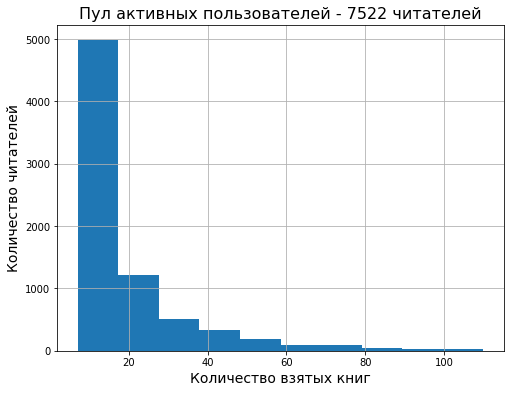

In [ ]:
filter_111 = 'books_count > 6 and books_count < 111'

plt.figure(figsize=(8, 6))
user_books_count.query(filter_111).hist(ax=plt.gca())
plt.title(
    label="Пул активных пользователей - " + f"{user_books_count.query(filter_111).shape[0]} читателей", 
    size=16)
plt.xlabel("Количество взятых книг (> 6 и < 111)", fontsize=14)
plt.ylabel("Количество читателей", fontsize=14)
plt.show()

**Вывод**

1. Мы отобрали пользователей, которые прочитали от 6 до 111 книг (~половина)

  - попробуем обучить модель с рекомендациями на этом пуле

2. Мало книг не значит, что читатель неактивный, возможно, он только недавно пришел в библиотеку

  - пока нам это неважно, важно количество книг для качественных предсказаний

  - во время сегментации пользователей учтем этот нюанс!)

#### Книги, которые читают

In [ ]:
unique_transactions = transactions[['chb', 'sys_numb']].drop_duplicates()

# Создаем новый датафрейм с количеством  читателей
# для каждой книги
books_popularity = (
    unique_transactions
    .groupby('sys_numb')
    .chb.count().to_frame()
    .rename(columns={'chb':'users_count'}))

books_popularity.describe()

,users_count
count,194666.000000
mean,1.176384
std,0.578743
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,21.000000


- Большинство книг читали только один раз, мы уже делали этот вывод в исследовании

- Посмотрим, сколько у нас останется книг в датасете, если их отфильтровать

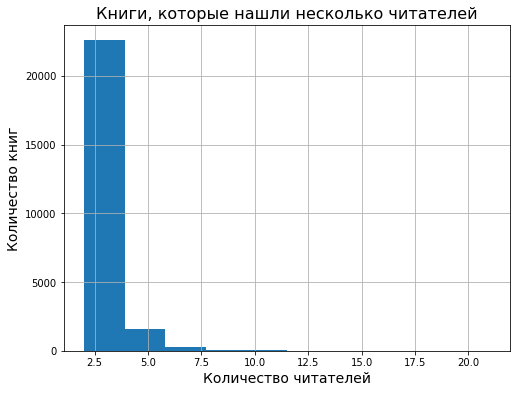

In [ ]:
plt.figure(figsize=(8, 6))
books_popularity.query('users_count > 1').hist(ax=plt.gca())
plt.title(
    label="Книги, которые нашли несколько читателей", 
    size=16)
plt.xlabel("Количество читателей", fontsize=14)
plt.ylabel("Количество книг", fontsize=14)
plt.show();

**Вывод**

1. Пул "активных" книг ~12% от общего датасета с транзациями:

 - ~25 000 книг из 194 000 имеют больше 1-го читателя

2. По идее, это минимальный набор книг, которые имеет смысл включать в обучение с подходом Colloborative Filtering.

#### Эксперименты с моделью

##### Код для экспериментов

In [ ]:
############################################################################
# Функции для экспериментов
############################################################################

def implicit_model_experiment(model_imp, dataset):
  
  """Обучает рекомендательную модель и возвращает результаты на тесте"""

  # Словарь с предобработанными датасетами для обучения
  recs_datasets = split_and_prepare_recs_data(dataset, 
                                          'chb', 'sys_numb', 0.2, False)

  # Формируем матрицы и словари с маппингом
  user_books_csr, users_dict, books_dict= get_user_item_matrix(
      recs_datasets['train_user_item'], 
      'chb', 'sys_numb', 
      recs_datasets['train_weight'])                                                       

  # Обучаем модель   
  model_imp.fit((user_books_csr * 40).astype('double'), show_progress=True)

  # Получаем список top-20 рекомендаций для каждого читателя
  recs_top_20 = get_implicit_recommendations(model_imp, 
                                          user_books_csr,
                                          users_dict, books_dict,
                                          filter_liked_items=True)                                 
  
  # Считаем усредненные показатели модели
  results = get_avg_recs_metrics(
      recs_top_20, 
      recs_datasets['test_user_item'],
      'chb', 'sys_numb', 
      print_report=False)
  
  return results


##### Фильтрация книг - как меняется датасет?

Посмотрим, как будет меняться набор пользователей и книг в датасете с разной степенью отсева "непопулярных" книг

In [ ]:
book_filters_df = pd.DataFrame(index=['кол-во книг', 'кол-во users', 'books_count >'])

for min_users in [0, 1, 2, 3, 4, 5]:

  # Задаем фильтр для книг
  # по min количеству пользователей, которые их читали
  filter_books = 'users_count > @min_users'
   
  # Фильтруем датасет
  dataset = (unique_transactions
             .loc[lambda x: x.sys_numb.isin(
                 books_popularity.query(filter_books).index)]
             ) 
 
  book_filters_df[f"users > {min_users}"] = [
      # количество уникальных пользователей и книг
      dataset.sys_numb.nunique(),
      dataset.chb.nunique(),

      # минимальное количество книг в истории пользователей
      user_books_count[user_books_count.index.isin(dataset.chb)].books_count.min()
  ]

book_filters_df

,users > 0,users > 1,users > 2,users > 3,users > 4,users > 5
кол-во книг,194666,24597,5813,1997,861,429
кол-во users,16753,12547,7682,4703,2907,1829
books_count >,2,2,2,2,2,2


**Вывод**:

1. Самый большой `отсев книг ~ в 7 раз`:
  - если оставим книги, у которых есть хотя бы несколько читателей (users > 1)
2. В датасете останется `50% пользователей`:
  - если оставим книги, у которых уже больше 2-х читателей (users > 2)

Посмотрим, как такие выборки отразятся на качестве модели!

##### Модель для "активных" книг

In [ ]:
# Датафрейм для результатов эксперимента
results_df = pd.DataFrame(index=['Hit-Rate_avg', 'Recall_avg', 'Precision_avg', 'F1-score_avg'])

# Создаем модель BRP
model_bpr = BayesianPersonalizedRanking(factors=200, learning_rate=0.3,  
                                        iterations=500,
                                        regularization=0.01)

In [ ]:
# Обучаем модель на пулах книг с разной "активностью"
for min_users in [0, 1, 2, 3, 4]:

  # Задаем фильтр для книг
  # по min количеству пользователей, которые их читали
  filter_books = 'users_count > @min_users'
   
  # Фильтруем датасет
  filtered_dataset = (unique_transactions
                      .loc[lambda x: x.sys_numb.isin(
                          books_popularity.query(filter_books).index)]).copy()
  
  # Обучаем модель
  new_result = implicit_model_experiment(model_bpr, filtered_dataset)
  
  # Сохраняем результат в общей таблице
  results_df[f'books_cnt > {min_users}'] = new_result

# Выводим результаты эксперимента
results_df

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
book_filters_df

,users_count > 0,users_count > 1,users_count > 2,users_count > 3,users_count > 4,users_count > 5
кол-во книг,194666,24597,5813,1997,861,429
кол-во users,16753,12547,7682,4703,2907,1829
books_count >,2,2,2,2,2,2


**Вывод**

1. Наша 1-я гипотеза подтвердилась! 

  - Если фокусироваться на активном пуле книг, то метод Сolloborative Filtering дает более высокие результаты

2. Метод `BPR` дает хорошее качество на менее "разреженных" матрицах и очень быстро обучается.

3. Можно попробовать отсеять книги с `users_count > 2` => уже получим 25% Hit Rate.


##### Модель для "активных пользователей"

In [ ]:
# Обучаем модель на группах пользователей с разной "активностью"
for min_books in [1]:

  # Задаем фильтр для книг
  # по min количеству пользователей, которые их читали
  filter_users = 'books_count > @min_books and books_count < 111'
   
  # Фильтруем датасет
  filtered_dataset = (unique_transactions
                      .loc[lambda x: x.chb.isin(
                          user_books_count.query(filter_users).index)]).copy()
  
  # Обучаем модель
  new_result = implicit_model_experiment(model_bpr, filtered_dataset)
  
  # Сохраняем результат в общей таблице
  results_df[f'books_cnt > {min_books}'] = new_result

# Выводим результаты эксперимента
results_df

  0%|          | 0/500 [00:00<?, ?it/s]

,books_cnt > 3
Hit-Rate_avg,0.02250
Recall_avg,0.00123
Precision_avg,0.00781
F1-score_avg,0.00213


### (3.2) Дублирующиеся книги - баг или фича?

#### Вклад каждой книги в историю читателя

В процессе подготовки данных мы фиксировали частоту появления (веса) каждой книги для каждого пользователя: 

  - Такой подход был предложен разработчиками RankFM при тестировании их моделей в сравнении с ALS в Implicit.

  - Это актуально, например, если бы мы исследовали покупку товаров)

Так как мы преварительно удаляли все дубликаты user-book, то веса были равны 1.

Интересно, а как выглядела бы картина, если бы мы оставили исходные данные?

In [ ]:
print("Книги, которые перечитывали много раз:")
books_read_twice = (transactions
                    .groupby(['chb', 'sys_numb'])
                    .size()
                    .to_frame('read_times')
                    .reset_index())

(books_read_twice
 .set_index('sys_numb')
 .join(items.set_index('sys_numb')['title'])
 .sort_values(by='read_times', ascending=False))

Книги, которые перечитывали много раз:


,chb,read_times,title
sys_numb,,,
RSL07000449201,300001090427,44,отсутствует
RSL01004357029,200000987642,42,"Переписка В. А. Жуковского и А. П. Елагиной, 1..."
RSL01010175347,300000850004,35,Система органов государственной власти в Респу...
RSL01006724299,200000957291,35,"Коллекционеры России, XVII - начало XX вв. : э..."
RSL01002745675,300000850004,26,Правопорядок в условиях формирования правового...
...,...,...,...
RSL01004063667,100001136730,1,"Пациенты диспансеров, страдающие шизофренией с..."
RSL01004063954,100001123223,1,Провоспалительные и противовоспалительные цито...
RSL01004063987,100001136730,1,Фармакогностическое изучение сухоцвета однолет...


- Какой контраст! Никто не перечитывал оптимизацию санитарно санитарно-эпидемиологического надзора и историю шизовфреников. Это радует:)

**Вывод**

1. У нас есть пул читателей, которые заказывали одну и ту же книгу по несколько раз:

  - возможно, заканчивался срок возврата книги
  - это любимые книги читателя
  - или какой-то сбой при загрузке книг


2. В прошлой имплементации удаление дубликатов снижало качество рекомендаций

  - Можно попробовать провести обучение еще раз, но в этот раз с нормализацией


#### Нормализация весов и обучение модели

Мы уже включили нормализацию в набор готовых функций, посмотрим как она работает:

In [ ]:
print("Показатели после нормализации с np.log2:")

display(np.log2(books_read_twice['read_times'] + 1).sort_values(ascending=False))

Показатели после нормализации с np.log2:


213726    5.491853
86257     5.426265
80884     5.169925
144763    5.169925
144698    4.754888
            ...   
79217     1.000000
79218     1.000000
79219     1.000000
79220     1.000000
229001    1.000000
Name: read_times, Length: 229002, dtype: float64

- Мы значительно уменьшили вес "часто" читаемых книг с 40 до 5 

- Теперь они не будут перевешивать значимость других книжек, которые еще никто ниразу не взял повторно

Построим модель! Может быть теперь мы получим более высокое качество?

In [ ]:
# Словарь с предобработанными датасетами для обучения
# Дубликаты не удаляем
recs_dict = split_and_prepare_recs_data(transactions, 
                                        'chb', 'sys_numb', 0.2)

=> Количество пользователей
Общий датасет: 16753
Обучающая выборка: 16655
Валидационная выборка: 12419

=> Проблема cold start для модели
Неизвестных пользователей: 98
Неизвестных объектов: 32248


In [ ]:
# Формируем матрицы и словари с маппингом
user_books_csr, users_dict, books_dict= get_user_item_matrix(recs_dict['train_user_item'], 
                                                             'chb', 'sys_numb', 
                                                             recs_dict['train_weight'])                                                       

print("Размер sparse-матрицы user-books:", user_books_csr.shape)

Размер sparse-матрицы user-books: (16640, 159838)


In [ ]:
alpha_value = 40

# Обучаем модель
imp_model = AlternatingLeastSquares(factors=200, random_state=777)
imp_model.fit((user_books_csr * alpha_value).astype('double'))

  0%|          | 0/15 [00:00<?, ?it/s]

#### Оценка результатов

In [ ]:
# Получаем список top-20 рекомендаций для каждого читателя
recs_als_imp = get_implicit_recommendations(imp_model, 
                                            user_books_csr,
                                            users_dict, books_dict,
                                            filter_liked_items=True)                                 

# Выводим усредненные показатели модели
get_avg_recs_metrics(recs_als_imp, recs_dict['test_user_item'],
                           'chb', 'sys_numb')

Hit-Rate_avg: 0.02965
Recall_avg: 0.01159
Precision_avg: 0.00175
F1-score_avg: 0.00305


А если мы оставим все книги, которые попали в TOP-20 (параметр `filter_liked_items=False`)?


In [ ]:
# Получаем список top-20 рекомендаций для каждого читателя
recs_als_imp = get_implicit_recommendations(imp_model, 
                                            user_books_csr,
                                            users_dict, books_dict,
                                            filter_liked_items=False)                                 

# Выводим усредненные показатели модели
get_avg_recs_metrics(recs_als_imp, recs_dict['test_user_item'],
                           'chb', 'sys_numb')

Hit-Rate_avg: 0.01776
Recall_avg: 0.00898
Precision_avg: 0.00102
F1-score_avg: 0.00183


**Вывод**

- Ох как взлетело качество! Hit-Rate = 25% против 2%!

- Все потому, что многие пользователи нашей библиотеки часто обращаются к одним и тем же книгам.

"+" для хороших предсказаний, "-" для хороших рекомендаций =)

#### Тест на платформе



Сейчас мы узнаем актуальны ли дубликаты для тестовой платформы.

Данные у нас уже подготовлены, осталось обучить модель на полной выборке.

In [ ]:
# Формируем матрицы и словари с маппингом
user_books_csr, users_dict, books_dict= get_user_item_matrix(recs_dict['all_user_item'], 
                                                             'chb', 'sys_numb', 
                                                             recs_dict['all_weight'])                                                       

print("Размер sparse-матрицы user-books:", user_books_csr.shape)

Размер sparse-матрицы user-books: (16753, 194666)


- В полной выборке у нас добавилось ~40 000 позиций книг

In [ ]:
alpha_value = 40

# Обучаем модель
imp_model = AlternatingLeastSquares(factors=200, random_state=777)
imp_model.fit((user_books_csr * alpha_value).astype('double'))

  0%|          | 0/15 [00:00<?, ?it/s]

- Не забываем отключить фильтр `filter_liked_items`

In [ ]:
# Получаем список top-20 рекомендаций для каждого читателя
recs_als_imp = get_implicit_recommendations(imp_model, 
                                            user_books_csr,
                                            users_dict, books_dict,
                                            filter_liked_items=False)      
    
# Переводим матрицу рекомендаций в формат пар user-book
solution = matrix_recs_to_pairs(recs_als_imp, 'chb', 'sys_numb') 

# Сохраняем для теста на платформе
solution.to_csv("predictions_als_imp_duplicates.csv", index=False, sep=';')                   

print(f"Сохранено {len(solution)} предсказаний")

Сохранено 335060 предсказаний


**Вывод**

1. Платформа выдала нам результат в 0.0028 

  - делаем вывод, что дубликатов в тесте не так много)

2. Когда мы выясним, откуда у пользователей по 1000 повторных прочтений книг
  - можно  использовать как  фичу "книги, которые перечитывают":
  - а пока для нас это только баг:)

### (3.3) Рекомендации новых авторов

#### Вводные

Попробуем построить такую же систему рекомендаций на базе Colloborative Filtering, но для авторов:)

- Сможем ли мы открыть для читателей новых авторов?

- Могут ли авторы помочь в предсказании новых книг?

#### Добавляем авторов в датасет



In [ ]:
unique_transactions = transactions[['chb', 'sys_numb']].drop_duplicates()
print("размер датасета до объединения:", unique_transactions.shape[0])

# Создаем временные индексы для объединения items и transactions
# Добавляем в transactions авторов книг
unique_transactions = (unique_transactions
                       .set_index('sys_numb')
                       .join(items.set_index('sys_numb')['author'])
                       .reset_index()
                      )

print("после добавления авторов:", unique_transactions.shape[0])

unique_transactions.head(5)               

размер датасета до объединения: 229002
после добавления авторов: 229002


,sys_numb,chb,author
0,RSL01000000123,100000934918,"Боронов, Адина Айылчиевич"
1,RSL01000000244,300001043470,"Дедов, Александр Викторович"
2,RSL01000000259,300001090044,"Добротворская, Карина Анатольевна"
3,RSL01000000457,100000728030,"Летягин, Лев Николаевич"
4,RSL01000000462,200001091160,"Литвин, Алексей Васильевич"


- Сколько новых имен!)

#### Популярные и любимые авторы

In [ ]:
print("Разнообразие авторов в библиотеке:", items.author.nunique())
print("Авторы, которых уже читают:", unique_transactions.author.nunique())

Разнообразие авторов в библиотеке: 172622
Авторы, которых уже читают: 104748


- Половина авторов библиотеки уже известна читателям, классно!

In [ ]:
print("Самые популярные авторы:\n")
unique_transactions.groupby('author').chb.count().sort_values().tail(20)

Самые популярные авторы:



author
Чуковский, Корней Иванович 1882-1969          42
Библия                                        43
Лосев, Алексей Федорович                      43
Россия. Государственный контроль              43
Лейкин, Николай Александрович 1841-1906       45
Романюк, Сергей Константинович                46
Юнг, Карл Густав 1875-1961                    46
Российская Федерация Законы                   47
Москва, город                                 51
Нестеров, Михаил Петрович 1959-               52
Пушкин, Александр Сергеевич 1799-1837         55
Сарабьянов, Дмитрий Владимирович              65
Нащокина, Мария Владимировна                  80
Серова, Марина Сергеевна                     100
Струнников, Сергей Николаевич 1907-1944      120
Зверев, Сергей Иванович 1964-                165
Россия. Законы и постановления               174
Конволют                                     587
отсутствует                                17267
none                                       44714
Name: chb, dt

- Законы и постановления России в 3 раза популярнее чем А.С. Пушкин..Эхх

- В топе детективы и боевики Сергея Зверева, интересно)

У нас очень много книг неизвестных авторов `отсутствует` и `none`. Придется их удалить из выборки.

In [ ]:
unique_transactions = unique_transactions[~unique_transactions.author.isin(['отсутствует', 'none'])]
unique_transactions.groupby('author').chb.count().sort_values().tail(20)

author
Алексеев, Сергей Сергеевич 1924-2013        41
Чуковский, Корней Иванович 1882-1969        42
Шахов, Максим Анатольевич 1964-             42
Лосев, Алексей Федорович                    43
Россия. Государственный контроль            43
Библия                                      43
Лейкин, Николай Александрович 1841-1906     45
Юнг, Карл Густав 1875-1961                  46
Романюк, Сергей Константинович              46
Российская Федерация Законы                 47
Москва, город                               51
Нестеров, Михаил Петрович 1959-             52
Пушкин, Александр Сергеевич 1799-1837       55
Сарабьянов, Дмитрий Владимирович            65
Нащокина, Мария Владимировна                80
Серова, Марина Сергеевна                   100
Струнников, Сергей Николаевич 1907-1944    120
Зверев, Сергей Иванович 1964-              165
Россия. Законы и постановления             174
Конволют                                   587
Name: chb, dtype: int64

- Так то лучше!

- Посмотрим, а есть ли у наших читателей любимые авторы?

In [ ]:
unique_transactions.groupby(['chb', 'author']).sys_numb.count().sort_values().tail(20)

chb           author                                    
100000953820  Плеханов, Георгий Валентинович (1856-1918)     21
100001064348  Москва, город                                  21
300000841170  Лейкин, Николай Александрович 1841-1906        24
300001015451  Тамоников, Александр Александрович 1959-       24
100001091809  Мышкинское уезд. земское собрание              25
100000953820  Конволют                                       25
300001015451  Серегин, Михаил Георгиевич                     25
300001132797  Рославльское уездное земское собрание          25
300001015451  Шитов, Владимир Кузьмич                        28
              Казанцев, Кирилл                               29
100000836042  Человеколюбивое общество (Петербург)           29
300001030736  Тульское губ. земское собрание                 30
300001015451  Дышев, Андрей Михайлович                       36
              Устинова, Татьяна Витальевна 1968-             37
              Шахов, Максим Анатольевич 1964-  

1. Похоже, популярность авторам делают их поклонники:

  - Помним, что у загадочного мужчины (300001015451) было ~6000 выдач книг.

2. Многие читают пачками книги из одного собрания:)

Интересно, какой набор книг скрывается под секретным "Конволют"? И читает ли загадочный 300000758346 что-то еще?

In [ ]:
unique_transactions.query('chb == "300000758346"')

,sys_numb,chb,author
7455,RSL01000643335,300000758346,"Скворцов, Дмитрий Иванович 1861-не ранее 1907"
29609,RSL01001839439,300000758346,Иоанн Кронштадтский св. 1829-1908
29666,RSL01001842091,300000758346,"Магнуссен, Владимир Петрович"
30585,RSL01001873071,300000758346,"Берио, Шарль Огюст де"
30586,RSL01001885398,300000758346,"Богдашев, П.Н."
...,...,...,...
184443,RSL01009880936,300000758346,Конволют
184447,RSL01009880973,300000758346,Конволют
184449,RSL01009881128,300000758346,Конволют
184452,RSL01009881172,300000758346,Конволют


In [ ]:
items.query('author == "Конволют"')

,sys_numb,title,author,izd,year_izd,bbk
13,RSL01010972888,Русский язык в школе = Russian language at sch...,Конволют,none,2022,none
70,RSL01010988967,Инновационная экономика и современный менеджме...,Конволют,none,2022,none
788,RSL01002912116,: Поэма еды,Конволют,none,1928,Ш5(2=Р)53-651
860,RSL01005711499,"Описание японских рукописей, ксилографов и ста...",Конволют,none,1963,none
2034,RSL01010984580,Вестник дополнительного образования : журнал :...,Конволют,none,2022,none
...,...,...,...,...,...,...
343139,RSL01003885385,Описание рукописей Церковно-археологического м...,Конволют,none,1875,none
343140,RSL01003885383,Описание рукописей Церковно-археологического м...,Конволют,none,1879,none
343494,RSL01003793198,: Настоятели Московского Большого Успенского ...,Конволют,Тип. Свято-Троицкой Сергиевой лавры,1912,none
348959,RSL01003561528,: О человеке и его отношениях к природе,Конволют,[б. и.],1847,"Е,0"


- Поэма еды!

-<img src="https://rusneb.ru/local/tools/exalead/thumbnail.php?url=000199_000009_002912116&width=360&height=460">


**Вывод**

1. Было бы интересно научиться открывать для читателей новых авторов:)

  - Ведь если понравится автор, это еще +30 любимых книг:) 

2. Новизна авторов - +1 фактор к оценке и тестированию рекомендательной системы


#### Обучаем модель предсказаний

In [ ]:
# Словарь с предобработанными датасетами для обучения
recs_dict = split_and_prepare_recs_data(unique_transactions, 
                                        'chb', 'author', 0.25)

=> Количество пользователей
Общий датасет: 16265
Обучающая выборка: 15768
Валидационная выборка: 11457

=> Проблема cold start для модели
Неизвестных пользователей: 497
Неизвестных объектов: 20321


In [147]:
# Формируем матрицы и словари с маппингом
user_authors_csr, users_dict, authors_dict= get_user_item_matrix(recs_dict['all_user_item'], 
                                                             'chb', 'author', 
                                                             recs_dict['all_weight'])                                                       

print("Размер sparse-матрицы user-authors:", user_authors_csr.shape)

alpha_value = 40

# Обучаем модель
imp_model = AlternatingLeastSquares(factors=200, random_state=777)
imp_model.fit((user_authors_csr * alpha_value).astype('double'))


KeyError: ignored

In [ ]:

# Получаем список top-20 рекомендаций для каждого читателя
recs_als_imp = get_implicit_recommendations(imp_model, 
                                            user_authors_csr,
                                            users_dict, authors_dict,
                                            filter_liked_items=True)                                 

# Выводим усредненные показатели модели
get_avg_recs_metrics(recs_als_imp, recs_dict['test_user_item'],
                           'chb', 'author')

Hit-Rate_avg: 0.04772
Recall_avg: 0.01847
Precision_avg: 0.00258
F1-score_avg: 0.00453


#### Общий вывод

Теперь мы можем использовать созданную cистему Colloborative Filtering для рекомендаций новых авторов!


1. Такой подход будет намного интереснее для "активных" читателей =)

  - Если наша модель будет "успешно" рекомендовать книги уже известных авторов, то пользователям это быстро наскучит)) 

2. Мы получили примерно такое же качество модели, как и для книг, HitRate ~5% для всех данных

3. Можно так же, как мы тестировали, сузить фокус:

  - на половине читателей -> 15% Hit Rate
  - на самых активных читателях и получить 30% HitRate

По мере развития библиотеки и нашей системы, будет появляться все больше данных для успешного применения Colloborative Filtering.

Для новых и не сильно активных пользователей (пока у нас таких большинство) нужен другой подход к рекомендациям!

## **ЭКСПЕРИМЕНТ. Предсказания с похожими книгами

### Использование дубликатов

#### Обучение без дубликатов

Выборка делится на две части - обучающую и тестовую

- В обучающей дубликаты удаляем
- В тестовой выборке дубликаты тоже удаляем

In [169]:
# Словарь с предобработанными датасетами для обучения
recs_dict = split_and_prepare_recs_data(transactions, 
                                        'chb', 'sys_numb', 0.3, 
                                         print_report=False, 
                                         delete_test_duplicates=True)

print("Размер тестовой выборки без дубликатов:")
recs_dict['test_user_item'].shape

Размер тестовой выборки без дубликатов:


(73846, 2)

In [170]:
# Формируем матрицы и словари с маппингом
user_books_csr, users_dict, books_dict= get_user_item_matrix(
    recs_dict['train_user_item'], 
    'chb', 'sys_numb', 
    recs_dict['train_weight'])                                                       

print("Размер sparse-матрицы user-books:", user_books_csr.shape)

Размер sparse-матрицы user-books: (16534, 145542)


In [187]:
alpha_value = 40


# Обучаем модель
imp_model = AlternatingLeastSquares(factors=200, random_state=777)
imp_model.fit((user_books_csr * alpha_value).astype('double'))

  0%|          | 0/15 [00:00<?, ?it/s]

In [188]:
# Получаем список top-20 рекомендаций для каждого читателя
recs_als_imp = get_implicit_recommendations(imp_model, 
                                            user_books_csr,
                                            users_dict, books_dict,
                                            filter_liked_items=True)                                 

# Выводим усредненные показатели модели
get_avg_recs_metrics(recs_als_imp, recs_dict['test_user_item'],
                           'chb', 'sys_numb')

Hit-Rate_avg: 0.0274
Recall_avg: 0.00178
Precision_avg: 0.00775
F1-score_avg: 0.0029


[0.0274, 0.00178, 0.00775, 0.0029]

In [190]:
# Переводим матрицу рекомендаций в датафрейм с парами user-book
all_users_recs = matrix_recs_to_pairs(recs_als_imp, 'chb', 'sys_numb') 

contest_metric(
      all_users_recs,
      recs_dict['test_user_item'],
      print_report=True)

Угаданных книг: 491
Recall: 0.00665
Precision: 0.00175
F1-score: 0.00277


[491, 0.006648972185358719, 0.0017475797266514807, 0.0027677096779648597]

In [161]:
hybrid_solution = all_users_recs[~all_users_recs.chb.isin(
    unactive_users_recs.chb
)]

hybrid_solution = pd.concat([hybrid_solution, unactive_users_recs], axis=0)
hybrid_solution = hybrid_solution[['chb', 'sys_numb']]

In [164]:
# Отправляем результаты на платформу
hybrid_solution.to_csv("half_users.csv", index=False, sep=';')

#### Обучение с дубликатами

Выборка делится на две части - обучающую и тестовую

- В обучающей дубликаты удаляются 
- В тестовой выборке оставляем


Смотрим результат, если метрика выше, значит, на платформе тоже есть дубликаты (и исходный датасет просто рандомно разделили)

In [133]:
# Словарь с предобработанными датасетами для обучения
recs_dict = split_and_prepare_recs_data(transactions, 
                                        'chb', 'sys_numb', 0.3, 
                                         print_report=False, 
                                         delete_test_duplicates=True)

print("Размер тестовой выборки без дубликатов:")
recs_dict['test_user_item'].shape

Размер тестовой выборки без дубликатов:


(74282, 2)

In [136]:
# Словарь с предобработанными датасетами для обучения
recs_dict = split_and_prepare_recs_data(transactions, 
                                        'chb', 'sys_numb', 0.2, 
                                         print_report=False, 
                                         delete_test_duplicates=False)

print("Размер тестовой выборки с дубликатами:")
recs_dict['test_user_item'].shape

Размер тестовой выборки с дубликатами:


(51871, 2)

- Примерно 4000 дубликатов в тестовой выборке

In [137]:
# Формируем матрицы и словари с маппингом
user_books_csr, users_dict, books_dict= get_user_item_matrix(
    recs_dict['train_user_item'], 
    'chb', 'sys_numb', 
    recs_dict['train_weight'])                                                       

print("Размер sparse-матрицы user-books:", user_books_csr.shape)

Размер sparse-матрицы user-books: (16672, 162599)


In [174]:
user_books_csr.shape

(16534, 145542)

In [138]:
alpha_value = 40

# Обучаем модель
imp_model = AlternatingLeastSquares(factors=200, random_state=777)
imp_model.fit((user_books_csr * alpha_value).astype('double'))

  0%|          | 0/15 [00:00<?, ?it/s]

In [173]:
# Получаем список top-20 рекомендаций для каждого читателя
recs_als_imp = get_implicit_recommendations(imp_model, 
                                            user_books_csr,
                                            users_dict, books_dict,
                                            filter_liked_items=False,
                                            top_n=20)                                 

# Выводим усредненные показатели модели
get_avg_recs_metrics(recs_als_imp, recs_dict['test_user_item'],
                           'chb', 'sys_numb')

Hit-Rate_avg: 0.0002
Recall_avg: 1e-05
Precision_avg: 6e-05
F1-score_avg: 2e-05


[0.0002, 1e-05, 6e-05, 2e-05]

In [144]:
# Переводим матрицу рекомендаций в датафрейм с парами user-book
all_users_recs = matrix_recs_to_pairs(recs_als_imp, 'chb', 'sys_numb') 

display(all_users_recs.head(3))
recs_dict['test_user_item'].head(3)

,sys_numb,chb
0,RSL01003441482,100000641403
1,RSL01008477654,100000641403
2,RSL01004190969,100000641403


,chb,sys_numb
4,100000644359,RSL01003557352
13,100000644359,RSL01010594911
16,100000665127,RSL01003276143


#### Общий вывод

1. В тестовой выборке есть дубликаты

  - На кросс-валидации проверка на тестовой выборке с дубликатами дала более высокие показатели
  - 0.00319 против 0.00292

2. Возможно, именно поэтому наши результаты на платформе были выше, чем на кросс-валидации (т.к. мы проверяли метрики на уникальных значениях)

3. Если порекомендуем пользователям, которых не угадываем, просто похожие книги - может сработать

### Рекомендации для "неактивных" пользователей

#### Разделение групп пользователей

Мы не угадывам книги для пользователей, которые прочитали меньше 3 книг

Добавим им рекомендации похожих книг

In [114]:
print("Активность пользователей в обучающей выборке")
train_users_activity = (
  recs_dict['train_user_item']
 .groupby('chb').sys_numb.count()
 .to_frame('books_count')
)

train_users_activity.sort_values(by='books_count').describe()

Активность пользователей в обучающей выборке


NameError: ignored

In [ ]:
print("Количество пользователей с < 3 книг в истории:",
      train_users_activity.query('books_count  < 3').shape[0])

Количество пользователей с < 3 книг в истории: 4270


- Удалим рекомендации модели для этих 4270 пользователей

- Оставим рекомендации только для активных читателей

In [ ]:
active_users_recs = all_users_recs[~all_users_recs.chb.isin(
    train_users_activity.query('books_count  < 3').index
)]
print("Читателей в рекомендациях:", all_users_recs.chb.nunique())
print("Активных читателей в рекомендациях:", active_users_recs.chb.nunique())   


Читателей в рекомендациях: 16505
Активных читателей в рекомендациях: 12235


- Сформируем рекомендации для остальных пользователей только на основе прочитанных книг

- Не будем использовать предпочтения других читателей (Collaborative Filtering)

#### Ищем похожие книги

In [ ]:
# Оставляем в рекомендациях неактивных пользователей похожие книги
other_users_recs = (
    recs_dict['train_user_item'][recs_dict['train_user_item'].chb.isin(
        train_users_activity.query('books_count  < 3').index
    )])

print("Количество читателей с рекомендациями похожих книг:",
      other_users_recs.chb.nunique())
print("Количество рекомендаций:", len(other_users_recs))

Количество читателей с рекомендациями похожих книг: 4270
Количество рекомендаций: 7098


- Для 4270 пользователей мы оставили похожие книги, которые они читали

- Получилось < 20 рекомендаций на каждого (можно будет добавить еще)

Посчитаем метрики!

#### Создаем гибридное решение

In [ ]:
# Объединяем рекомендации для двух групп пользователей
hybrid_solution = pd.concat([active_users_recs, other_users_recs], axis=0)

display(hybrid_solution.head(3))
print("Количество рекомендаций в гибридном решении:",
      len(hybrid_solution))

,sys_numb,chb
20,RSL01010647947,100000644359
21,RSL01010278914,100000644359
22,RSL01010582576,100000644359


Количество рекомендаций в гибридном решении: 251798


- Вот он, запас из ~ 76 000 рекомендаций для новых пользователей (4270 х 18)


#### Оценка результатов

In [ ]:
# Выводим усредненные показатели исходных рекомендаций
get_avg_recs_metrics(recs_als_imp, recs_dict['test_user_item'],
                           'chb', 'sys_numb')

Hit-Rate_avg: 0.0314
Recall_avg: 0.00189
Precision_avg: 0.00933
F1-score_avg: 0.00314


[0.0314, 0.00189, 0.00933, 0.00314]

In [ ]:
# Метрики конкурса исходных рекомендаций
contest_metric(all_users_recs, recs_dict['test_user_item'])

Угаданных книг: 526
Recall: 0.00705
Precision: 0.00186
F1-score: 0.00294


In [ ]:
# Метрики конкурса гибридных рекомендаций
contest_metric(hybrid_solution, recs_dict['test_user_item'])

Угаданных книг: 754
Recall: 0.01011
Precision: 0.00267
F1-score: 0.00422


**Вывод**

Даа!! Наша гипотеза подтвердилась:) Метрики стали в 2 раза выше

- Можно дополнить 18-ю рекомендациями для неактивных пользователей (по жанрам, названию)

- Добавить похожие книги и для других пользователей

### Эксперименты с гибридной моделью

##### Кросс-валидация

Будем увеличивать количество пользователей, для которых будем делать рекомендации с похожими книгами

In [ ]:
# Датафрейм для результатов экспериментов
results_df = pd.DataFrame(index=['Угаданных книг', 'Recall', 'Precision', 'F1-score'])

In [ ]:
for max_books_count in [2, 3, 4, 5, 6, 7]:

  # Выделяем группу активных пользователей
  active_users_recs = all_users_recs[~all_users_recs.chb.isin(
      train_users_activity.query('books_count  <  @max_books_count').index
  )]

  # Оставляем в рекомендациях неактивных пользователей похожие книги
  other_users_recs = (
      recs_dict['train_user_item'][recs_dict['train_user_item'].chb.isin(
          train_users_activity.query('books_count  < @max_books_count').index
      )])

  # Объединяем рекомендации для двух групп пользователей
  hybrid_solution = pd.concat([active_users_recs, other_users_recs], axis=0)

  # Сохраняем метрики конкурса гибридных рекомендаций
  results_df[f'user_books_count < {max_books_count}'] = contest_metric(
      hybrid_solution, recs_dict['test_user_item'],
      print_report=False)
  
# Выводим результаты экспериментов
results_df

,user_books_count < 2,user_books_count < 3,user_books_count < 4,user_books_count < 5,user_books_count < 6,user_books_count < 7,user_books_count < 1000,user_books_count < 6000
Угаданных книг,571.000000,754.000000,1045.000000,1337.000000,1638.000000,1936.000000,9973.000000,10258.000000
Recall,0.007654,0.010107,0.014007,0.017921,0.021956,0.025950,0.133679,0.137499
Precision,0.002018,0.002665,0.003694,0.004726,0.005790,0.006843,0.035253,0.036260
F1-score,0.003194,0.004218,0.005846,0.007480,0.009164,0.010831,0.055792,0.057387


**Вывод**

- Чем больше число пользователей, которым мы рекомендуем похожие книги, тем выше результат!

- Посмотрим, сохранится ли такой же тренд на тесте

#### Тест на платформе

Добавим рекомендации похожих книг для пользователей, которые в общем датасете прочитали < 4 книг

Посмотрим, как это отразится на результатах на тесте

##### Обучаем модель

In [ ]:
# Формируем матрицы и словари с маппингом
# Для полного датасета
user_books_csr, users_dict, books_dict= get_user_item_matrix(
    recs_dict['all_user_item'], 
    'chb', 'sys_numb', 
    recs_dict['all_weight'])   

In [ ]:
alpha_value = 40

# Обучаем модель на полном датасете
imp_model = AlternatingLeastSquares(factors=200, random_state=777)
imp_model.fit((user_books_csr * alpha_value).astype('double'))

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
# Получаем список top-20 рекомендаций для каждого читателя
recs_als_imp = get_implicit_recommendations(imp_model, 
                                            user_books_csr,
                                            users_dict, books_dict,
                                            filter_liked_items=True)    

# Переводим матрицу рекомендаций в датафрейм с парами user-book
all_users_recs = matrix_recs_to_pairs(recs_als_imp, 'chb', 'sys_numb')  
all_users_recs

,sys_numb,chb
0,RSL01004185091,100000641403
1,RSL01003441482,100000641403
2,RSL01004190969,100000641403
3,RSL01008477654,100000641403
4,RSL01003792529,100000641403
...,...,...
335055,RSL01002745327,400001035059
335056,RSL01002338054,400001035059
335057,RSL01003331238,400001035059
335058,RSL01000302759,400001035059


##### Создаем гибридные рекомендации

In [224]:
print("Активность пользователей в полной выборке")
all_users_activity = (
  recs_dict['all_user_item']
 .groupby('chb').sys_numb.count()
 .to_frame('books_count')
)

all_users_activity.sort_values(by='books_count').describe()

Активность пользователей в полной выборке


,books_count
count,16753.000000
mean,13.669313
std,70.121205
min,2.000000
25%,3.000000
50%,6.000000
75%,12.000000
max,6671.000000


In [225]:
all_users_activity.query('books_count < 3').shape[0]

1816

In [226]:
all_users_activity.query('books_count < 4').shape[0]

4533

- У половины пользователей прочитано меньше 6 книг

In [227]:
max_books_count = 3

# Выделяем группу активных пользователей
active_users_recs = all_users_recs[~all_users_recs.chb.isin(
      all_users_activity.query('books_count  <  @max_books_count').index
  )]

# Оставляем в рекомендациях неактивных пользователей похожие книги
other_users_recs = (
      recs_dict['all_user_item'][recs_dict['all_user_item'].chb.isin(
          all_users_activity.query('books_count  < @max_books_count').index
      )])

# Объединяем рекомендации для двух групп пользователей
hybrid_solution = pd.concat([active_users_recs, other_users_recs], axis=0)

hybrid_solution

,sys_numb,chb
0,RSL01003441482,100000641403
1,RSL01008477654,100000641403
2,RSL01004190969,100000641403
3,RSL01003639696,100000641403
4,RSL01003698861,100000641403
...,...,...
228648,RSL01002708622,300001156023
228928,RSL01002973703,300001170121
228929,RSL01008705388,300001170121
228933,RSL01003305563,300001172682


##### Отправляем результаты

In [ ]:
# Отправляем результаты на платформу
hybrid_solution.to_csv("hybrid_solution_v2.csv", index=False, sep=';')

**Вывод**

- Метрика не улучшилась, значит, дубликатов на платформе нет

- И не ухудшилась - значит, мы действительно можем использоват другой подход для рекомендаций "неактивным пользователям"

### Неявные дубликаты книг 


In [ ]:
print("Книг в библиотеке с одинаковыми названиями:", items['title'].duplicated().sum())

Книг в библиотеке с одинаковыми названиями: 34534


- 34534!! А ведь это только сами копии, еще есть исходники

- Значит, минимум 50 000 одинаковых книг с разными изданиями?

In [ ]:
unique_transactions = transactions[['chb', 'sys_numb']].drop_duplicates()

print("==> Количество изданий разных лет в транзакицях <==")
(unique_transactions.set_index('sys_numb')
 .join(items.set_index('sys_numb')[['title', 'author', 'year_izd']])
 .groupby(['title'])
 .year_izd.nunique().sort_values()).tail(1000)

==> Количество изданий разных лет в транзакицях <==


title
Русское купечество. Гении дела и творцы истории : 12+                                                                                  2
Служба внешней разведки : история, люди, факты                                                                                         2
Экологическое право : учебник                                                                                                          2
Радиобиологические эффекты модификаторов эндогенного синтеза оксида азота : диссертация .. кандидата биологических наук : 03.01.01     2
Жемчужины восточной медицины : уникальные рецепты практикующих целителей Востока                                                       2
                                                                                                                                      ..
Воспоминания                                                                                                                          15
Избранные произведения             

- У нас есть уже как минимум тысяча книг в транзакциях с таким диагнозом!

- А это, значит, что модель ALS делает неправильные выводы - и у пользователей намного больше общих книг

In [ ]:
unique_transactions = (
  unique_transactions.set_index('sys_numb')
 .join(items.set_index('sys_numb')[['title', 'author', 'year_izd']])
)

KeyError: ignored

In [ ]:
unique_transactions.head(5)

,chb,title,author,year_izd
sys_numb,,,,
RSL01000000123,100000934918,"Антропонимы в киргизском героическом эпосе ""Ма...","Боронов, Адина Айылчиевич",1988
RSL01000000244,300001043470,Chlorella pyrenoidosa 82Т как тест-объект в би...,"Дедов, Александр Викторович",1998
RSL01000000259,300001090044,Айседора Дункан и театральная культура эпохи М...,"Добротворская, Карина Анатольевна",1992
RSL01000000457,100000728030,"""Записки"" А. И. Кошелева как памятник отечеств...","Летягин, Лев Николаевич",1993
RSL01000000462,200001091160,Аграрная буржуазия в политической жизни Индии ...,"Литвин, Алексей Васильевич",1990


In [ ]:
unique_books = items[['title', 'author', 'bbk']].drop_duplicates()
len(unique_books)

324034

In [ ]:
items.sys_numb.nunique()

354355

### Обучаем по моде

Есть идея попробовать добавить книги, которые читатель читает чаще всего

Для этого будем использовать моду

#### Отескаем часть предсказаний

In [169]:
# Получаем список top-20 рекомендаций для каждого читателя
recs_als_imp = get_implicit_recommendations(imp_model, 
                                            user_books_csr,
                                            users_dict, books_dict,
                                            filter_liked_items=True,
                                            top_n=21)                                 

# Выводим усредненные показатели модели
get_avg_recs_metrics(recs_als_imp, recs_dict['test_user_item'],
                           'chb', 'sys_numb')

Hit-Rate_avg: 0.0299
Recall_avg: 0.00167
Precision_avg: 0.01149
F1-score_avg: 0.00292


[0.0299, 0.00167, 0.01149, 0.00292]

- Возьмем первые 20 предсказаний

In [196]:
# Переводим матрицу рекомендаций в датафрейм с парами user-book
all_users_recs = matrix_recs_to_pairs(recs_als_imp.iloc[:, :20], 'chb', 'sys_numb') 

Угаданных книг: 420
Recall: 0.00839
Precision: 0.00169
F1-score: 0.00282


[420, 0.008387921393193802, 0.0016927293245203934, 0.0028169769812738106]

- А если возьмем только 19?

In [197]:
# Переводим матрицу рекомендаций в датафрейм с парами user-book
all_users_recs = matrix_recs_to_pairs(recs_als_imp.iloc[:, :19], 'chb', 'sys_numb') 

contest_metric(
      all_users_recs, recs_dict['test_user_item'],
      print_report=True)

Угаданных книг: 408
Recall: 0.00815
Precision: 0.00164
F1-score: 0.00274


[408, 0.008148266496245407, 0.0016443656295340964, 0.002736491924665987]

In [199]:
all_users_recs.groupby('chb').sys_numb.count().head(5)

chb
100000641403    19
100000644359    19
100000665127    19
100000676191    19
100000679200    19
Name: sys_numb, dtype: int64

Попробуем добавить предсказания с помощью моды (по 1-му на каждого читателя)

#### Считаем моды для пользователей в train

In [238]:
mode_users_recs = (
    recs_dict['train_all']
    .groupby('chb').sys_numb.agg(lambda x: pd.Series.mode(x)[0])
    .to_frame('sys_numb')
    .reset_index())
mode_users_recs.head(5)

,chb,sys_numb
0,100000641403,RSL01000769304
1,100000644359,RSL01009833577
2,100000665127,RSL01000198239
3,100000676191,RSL01005076342
4,100000679200,RSL01000123386


#### Оценка результатов

Объединяем рекомендации в один датафрейм

In [239]:
# Объединяем рекомендации для двух групп пользователей
hybrid_solution = pd.concat([all_users_recs, mode_users_recs], axis=0)

contest_metric(
      hybrid_solution, recs_dict['test_user_item'],
      print_report=True)

Угаданных книг: 1312
Recall: 0.0262
Precision: 0.00529
F1-score: 0.0088


[1312, 0.026202268733024444, 0.005287763985168467, 0.008799699522455332]

- Метрика выросла в 4 раза (это ожидаемо, ведь мы уже проверяли влияние дубликатов на результаты)

- В этот раз мы добавим по 1-му дубликату каждому пользователю, а не только "неактивным"

#### Проверка на тесте

In [240]:
# Вычисляем моды по полному датасету
# Сохраняем как рекомендации
mode_users_recs = (
    recs_dict['all_user_item']
    .groupby('chb').sys_numb.agg(lambda x: pd.Series.mode(x)[0])
    .to_frame('sys_numb')
    .reset_index())

len(mode_users_recs)

16753

In [241]:
# Формируем матрицы и словари с маппингом
# Для полного датасета
user_books_csr, users_dict, books_dict= get_user_item_matrix(
    recs_dict['all_user_item'], 
    'chb', 'sys_numb', 
    recs_dict['all_weight'])   

alpha_value = 40

# Обучаем модель на полном датасете
imp_model = AlternatingLeastSquares(factors=200, random_state=777)
imp_model.fit((user_books_csr * alpha_value).astype('double'))

  0%|          | 0/15 [00:00<?, ?it/s]

- Все то же самое, но сохраняем только 19 рекомендаций на каждого читателя

In [242]:
# Получаем список top-19 рекомендаций для каждого читателя
recs_als_imp = get_implicit_recommendations(imp_model, 
                                            user_books_csr,
                                            users_dict, books_dict,
                                            filter_liked_items=True,
                                            top_n=19)    

# Переводим матрицу рекомендаций в датафрейм с парами user-book
all_users_recs = matrix_recs_to_pairs(recs_als_imp, 'chb', 'sys_numb')  
all_users_recs.head(4)

,sys_numb,chb
0,RSL01004185091,100000641403
1,RSL01003441482,100000641403
2,RSL01004190969,100000641403
3,RSL01008477654,100000641403


In [247]:
# Объединяем рекомендации для двух групп пользователей
hybrid_solution = pd.concat([all_users_recs, mode_users_recs], axis=0)
hybrid_solution.groupby('chb').sys_numb.count().head(5)

chb
100000641403    20
100000644359    20
100000665127    20
100000676191    20
100000679200    20
Name: sys_numb, dtype: int64

In [249]:
hybrid_solution = hybrid_solution[['chb', 'sys_numb']]

# Отправляем результаты на платформу
hybrid_solution.to_csv("hybrid_solution_v3.csv", index=False, sep=';')

## ЭТАП 4. Интерпретация предсказаний

Выясним, для каких пользователей мы делаем больше хороших предсказаний, а для каких не можем угадать даже одну книгу:)

В качестве предсказаний и реальных данных можно загрузить любые результаты экспериментов в блоке "Загрузка предсказаний"

### Загрузка предсказаний

In [ ]:
# Загружаем ранее сохраненные предсказания
# all_users_predictions = pd.read_csv("all_users_predictions.csv", sep=';')

# Обучаем произвольную модель
all_users_predictions, results, test_data = als_model_experiment(
    transactions[['chb', 'sys_numb']].drop_duplicates(), 
    model_dicts, top_n=20
)

/usr/local/lib/python3.7/dist-packages/implicit/utils.py:29: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  "OpenBLAS detected. Its highly recommend to set the environment variable "


  0%|          | 0/15 [00:00<?, ?it/s]

Угаданных книг: 467
Recall: 0.0102
Precision: 0.00162
F1-score: 0.00279


In [ ]:
# Загружаем данные одного из экспериментов
all_users_predictions = solution
test_data = recs_dict['test_user_item']

### Какие книги мы рекомендуем?

Посмотрим предсказания, которые мы сгенерировали с помощью ALS метода 
 - получили 0.00296 на валидационной выборке, 0.0058 на тесте платформы


In [ ]:
# Для каждой книги
# считаем количество пользователей, которым ее порекомендовали
predicted_books = (
    all_users_predictions.groupby('sys_numb')
    .chb.count().sort_values().to_frame('recs_pop'))

predicted_books

,recs_pop
sys_numb,
RSL01000000123,1
RSL01005374622,1
RSL01005374310,1
RSL01005374120,1
RSL01005373771,1
...,...
RSL01008994976,524
RSL01009501121,617
RSL01009825267,617


- Интересно! Есть книги, которые мы рекомендовали всего раз, а какие-то тысячам пользователей)

- Посмотрим, что это за книги, и бьются ли они с самыми популярными в датасете)

In [ ]:
predicted_books = (
    predicted_books.join(books_popularity)
    .join(items.set_index('sys_numb')[['author', 'title', 'bbk']])
)

In [ ]:
print("Самые часто читаемые книги и их популярность в рекомендациях:")
predicted_books.sort_values(by='users_count', ascending=False).head(20)

Самые часто читаемые книги и их популярность в рекомендациях:


,recs_pop,users_count,author,title,bbk
sys_numb,,,,,
RSL01009819710,153,21,none,С Рождеством Христовым Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01009824134,126,18,none,С Рождеством Христовым! Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01009824143,271,16,none,С Рождеством Христовым! Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01009819687,107,16,none,С Рождеством Христовым Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01002890388,292,15,none,"Архитектура Москвы, 1920-1960 = Moscow archite...",Н0(2Р=Р)92Москва07я23
RSL01003187450,110,15,none,Купеческая Москва : образы ушедшей российской ...,Т3(2)5-285.9Москва.я43\nТ3(2)5-752.39Москва.я4...
RSL01009817128,130,15,none,С Рождеством Христовым Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01009819689,111,15,none,С Рождеством Христовым Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01009819690,127,14,none,С Рождеством Христовым Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3


**Вывод 1**

Популярные книги мы рекомендовали как минимум сотне человек

-  у них не самый большой рейтинг среди рекомендаций Matrix Factorization:)
-  хорошо, ведь иначе абсолютно всем пришлось бы изучать открытки "С Рождеством Христовым!"


In [ ]:
print("Самые популярные книги в рекомендациях и количество их читателей:")
predicted_books.sort_values(by='recs_pop', ascending=False).head(20)

Самые популярные книги в рекомендациях и количество их читателей:


,recs_pop,users_count,author,title,bbk
sys_numb,,,,,
RSL01005241876,1407,10,"Карклин, Павел Иванович",Военная книга (1934-1939) : библиографический ...,none
RSL01008540523,640,2,"Дробышевский, Дмитрий Александрович","Газета ""Россия"" (28 апреля 1899 г. - 13 января...",none
RSL01009825267,617,2,"Хозяинова, Полина Михайловна",Личностные особенности матери как фактор ее со...,none
RSL01009501121,617,6,"Бундин, Михаил Вячеславович",Персональные данные в системе информации огран...,none
RSL01008994976,524,2,"Гальцина, Дарья Александровна",Информационная политика стран Таможенного союз...,none
RSL01008753883,503,3,"Шаститко, Анастасия Андреевна",Антимонопольное регулирование на рынках взаимо...,none
RSL01010171870,492,2,"Ляшковская, Светлана Владимировна",Оптимизация индивидуальных программ и типологи...,none
RSL01008787899,461,2,"Субхангулов, Рустям Эрвинович",Феномен доверия как фактор социального взаимод...,none
RSL01009472301,445,2,"Ткачев, Павел Сергеевич",Социальное проектирование и социальная реклама...,none


**Вывод 2**

1. Самые популярные книги в нашей системе рекомендуются **1-2 тысячам** пользователей

2. У большинства таких книг как минимум `5 читателей` (! возьмем на заметку)

3. По описаниям и bbk видим, что у рекомендаций широкий охват жанров)

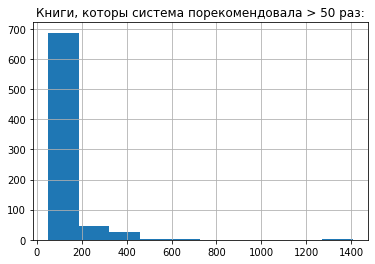

In [ ]:
predicted_books.query('recs_pop > 50').recs_pop.hist();
plt.title("Книги, которы система порекомендовала > 50 раз:")
plt.show()

Возможно, именно здесь находятся рекомендации, которые попали в яблочко)

### Общий Hit-Rate

- Напишем функцию для попарного сравнения `датафреймов с рекомендациями`

- Она пригодится нам для оценки качества предсказаний

In [85]:
def compare_two_df(df1, df2):
  """
  Объединяет два датафрейма по парам (читатель, книга)

  в результате остается только их пересечение(там, где пары совпали)
  """

  res = pd.merge(df1[['chb', 'sys_numb']],
                 df2[['chb', 'sys_numb']],
                 on=['chb', 'sys_numb'], how='inner')

  return res

# compare_results = compare_two_df(all_users_predictions, test_data)


- Посмотрим, какое количество книг мы в среднем угадали для каждого пользователя.


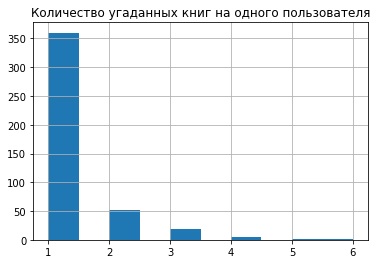

In [ ]:
true_books = compare_two_df(all_users_predictions, test_data)
true_books.groupby('chb').count().hist()
plt.title("Количество угаданных книг на одного пользователя")
plt.show()

**Вывод**

Мы "захватили" ~500 читателей

  - Для  большинства угадали одну книгу

  - Есть и те, для которых у нас даже 4 и 5 попаданий)

Возможно, это рекордсмены, которые заказывают больше 1000 книг? Проверим!

### Какие книги мы угадываем?

С реальными читателями мы узнаем это только после запуска системы в продакшен.

Попробуем пока разгадать тайну тестовых данных (что работает, а что нет)

In [ ]:
true_books = true_books.set_index('sys_numb').join(predicted_books)

In [ ]:
true_books.sort_values(by='recs_pop', ascending=False).head(20)

,chb,recs_pop,users_count,author,title,bbk
sys_numb,,,,,,
RSL01009501121,300001013495,617,6,"Бундин, Михаил Вячеславович",Персональные данные в системе информации огран...,none
RSL01002884697,300001018454,367,14,"Азимов, Айзек 1920-1992",Слова на карте = Words on the map : геогр. наз...,Д8я212
RSL01002840579,300001114805,328,11,"Кузнецов, Сергей Львович","Гистология, цитология и эмбриология : : учебни...",Р716.110я73-1\nЕ83я73-1\nЕ866я73-1
RSL01002840579,300001114805,328,11,"Кузнецов, Сергей Львович","Гистология, цитология и эмбриология : : учебни...",Р716.110я73-1\nЕ83я73-1\nЕ866я73-1
RSL01002840579,300001073502,328,11,"Кузнецов, Сергей Львович","Гистология, цитология и эмбриология : : учебни...",Р716.110я73-1\nЕ83я73-1\nЕ866я73-1
RSL01002840579,200001119493,328,11,"Кузнецов, Сергей Львович","Гистология, цитология и эмбриология : : учебни...",Р716.110я73-1\nЕ83я73-1\nЕ866я73-1
RSL07000372451,100000969238,301,11,отсутствует,отсутствует,отсутствует
RSL01002890388,300000944239,292,15,none,"Архитектура Москвы, 1920-1960 = Moscow archite...",Н0(2Р=Р)92Москва07я23
RSL01002890388,300001067863,292,15,none,"Архитектура Москвы, 1920-1960 = Moscow archite...",Н0(2Р=Р)92Москва07я23


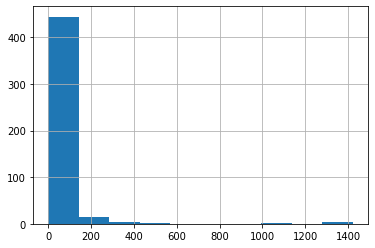

In [ ]:
true_books.recs_pop.hist();

**Вывод 1**

- Лишь 4 книги, которыми мы распылялись тысячами, попали в яблочко

- В основном выйграли те, которых в рекомендательном датасете было < 200

In [ ]:
(test_data.set_index('sys_numb')
.join(books_popularity)
.users_count.describe().to_frame('test')
.join(true_books.users_count.describe().to_frame('true_recs')))

,test,true_recs
count,78461.000000,553.000000
mean,1.479130,5.390597
std,1.155846,4.363392
min,1.000000,2.000000
25%,1.000000,2.000000
50%,1.000000,3.000000
75%,2.000000,7.000000
max,21.000000,21.000000


**Вывод 2**

- Из 75% книг, которые читали только один раз, мы не угадали ни одной

- Это логично, ведь идея Colloborative Filtering - использовать в рекомендациях данные о предпочтениях других читателях


### Пользователи, которых мы угадываем



Попробуем выяснить, для каких читателей подходят наши рекомендации на базе Colloborative Filtering.

Возможно, мы угадываем книги лишь для того 1% читателей, кто уже прочитал по 100 и 200 книг?

In [ ]:
true_books.set_index('chb').join(user_books_count).sort_values(by='books_count')

,recs_pop,users_count,author,title,bbk,books_count
chb,,,,,,
100000788981,8,3,none,Документы внешней политики СССР / Министерство...,none,2
200001018975,17,2,none,Ф.722 Собрание единичных поступлений рукописны...,none,3
200000979356,3,4,"Стасов, Владимир Васильевич (1824-1906)",Собрание сочинений В.В. Стасова. 1847-1886 : С...,none,3
300001090601,4,2,"Шевырева, Наталия Александровна","Уроки флористики. : Аранжировка, ассортимент, ...","М771,0",3
200001099771,58,8,none,Имена московских улиц : топонимический словарь,Д9(2-2М)0я212\nШ141.2-424,3
...,...,...,...,...,...,...
200001017435,2,2,отсутствует,отсутствует,отсутствует,805
200001017435,2,2,отсутствует,отсутствует,отсутствует,805
200001017435,1,3,отсутствует,отсутствует,отсутствует,805


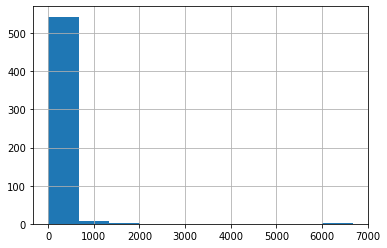

In [ ]:
true_books.set_index('chb').join(user_books_count).books_count.hist();

**Вывод**

1. Как интересно! Похоже, активность читателей имеет меньшую роль для качественных предсказаний

  - Мы попадали в яблочко для многих пользователей, которые прочитали не больше 3-х книг

  - У нас нет попаданий для редких пользователей, которые заказывали > 800 (пока мы не решили, с чем связан баг такого большого количества книг)

2. При этом для пользователей с 2-мя прочитанными книгами у нас (!) ни одного попадания.

# Дополнительно: LightFM - Matrix Factorization Baseline

### Вводные

Мы протестируем работу LightFM без добавления признаков (т.е. классический подход с Matrix Factorization для Collaborative Filtering).

1. Испытаем две loss функции:

  - WARP (Weighted Approximate Rank Pairwise Loss) 
  - (BPR) Bayesian Personalized Ranking  mode

2. Попробуем разбить датасет с помощью built-in функции библиотеки LightFM.

3. Сравним итоговые результаты с ALS и посмотрим также на значения других метрик (ROC-AUC и precision@k)

Тюнингом параметров пока заниматься не будем - это baseline модель, чтобы оценить возможности нового подхода.

In [ ]:
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 32.2 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=697454 sha256=fbdeb45ae5b29390f8494eccdbff90c2b480789be363f9006a63f00c26483375
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [ ]:
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split

# Встроенные функции lightfm для метрик
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score


### Подготовка данных

In [ ]:
book_actions = transactions = pd.read_csv('transactions_extended.csv', sep=';', index_col=None, dtype={'chb': str, 'date_1': str, 'is_printed': str, 'is_real': str, 'source': str, 'sys_numb': str, 'type': str})
book_actions.columns

FileNotFoundError: ignored

In [ ]:
book_actions = (unique_transactions
         .loc[lambda x: x.chb.isin(user_books_count.query(filter_111).index)])

In [ ]:
# Создаем идентификаторы для читателей и книг
# Внутренний датасет для lightfm
light_dataset = Dataset()
light_dataset.fit(book_actions['chb'], book_actions['sys_numb'])

num_users, num_books = light_dataset.transactions_shape()
print(f'Количество читатателей: {num_users}') 
print(f'Количество книг: {num_books}')

Количество читатателей: 7522
Количество книг: 123955


- Отлично, осталось передать все данные о выдачах книг модели

- Перед этим проверим, нет ли у нас дубликатов (кто-то повторно брал книги)

In [ ]:
book_actions[book_actions[['chb', 'sys_numb']].duplicated()]

,chb,sys_numb


- 30 000 дубликатов! Уберем их из обучения, но позже лучше проверить, с чем это связано

In [ ]:
book_user_unique = book_actions[['chb', 'sys_numb']].drop_duplicates()

In [ ]:
# Добавляем в lightfm данные для рекомендаций - пары {читатель, книга}
# на входе д.б тип iterables
(transactions, weights) = light_dataset.build_transactions(
    list(zip(book_user_unique.chb, book_user_unique.sys_numb)))

print(repr(transactions))

<7522x123955 sparse matrix of type '<class 'numpy.int32'>'
	with 142229 stored elements in COOrdinate format>


- Sparse матрица (users, books) для обучения модели готовы!

In [ ]:
# Проверяем, корректно ли сработал zip

# Исходный датасет
display(book_actions[['chb', 'sys_numb']].head(3))
print()

# Первые пары элементов в списке
list(zip(book_user_unique.chb, book_user_unique.sys_numb))[0:3]


,chb,sys_numb
3,100000644359,RSL01009800093
4,100000644359,RSL01003557352
5,100000644359,RSL01010587317


[('100000644359', 'RSL01009800093'),
 ('100000644359', 'RSL01003557352'),
 ('100000644359', 'RSL01010587317')]

- Все верно! Можем двигаться дальше)

### Разделение выборок (кросс-валидация)

In [ ]:
# Разделяем на выборки с помощью метода lightfm
# На выходе получаем две одинаковые sparse матрицы
train_fm, test_fm = random_train_test_split(
    transactions, 
    test_percentage=0.3, 
    random_state=777)

print(f"Обучающая выборка lightfm: {train_fm.get_shape()}")
print(f"Тестовая выборка lightfm: {test_fm.get_shape()}")

Обучающая выборка lightfm: (7522, 123955)
Тестовая выборка lightfm: (7522, 123955)


Главная особенность модели lightfm:
- одинаковое количество users и items в обучающей и тестовой матрицах

### Обучаем модель

In [ ]:
print("LightFM matrix factorization, loss функция = bpr")
model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(train_fm, epochs=10)

train_precision = precision_at_k(model, train_fm, k=20).mean()
test_precision = precision_at_k(model, test_fm, k=20).mean()

train_auc = auc_score(model, train_fm).mean()
test_auc = auc_score(model, test_fm).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))


LightFM matrix factorization, loss функция = bpr
Precision: train 0.00, test 0.00.
AUC: train 0.56, test 0.49.


In [ ]:
with open('savefile.pickle', 'wb') as fle:
    pickle.dump(model, fle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
epochs=5, num_threads=4, verbose=True 

In [ ]:
# load the model from disk
model = pickle.load(open('savefile.pickle', 'rb'))

### Выгружаем результаты

In [ ]:
model.get_item_representations(features=None)

array([-0.0344176 , -0.01944616,  0.01806399, ...,  0.01152962,
       -0.00060117, -0.01445462], dtype=float32)

In [ ]:
light_dataset.mapping()

({'100000641403': 0,
  '100000644359': 1,
  '100000665127': 2,
  '100000676191': 3,
  '100000679200': 4,
  '100000681262': 5,
  '100000683677': 6,
  '100000689674': 7,
  '100000692449': 8,
  '100000693475': 9,
  '100000695045': 10,
  '100000697273': 11,
  '100000698405': 12,
  '100000702964': 13,
  '100000704313': 14,
  '100000705925': 15,
  '100000706981': 16,
  '100000711986': 17,
  '100000715413': 18,
  '100000717512': 19,
  '100000717612': 20,
  '100000718304': 21,
  '100000720098': 22,
  '100000722110': 23,
  '100000722645': 24,
  '100000728030': 25,
  '100000730783': 26,
  '100000733127': 27,
  '100000733883': 28,
  '100000737450': 29,
  '100000738355': 30,
  '100000738392': 31,
  '100000739467': 32,
  '100000740302': 33,
  '100000740600': 34,
  '100000742468': 35,
  '100000743169': 36,
  '100000743827': 37,
  '100000745731': 38,
  '100000747862': 39,
  '100000748443': 40,
  '100000749657': 41,
  '100000749736': 42,
  '100000752636': 43,
  '100000753646': 44,
  '100000753959': 45